# Anthro GHG, Aerosols, and other species 
This code script quantifies historical (1750-2022) emissions, ERF, and temperture (del_T) contributions by sector of the the following:
* GHG: 
Carbon Dioxide (CO2),
Methane (CH4),
Nitrous Oxide (N2O),
Halogenated Compounds (CFCs, HFCs, HCFCs, etc.)
* Air pollutants:
NOx,
VOC’s,
CO,
SO2,
NH3,
* Aerosols:
Organic carbon,
Black Carbon

Emissions, ERF, and del_T contributions are allocated to the following sectors:
* Power
* fossil fuel production and distribution (ffpd)
* Industry
* Transportation
* Buildings
* Waste
* Agriculture

Data Sources:

Initial Emissions Data Gathered from [EDGAR - Emissions Database for Global Atmospheric Research](https://edgar.jrc.ec.europa.eu/emissions_data_and_maps), specifically EDGAR v8.0
https://edgar.jrc.ec.europa.eu/dataset_ghg70 and EDGAR v6.1 https://edgar.jrc.ec.europa.eu/dataset_ap61#sources

Final Emissions Data for major GHGs and air pollutants from [Community Emissions Data Systems (CEDS)](https://github.com/JGCRI/CEDS/blob/master/README.md) version v_2024_04_01. Emissions pre-1970 are from v_2021_04_21 fuel data with sector partitioning from latest version 1970 allocation.

HC (CFC, HCFC) emissions data from [WMO Ozone 2022 Report](https://csl.noaa.gov/assessments/ozone/2022/), HFC and HCFC emission data from [EDGAR - Emissions Database for Global Atmospheric Research](https://edgar.jrc.ec.europa.eu/emissions_data_and_maps), specifically EDGAR v8.0, with other species from [UNEP Ozone Depleting Substance databases](https://ozone.unep.org/countries/data-table). HC emissions sectoral fractions calculated using UNFCCC AFEAS database and UNEP ODS. See HC Section for specific details.

Final fuel consumption data from [International Energy Agency (IEA)](https://www.iea.org/data-and-statistics/data-product/world-energy-balances) to allocate ffpd sector emissions to other sectors

In [2423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import os

%matplotlib inline


### Sector decision
Run model with ffpd as a separate sector or allocated to other sectors?

In [2424]:
# 0 with ffpd, 1 w/o ffpd (ie ffpd allocated to other sectors)
choice_ffpd = 0

## CEDS & IEA
use emissions (kt) from CEDS database (v_2024_04_01) so able to compare 1750-2022\
use final fuel consumption data from [International Energy Agency (IEA)](https://www.iea.org/data-and-statistics/data-product/world-energy-balances) to allocate ffpd sector emissions to other sectors

In [2425]:
# path = (r'C:data\CEDS_v2021-04-21_emissions') # path to CEDS data
path = (r'C:data\CEDS_v_2024_04_01_aggregate') # path to CEDS data
# latest update is 2024_04_01

In [2426]:
# file_suffix = 'global_CEDS_emissions_by_sector_2021_04_21.csv'
file_suffix = '_CEDS_global_emissions_by_sector_v2024_04_01.csv'
fl_CEDS = [os.path.join(path, file) for file in os.listdir(path) if file.endswith(file_suffix) and os.path.isfile(os.path.join(path, file))]

In [2427]:
fl_CEDS

['C:data\\CEDS_v_2024_04_01_aggregate\\BC_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\CH4_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\CO2_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\CO_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\N2O_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\NH3_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\NMVOC_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\NOx_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\OC_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\SO2_CEDS_global_emissions_by_sector_v2024_04_01.csv']

In [2428]:
#load in CEDS data

list_df_em = []
units_dic = {}
for fn in fl_CEDS:
    _df = pd.read_csv(fn)
    u_em = _df['em'].unique()
    if len(u_em) > 1:
        print('double check, emission labels :')
        print(u_em)
    _em = u_em[0]
    u_units = _df['units'].unique()
    if len(u_units) > 1:
        print('double check, units labels :')
        print(u_units)
    _un = u_units[0]
    # _df_s = _df.drop(['em', 'sector', 'units'], axis=1).sum()
    #_df_s.index = pd.to_datetime(_df_s.index, format='X%Y').year
    # _df = pd.DataFrame(_df_s)#, columns=[_em])
    # # n = 3
    # # _df = _df.concat([[] for _ in range(n)], ignore_index=True)
    # new_cols = [f'X{i}'for i in range(2020,2023)]
    # # new_cols = [x for in in range(2020, 2023)]
    # new_data = {col: [np.nan] * len(_df) for col in new_cols}
    # _df = pd.concat([_df, pd.DataFrame(new_data)],axis=1)
    object_cols = _df.select_dtypes(include = ['object']).columns
    num_cols =  [col for col in _df.columns if col not in object_cols]
    keep_cols = _df[num_cols].columns
    _dfi = _df[num_cols].T.reset_index(drop=True)
    # _dfi.iloc[-8:,:] = _dfi.iloc[-8:,:].interpolate(method="slinear",fill_value="extrapolate",limit_direction="forward", axis=0)#, limit_area = 'inside')
    _dfi = _dfi.T
    _dfi.columns = keep_cols
    _df2 = pd.concat([_df[object_cols],_dfi], axis=1)
    units_dic[_em] = _un
    list_df_em.append(_df2)

In [2429]:
_df2

,em,sector,units,X1750,X1751,X1752,X1753,X1754,X1755,X1756,...,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022
0,SO2,1A1a_Electricity-autoproducer,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1724.978974,1932.527508,1869.355028,2258.299027,2213.408455,2332.203972,2619.737394,2467.334588,2461.681868,2649.958401
1,SO2,1A1a_Electricity-public,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,28406.589078,28621.122812,27007.382516,25271.928448,24559.471605,24591.824096,24722.387466,22747.606407,24361.146484,24723.952756
2,SO2,1A1a_Heat-production,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7434.871972,6461.066138,5986.914710,5130.638734,4630.734635,4774.851465,4540.965428,4236.785697,4458.659758,4328.113688
3,SO2,1A1bc_Other-transformation,ktSO2,2.934066,2.934066,2.935216,2.935216,2.936366,2.937515,3.139865,...,3274.873550,3083.305550,2699.517375,2649.338138,2439.685129,2489.074647,2490.133710,2477.997712,2508.657240,2527.955369
4,SO2,1A2a_Ind-Comb-Iron-steel,ktSO2,0.000000,0.030188,0.060399,0.090599,0.120845,0.151116,0.193830,...,3531.242950,3205.653802,2638.984527,2180.816701,2076.358344,2031.149963,1991.112132,1962.025394,2103.019686,2135.328011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,SO2,5E_Other-waste-handling,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
57,SO2,6A_Other-in-total,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58,SO2,6B_Other-not-in-total,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59,SO2,7A_Fossil-fuel-fires,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,326.300000,326.300000,326.300000,326.300000,326.300000,326.300000,328.345183,330.285625,332.114331,333.833433


In [2430]:
#upload IEA Energy data used to partition ffpd to other sectors Source: IEA (2023), World Energy Balances (database)
IEA = pd.read_excel(r'C:data\WorldEnergyBalancesHighlights2023.xlsx', 'TimeSeries_1971-2022')

In [2431]:
IEA.columns = IEA.iloc[0,:]
IEAw = IEA[IEA.Country == 'World']

In [2432]:
# IEAw[IEAw['Product'].str.contains('|'.join(['Crude']))]#.iloc[-5:,:]
# IEA

In [2433]:
iea = {}
iea['coal'] = IEAw[IEAw['Product'].str.contains('|'.join(['Coal']))].iloc[np.r_[4, 7:12],:]
iea['crude'] = IEAw[IEAw['Product'].str.contains('|'.join(['Crude']))].iloc[np.r_[4, 7:12],:]
iea['gas'] = IEAw[IEAw['Product'].str.contains('|'.join(['Natural gas']))].iloc[np.r_[4, 7:12],:]
iea['oil'] = IEAw[IEAw['Product'].str.contains('|'.join(['Oil']))].iloc[np.r_[4, 7:12],:]


iea_fracs = {}

for fuel in iea.keys():
    # iea[fuel]['type'] = fuel
    iea[fuel] = iea[fuel].drop(columns = '2022 Provisional')
    iea[fuel][2022] = np.nan
    iea[fuel] = iea[fuel].iloc[:,5:].rename(columns = {'NoFlow':'sector'}).reset_index(drop=True)
    iea_cols = iea[fuel].columns
    iea[fuel].columns = np.arange(len(iea[fuel].columns))
    iea[fuel].iloc[:,-8:] = iea[fuel].iloc[:,-8:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward", axis = 1)
    iea[fuel].columns = iea_cols
    sectors = [str(row.split(r'. ')[1]) for row in iea[fuel].sector]
    iea[fuel]['sectors'] = ['Energy','Industry', 'Transportation','Buildings','Waste','Agriculture']
    iea[fuel] = iea[fuel].set_index('sectors').drop(columns = 'sector')
    iea[fuel].loc['Energy'] = iea[fuel].loc['Energy'] * -1
    dupcolumns = {i: iea[fuel][1971] for i in range(1750,1971)}
    add_cols = pd.DataFrame(dupcolumns)
    # add_cols = pd.DataFrame(iea[fuel].iloc[:,0], index = iea[fuel].index, columns = [i for i in range(1750, 1971)])
    iea[fuel] = pd.concat([add_cols,iea[fuel]], axis=1)
    iea[fuel].columns = ['X' + str(x) for x in iea[fuel].columns]
    # iea_fracs = iea.copy()
    iea_fracs[fuel] = iea[fuel].div(iea[fuel].sum())

iea['og'] = iea['oil'] +iea['gas'] + iea['crude'] # combine oil and gas to match CEDS ffpd emissions sectors
iea_fracs['og'] = iea['og'].div(iea['og'].sum())

<Axes: xlabel='sectors'>

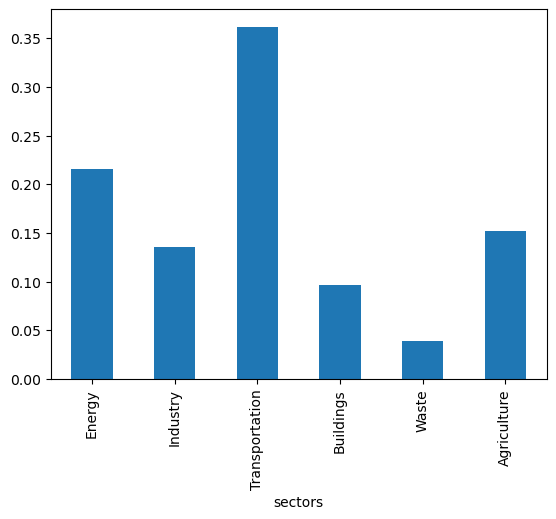

In [2434]:
iea_fracs['og'].iloc[:,-1].plot(kind = 'bar')#.loc['Power']

In [2435]:
# iea_fracs['og'] 
#iea['gas']
#iea['og'].div(iea['og'].sum())

In [2436]:
# IEAw.Product.unique()#[IEAw.Product.str.contains('fossil')]
# IEAw[IEAw.Product.str.contains('Fossil')]

In [2437]:
#Build decay functions (not used, each decay function is reassigned for the LLCFs)
ch4_lifetime = 11.8
t = np.flip(np.arange(0,52,1))
t2 = np.flip(np.arange(0,32,1))
t3 = np.flip(np.arange(0,33,1))
ch4d = np.exp(-t/ch4_lifetime)
n2o_lifetime = 109


def methd(x):
    d = x * np.exp(-t/ch4_lifetime)
    return d
    
#N2O decay function
def nitrod(x):
    d = x * np.exp(-t/n2o_lifetime)
    return d
    
# F gases decay function
def fluod(x):
    r = x[:-1]
    y = x['lifetime']
    d = r * np.exp(-t3/y)
    return d
    
# CO2 decay function
def carbd(x):
#Grasser 2017
    a0 = 0.2366
    a1 = 0.2673
    a2 = 0.2712
    a3 = 0.2249
    tc1 = 4.272
    tc2 = 33.10
    tc3 = 302.4
# AR 5
#     a0 = 0.2173
#     a1 = 0.224
#     a2 = 0.2824
#     a3 = 0.2763
#     t1 = 394.4
#     t2 = 36.54
#     t3 = 4.304
#     d = x * g*(a1*t1*(1-np.exp(-t/t1))+a2*t2*(1-np.exp(-t/t2))+a3*t3*(1-np.exp(-t/t3)))
#     d = x * g*(a1*np.exp(-t/t1)+a2*np.exp(-t/t2)+a3*np.exp(-t/t3))
    d = x*(a0 + a1 * np.exp(-t/tc1) + a2 * np.exp(-t/tc2) + a3 * np.exp(-t/tc3))
    return d

In [2438]:
#CEDS Emissions Sector partitioning
#Combustion and Process sector related emissions are seperate in data but combined here

energy = ['1A1a','7A']
ffpd = ['1A1bc','1B1','1B2','1B2b', '1B2d']
agriculture = ['3B', '3D', '3I', '3E','1A4c'] #inclusive of forestry
industry = ['1A2a','1A2b','1A2c', '1A2d', '1A2e','1A2f','1A2g', '2A1','2A2','2A6','2B','2C','2D','2H','2L','6A','6B',\
            '2B2', '2Ax','7BC','2B3','1A5']
transportation = ['1A3b', '1A3di','1A3c','1A3aii','1A3dii','1A3eii','1A3ai']
buildings = ['1A4a','1A4b']
waste = ['5A','5E','5C','5D']
# landuse = ['1A4c']


def sum_and_rename2(data):
    industry_sum = data[data.sector.str.contains('|'.join(industry))].sum().to_frame().T
    transportation_sum = data[data.sector.str.contains('|'.join(transportation))].sum().to_frame().T
#     burning_biomass_sum = data[data.sectors.isin(burning_biomass)].sum().to_frame().T
    energy_sum = data[data.sector.str.contains('|'.join(energy))].sum().to_frame().T
    ffpd_sum = data[data.sector.str.contains('|'.join(ffpd))].sum().to_frame().T
    waste_sum = data[data.sector.str.contains('|'.join(waste))].sum().to_frame().T
    agriculture_sum = data[data.sector.str.contains('|'.join(agriculture))].sum().to_frame().T
    buildings_sum = data[data.sector.str.contains('|'.join(buildings))].sum().to_frame().T
#     other_sum = data[data.sectors.isin(other)].sum().to_frame().T
    # lulucf_sum = data[data.sector.str.contains('|'.join(landuse))].sum().to_frame().T
    
    industry_sum['sectors']= 'Industry'
    transportation_sum['sectors'] = 'Transportation'
#     burning_biomass_sum['sectors'] = 'Burning'
    energy_sum['sectors'] = 'Energy'
    ffpd_sum['sectors'] = 'ffpd'
    waste_sum['sectors'] = 'Waste'
    agriculture_sum['sectors'] = 'Agriculture'
    buildings_sum['sectors'] = 'Buildings'
#     other_sum['sectors'] = 'Other'
    # lulucf_sum['sectors'] = 'LULUCF'
    
    result = pd.concat([energy_sum, ffpd_sum,waste_sum,agriculture_sum,industry_sum, transportation_sum,buildings_sum])#,lulucf_sum])
    return result


#specific ffpd
coal = ['1A1bc','1B1']
oil = ['1B2','1B2d']
gas = ['1B2','1B2d']
og = ['1B2']#,'1B2d'] # oil and gas includes all 1B2 category which is '1B2','1B2b','1B2d'

#Seperate ffpd and allocate to other sectors based on IEA consumption data
def sum_and_rename3(data):
    industry_sum = data[data.sector.str.contains('|'.join(industry))].sum().to_frame().T
    transportation_sum = data[data.sector.str.contains('|'.join(transportation))].sum().to_frame().T
#     burning_biomass_sum = data[data.sectors.isin(burning_biomass)].sum().to_frame().T
    energy_sum = data[data.sector.str.contains('|'.join(energy))].sum().to_frame().T
    
    # ffpd_sum = data[data.sector.str.contains('|'.join(ffpd))].sum().to_frame().T
    non_string_cols = data.select_dtypes(exclude = ['object']).columns
    instance_one = data.columns.get_loc(non_string_cols[0])
    instance_end = data.columns.get_loc(non_string_cols[-1])
    start = 272-(instance_end-instance_one)
    ffpd_coal = iea_fracs['coal'].iloc[:,start:].mul(data[data.sector.str.contains('|'.join(og))].iloc[:,instance_one:].sum().values, axis=1).reset_index(drop=False)
    ffpd_og = iea_fracs['og'].iloc[:,start:].mul(data[data.sector.str.contains('|'.join(coal))].iloc[:,instance_one:].sum().values, axis=1).reset_index(drop=False)
    
    waste_sum = data[data.sector.str.contains('|'.join(waste))].sum().to_frame().T
    agriculture_sum = data[data.sector.str.contains('|'.join(agriculture))].sum().to_frame().T
    buildings_sum = data[data.sector.str.contains('|'.join(buildings))].sum().to_frame().T
#     other_sum = data[data.sectors.isin(other)].sum().to_frame().T
    # lulucf_sum = data[data.sector.str.contains('|'.join(landuse))].sum().to_frame().T
    
    industry_sum['sectors']= 'Industry'
    transportation_sum['sectors'] = 'Transportation'
#     burning_biomass_sum['sectors'] = 'Burning'
    energy_sum['sectors'] = 'Energy'
    # ffpd_sum['sectors'] = 'ffpd'
    waste_sum['sectors'] = 'Waste'
    agriculture_sum['sectors'] = 'Agriculture'
    buildings_sum['sectors'] = 'Buildings'
#     other_sum['sectors'] = 'Other'
    # lulucf_sum['sectors'] = 'LULUCF'
    
    result = pd.concat([energy_sum, ffpd_coal, ffpd_og,waste_sum,agriculture_sum,industry_sum, transportation_sum,buildings_sum])#,lulucf_sum])
    return result

In [2439]:
# Unique CEDS subs-sector IDs
# set([col.split('_')[0] for col in co2c_years.sector.values])
# co2c_years.sector.values

In [2440]:
# iea_fracs['coal'].iloc[:,start:].mul(data[data.sector.str.contains('|'.join(og))].iloc[:,instance_one:].sum().values, axis=1).reset_index(drop=False)

In [2441]:
#Load Long lived climate forcers from CEDS

ch4 = list_df_em[1]
co2 = list_df_em[2]
n2o = list_df_em[4]

### Short lived Climate Forcers (SLCF)
SLCF emissions (kt) timeseries (1750-2022):
* Black Carbon (BC),
* Carbon Monoxide (CO),
* Ammonia (NH3),
* Volatile Organic Carbon (VOC),
* Nitrogen Oxides (NOx),
* Organic Carbon (OC),
* Sulfur Dioxide (SO2))


In [2442]:
#Load Short lived climate forcers from CEDS
if choice_ffpd == 0:
    bcc = sum_and_rename2(list_df_em[0]).drop(columns = {'em','sector','units'}).set_index('sectors')
    coc = sum_and_rename2(list_df_em[3]).drop(columns = {'em','sector','units'}).set_index('sectors')
    nh3c = sum_and_rename2(list_df_em[5]).drop(columns = {'em','sector','units'}).set_index('sectors')
    vocc = sum_and_rename2(list_df_em[6]).drop(columns = {'em','sector','units'}).set_index('sectors')
    noxc = sum_and_rename2(list_df_em[7]).drop(columns = {'em','sector','units'}).set_index('sectors')
    occ = sum_and_rename2(list_df_em[8]).drop(columns = {'em','sector','units'}).set_index('sectors')
    so2c = sum_and_rename2(list_df_em[9]).drop(columns = {'em','sector','units'}).set_index('sectors')

else: #SLCF WITH FFPD SEPARATED
    bcc = sum_and_rename3(list_df_em[0]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    coc = sum_and_rename3(list_df_em[3]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    nh3c = sum_and_rename3(list_df_em[5]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    vocc = sum_and_rename3(list_df_em[6]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    noxc = sum_and_rename3(list_df_em[7]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    occ = sum_and_rename3(list_df_em[8]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    so2c = sum_and_rename3(list_df_em[9]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')

In [2443]:
bcc

,X1750,X1751,X1752,X1753,X1754,X1755,X1756,X1757,X1758,X1759,...,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022
sectors,,,,,,,,,,,,,,,,,,,,,
Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,229.451953,240.161932,243.555638,280.156787,303.825041,324.175992,342.407408,363.240384,404.033374,403.067743
ffpd,0.067133,0.067273,0.067413,0.067553,0.067693,0.067833,0.067973,0.068113,0.068253,0.068393,...,608.583137,513.932947,426.64504,421.460863,413.412887,425.227888,435.42758,439.63235,445.100777,434.743208
Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,271.565345,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007
Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,284.306778,280.526555,273.498577,262.058999,277.223557,264.929857,255.505276,238.149937,238.589395,237.834528
Industry,8.764243,8.787549,8.810955,8.834262,8.857669,8.881077,8.922163,8.94566,8.969158,8.992658,...,943.520023,932.362728,906.34775,817.303365,772.125124,749.053528,721.600988,704.254529,701.652557,702.467605
Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1358.47201,1342.816277,1317.922529,1308.410337,1323.921889,1321.469381,1258.401739,1101.482018,1133.088513,1125.070703
Buildings,511.264724,512.522781,513.781557,515.036997,516.293156,517.548005,519.156042,520.408186,521.65902,522.908546,...,2438.735393,2420.913983,2391.460445,2349.234117,2356.942414,2269.394165,2213.929842,2180.026925,2160.710616,2152.063083


In [2444]:
# import pandas as pd
# from pandas.api.types import is_string_dtype
# from pandas.api.types import is_numeric_dtype


In [2445]:
# bcc.drop(columns = 'sectors')
# years = [x.strip('X') for x in bcc.drop(columns = 'sectors').columns]
# bcc.reindex(bcc.columns.tolist() + ['X2020','X2021', 'X2022'], axis=1).drop(columns = 'sectors').T.reset_index(drop=True)

In [2446]:
#Generate DataFrame of SLCFs for current year (2022)
ceds_slcf_tot = {}
bc_aggc = bcc
ceds_slcf_tot['bc']=bc_aggc.iloc[:,-1]

co_aggc = coc
ceds_slcf_tot['co']=co_aggc.iloc[:,-1]

nh3_aggc = nh3c
ceds_slcf_tot['nh3']=nh3_aggc.iloc[:,-1]

voc_aggc = vocc
ceds_slcf_tot['voc']=voc_aggc.iloc[:,-1]

nox_aggc = noxc
ceds_slcf_tot['nox']=nox_aggc.iloc[:,-1]

oc_aggc = occ
ceds_slcf_tot['oc']=oc_aggc.iloc[:,-1]

so2_aggc = so2c
ceds_slcf_tot['so2']=so2_aggc.iloc[:,-1]

ceds_df_slcf_tot = pd.concat(ceds_slcf_tot, axis=1).reset_index(drop=True)  # ['CO2'].loc[1752]
ceds_df_slcf_tot.columns


Index(['bc', 'co', 'nh3', 'voc', 'nox', 'oc', 'so2'], dtype='object')

In [2447]:
ceds_df_slcf_tot

,bc,co,nh3,voc,nox,oc,so2
0,403.067743,12309.864058,254.396189,1908.761473,21914.712912,1280.578906,32035.858278
1,434.743208,46539.601672,1070.013506,32559.187666,3756.400061,240.545877,6748.900214
2,278.45007,17056.656213,9025.85012,2792.91071,2463.537414,1762.982702,235.232941
3,237.834528,6915.025657,49446.321386,12518.97377,8760.703883,212.46156,716.546447
4,702.467605,89960.650805,994.146114,44428.22561,16700.951072,1655.579676,23986.430555
5,1125.070703,80936.164262,474.415009,17761.024282,55420.548821,618.622392,6498.356578
6,2152.063083,171013.069137,2739.492867,22008.825443,4380.271166,7206.671038,3245.635698


In [2449]:
# Generate DataFrame of SLCF for all years
years = [x.strip('X') for x in bcc.columns]
ceds_df_slcf_all = {'bc':bc_aggc,'co':co_aggc,'nh3':nh3_aggc,'voc':voc_aggc,'nox':nox_aggc,'oc':oc_aggc,'so2':so2_aggc}

for k, df in ceds_df_slcf_all.items():
    # ceds_df_slcf_all[k] = df.set_index('sectors')#.iloc[:,:-1]
    ceds_df_slcf_all[k].columns = years
    ceds_df_slcf_all[k] = ceds_df_slcf_all[k].reset_index()
    ceds_df_slcf_all[k]['total'] = ceds_df_slcf_all[k]['2022']


In [2450]:
ceds_df_slcf_all#['bc'].sum()

{'bc':           sectors        1750        1751        1752        1753        1754  \
 0          Energy         0.0         0.0         0.0         0.0         0.0   
 1            ffpd    0.067133    0.067273    0.067413    0.067553    0.067693   
 2           Waste         0.0         0.0         0.0         0.0         0.0   
 3     Agriculture         0.0         0.0         0.0         0.0         0.0   
 4        Industry    8.764243    8.787549    8.810955    8.834262    8.857669   
 5  Transportation         0.0         0.0         0.0         0.0         0.0   
 6       Buildings  511.264724  512.522781  513.781557  515.036997  516.293156   
 
          1755        1756        1757       1758  ...         2014  \
 0         0.0         0.0         0.0        0.0  ...   240.161932   
 1    0.067833    0.067973    0.068113   0.068253  ...   513.932947   
 2         0.0         0.0         0.0        0.0  ...    278.45007   
 3         0.0         0.0         0.0        0.0  .

# Calculate decayed and yearly cumulative emissions 

## Carbon Dioxide (CO2)
CO2 emissions (kt) timeseries (1750-2022)

In [2451]:
#co2

In [2452]:
# Generate Dataframe of CO2 emissions prior to calculating cumulative decayed emissions
co2c_years = co2.iloc[:,3:]
years = [int(col.split('X')[1]) for col in co2c_years.columns if col.startswith('X')]
co2c_years.columns = years
co2c_years['sector'] = co2.sector

co2c_years_pre = sum_and_rename2(co2c_years).drop(columns = 'sector').set_index('sectors')#.rename(columns={'sector','sectors'})
co2c_years_pre#.sum()

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12988908.847302,13057247.765065,12788075.606014,12788694.490239,13106106.935999,13480946.348199,13359648.307235,12878264.77148,13925956.93673,13842420.169978
ffpd,1737.192919,1738.163545,1739.712198,1740.682825,1742.231478,1743.780131,1846.483431,1848.032084,1849.580737,1851.12939,...,2436582.728042,2369699.39939,2448243.025233,2373778.957924,2444750.024006,2513366.103899,2635938.333247,2721625.354621,2842145.007517,2849452.397426
Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46988.132156,48756.600877,49380.560374,49995.255929,50596.899667,51189.006659,51767.987113,52334.941051,52890.277543,53432.850636
Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,426611.053715,427187.212185,428888.330899,429228.255893,444376.146991,441913.173088,429366.229773,414440.90336,423411.536295,422060.614066
Industry,3285.289053,3286.228321,3288.455665,3289.395302,3291.62375,3293.852934,3521.753628,3524.048693,3526.344495,3528.641032,...,8594197.69882,8807563.713363,8629635.413984,8541483.920359,8456521.906614,8504767.993746,8565282.017645,8520018.811358,8739647.008643,8585460.536549
Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7353643.491348,7466173.912481,7699576.803981,7858780.772125,8054816.70769,8240182.164339,8266947.79364,7089063.301601,7625919.131373,7795914.81478
Buildings,3816.34391,3815.404641,3815.960069,3815.020433,3815.574756,3816.128344,4077.99544,4078.483146,4078.970117,4079.456351,...,2640332.178338,2597126.153285,2630483.117932,2664014.91657,2721157.379573,2750204.543123,2734702.430537,2677052.970958,2724905.965203,2677022.823315


In [2130]:
# Generate Dataframe of CO2 emissions with ffpd allocated to other sectors prior to calculating cumulative decayed emissions
co2c_years_pre_noffpd = sum_and_rename3(co2.drop(columns = ['em','units'])).groupby(by = 'sectors', as_index= False).sum().drop(columns = 'sector').set_index('sectors')
years = [int(col.split('X')[1]) for col in co2c_years_pre_noffpd.columns if col.startswith('X')]
co2c_years_pre_noffpd.columns = years
co2c_years_pre_noffpd#.sum()

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Agriculture,221.977277,222.101303,222.299189,222.423215,222.621101,222.818987,235.942341,236.140227,236.338113,236.535999,...,726118.383557,724253.07536,734042.524174,724821.957352,754557.408581,756844.80785,762610.553649,783562.532214,806154.791068,803561.79661
Buildings,4016.354662,4015.527146,4016.260877,4015.432993,4016.16562,4016.897511,4290.589295,4291.255305,4291.920578,4292.585116,...,2847929.894093,2793269.899129,2833058.013773,2861577.962386,2926457.978932,2964147.473891,2956358.068421,2925234.648097,2975524.644847,2920695.796305
Energy,271.67189,271.823682,272.065869,272.21766,272.459847,272.702034,288.763348,289.005535,289.247722,289.489909,...,13695588.86956,13744686.290937,13492403.070677,13474753.970145,13810076.867494,14208108.612874,14127548.942919,13667974.985731,14750079.388212,14667039.958467
Industry,3695.595873,3696.764394,3699.357513,3700.526401,3703.120625,3705.715585,3957.873726,3960.534567,3963.196144,3965.858457,...,8950989.732294,9156113.346284,8982934.888824,8879141.472403,8798966.255354,8856878.922176,8940331.941402,8925922.539589,9157330.810563,8998776.423332
Transportation,522.939315,523.231498,523.697682,523.989866,524.45605,524.922234,555.838543,556.304727,556.770911,557.237095,...,8131604.794882,8224032.826403,8497719.709603,8633791.901579,8854119.670508,9059324.872286,9115181.673758,7904013.195879,8495520.119893,8685043.537964
Waste,110.286864,110.348485,110.446803,110.508423,110.606741,110.705058,117.225246,117.323564,117.421881,117.520198,...,135032.455336,131399.318534,134124.651365,131889.305174,134147.819672,137264.643977,141621.919043,146093.152919,150266.108721,150646.694071


In [2131]:
# co2c_years_pre = sum_and_rename3(co2).groupby(by = 'sectors').sum().drop(columns = ['em','sector','units'])
# co2c_years_pre

In [2132]:
# co2_hist_decayc2

In [2133]:
#Define decay function to use for CO2
t = np.arange(1750,2023,1)
def decay(t):
    a0 = 0.2366
    a1 = 0.2673
    a2 = 0.2712
    a3 = 0.2249
    tc1 = 4.272
    tc2 = 33.10
    tc3 = 302.4
    return a0 + a1 * np.exp(-t/tc1) + a2 * np.exp(-t/tc2) + a3 * np.exp(-t/tc3)

In [2134]:
import warnings
warnings.filterwarnings('ignore') #ignoring RunTime Warning 

#set up DataFrame to run decay and choose w/ffpd or w/o ffpd


# Run code to generate cumulative decayed emissions

if choice_ffpd == 0:
    co2_decay_use = co2c_years_pre
else:
    co2_decay_use = co2c_years_pre_noffpd
    
cum_emiss = pd.DataFrame(index = co2_decay_use.index)
for year in co2_decay_use.columns[0:]:
    """
    
   Description:
    Decay function is applying the decay to each year and calculating the cumulative emissions for each year
    such that for the third year in the timeseries (1752) which is the decayed emissions for 1750 and 1751 + emissions in 1752: 
    cumulative emissions (1752) = (((co2_decay_use.iloc[:,1] + (co2_decay_use.iloc[:,0] * decay)))*decay)+ co2_decay_use.iloc[:,2]
     
    """
    cum_emiss[f'{year}'] =  co2_decay_use.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )

cum_emiss['sector'] = co2_decay_use.index

# with ffpd
# co2_hist_decayc = sum_and_rename2(cum_emiss).drop(columns = ['sector', 'sectors'])#.rename_axis('sector')
# co2_hist_decayc.index = co2c_years_pre.index
# co2_hist_decayc = co2_hist_decayc.T

# w/o ffpd

#either w/ or w/o ffpd
co2_hist_decayc = cum_emiss.set_index('sector') # for ffpd separated verison
# co2_hist_decayc = co2_hist_decayc.T#.sum(axis=1)
co2_hist_decayc 

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sector,,,,,,,,,,,,,,,,,,,,,
Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.493764e+08,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08
ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,14521.264471,...,7.202186e+07,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07
Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.450119e+05,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05
Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329934e+07,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07
Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,27557.871692,...,2.461809e+08,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08
Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.742855e+08,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08
Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,31928.859256,...,1.008350e+08,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08


In [2135]:
co2c_years_noffpd

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,sector
0,221.977277,222.101303,222.299189,222.423215,222.621101,222.818987,235.942341,236.140227,236.338113,236.535999,...,724253.07536,734042.524174,724821.957352,754557.408581,756844.80785,762610.553649,783562.532214,806154.791068,803561.79661,Agriculture
1,4016.354662,4015.527146,4016.260877,4015.432993,4016.16562,4016.897511,4290.589295,4291.255305,4291.920578,4292.585116,...,2793269.899129,2833058.013773,2861577.962386,2926457.978932,2964147.473891,2956358.068421,2925234.648097,2975524.644847,2920695.796305,Buildings
2,271.67189,271.823682,272.065869,272.21766,272.459847,272.702034,288.763348,289.005535,289.247722,289.489909,...,13744686.290937,13492403.070677,13474753.970145,13810076.867494,14208108.612874,14127548.942919,13667974.985731,14750079.388212,14667039.958467,Energy
3,3695.595873,3696.764394,3699.357513,3700.526401,3703.120625,3705.715585,3957.873726,3960.534567,3963.196144,3965.858457,...,9156113.346284,8982934.888824,8879141.472403,8798966.255354,8856878.922176,8940331.941402,8925922.539589,9157330.810563,8998776.423332,Industry
4,522.939315,523.231498,523.697682,523.989866,524.45605,524.922234,555.838543,556.304727,556.770911,557.237095,...,8224032.826403,8497719.709603,8633791.901579,8854119.670508,9059324.872286,9115181.673758,7904013.195879,8495520.119893,8685043.537964,Transportation
5,110.286864,110.348485,110.446803,110.508423,110.606741,110.705058,117.225246,117.323564,117.421881,117.520198,...,131399.318534,134124.651365,131889.305174,134147.819672,137264.643977,141621.919043,146093.152919,150266.108721,150646.694071,Waste


In [2136]:
co2_decay_use

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12988908.847302,13057247.765065,12788075.606014,12788694.490239,13106106.935999,13480946.348199,13359648.307235,12878264.77148,13925956.93673,13842420.169978
ffpd,1737.192919,1738.163545,1739.712198,1740.682825,1742.231478,1743.780131,1846.483431,1848.032084,1849.580737,1851.12939,...,2436582.728042,2369699.39939,2448243.025233,2373778.957924,2444750.024006,2513366.103899,2635938.333247,2721625.354621,2842145.007517,2849452.397426
Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46988.132156,48756.600877,49380.560374,49995.255929,50596.899667,51189.006659,51767.987113,52334.941051,52890.277543,53432.850636
Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,426611.053715,427187.212185,428888.330899,429228.255893,444376.146991,441913.173088,429366.229773,414440.90336,423411.536295,422060.614066
Industry,3285.289053,3286.228321,3288.455665,3289.395302,3291.62375,3293.852934,3521.753628,3524.048693,3526.344495,3528.641032,...,8594197.69882,8807563.713363,8629635.413984,8541483.920359,8456521.906614,8504767.993746,8565282.017645,8520018.811358,8739647.008643,8585460.536549
Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7353643.491348,7466173.912481,7699576.803981,7858780.772125,8054816.70769,8240182.164339,8266947.79364,7089063.301601,7625919.131373,7795914.81478
Buildings,3816.34391,3815.404641,3815.960069,3815.020433,3815.574756,3816.128344,4077.99544,4078.483146,4078.970117,4079.456351,...,2640332.178338,2597126.153285,2630483.117932,2664014.91657,2721157.379573,2750204.543123,2734702.430537,2677052.970958,2724905.965203,2677022.823315


Text(0.5, 1.0, 'CO2 Historical Emissions')

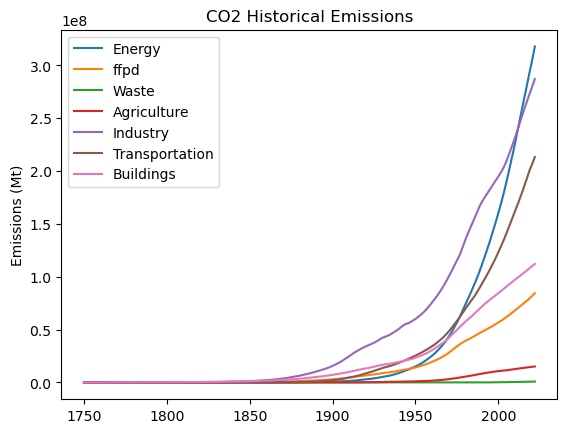

In [2137]:
co2_hist_decayc.T.plot()

plt.ylabel('Emissions (Mt)')

plt.legend(loc='upper left')

plt.title('CO2 Historical Emissions')



In [2138]:
# (co2_hist_decayc.iloc[-1,:]/co2_hist_decayc.iloc[-1,:].sum(axis=0))

<Axes: xlabel='sector'>

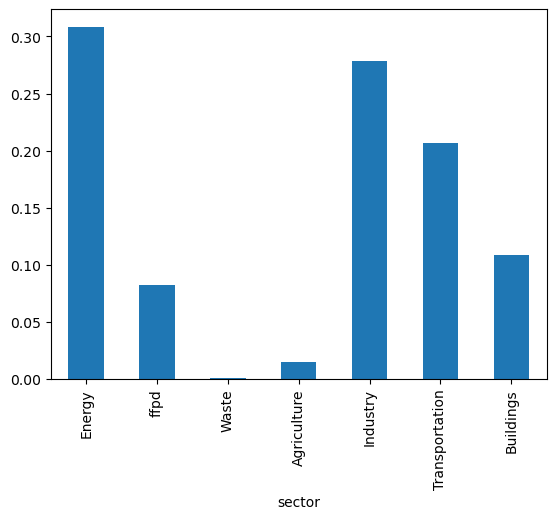

In [2139]:
(co2_hist_decayc.iloc[:,-1]/co2_hist_decayc.iloc[:,-1].sum(axis=0)).plot(kind = 'bar')

### CHECK
make sure decay model is correct

In [2140]:
#Original Equation that calculates the remaining CO2 for the present year (2022)
t = np.flip(np.arange(0,273,1))
carbon_decayedc = co2c_years.drop(columns = 'sector').apply(lambda x: carbd(x), axis=1)
carbon_decayedc['total'] = carbon_decayedc.sum(axis=1)
carbon_decayedc['sector'] = co2c_years.sector
carbon_decayed_fractionc = carbon_decayedc.iloc[:,0:-1].div(carbon_decayedc.total, axis=0)

In [2141]:
# CHECK: if the cumulative decay emission (2022) match the simple decay sum, than good
carbon_decayedc.sum()['total'], co2_hist_decayc.iloc[:,-1].sum() #difference is negligible

(1031193494.2552786, 1031193494.2552791)

In [2463]:
 co2_hist_decayc

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,total
sector,,,,,,,,,,,,,,,,,,,,,
Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08,3.179339e+08
ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,14521.264471,...,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07,8.454892e+07
Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05,8.388944e+05
Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07,1.517191e+07
Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,27557.871692,...,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08,2.872136e+08
Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08,2.132984e+08
Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,31928.859256,...,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08,1.121878e+08


In [2143]:
# sum_and_rename2(carbon_decayedc)

## Nitrous Oxide (N2O)
N2O emissions (kt) timeseries (1970-2022), CEDS v2021_04_21 has data in the fuel file from (1750-2019), so data for those years is used (1750-1969) and sectors are allocated backward using 1969 allocation

In [2499]:
#Try cumulative decay emissions for 1970-2022 timeseries data

# t = np.flip(np.arange(0,53,1))
def decay(t):
    return np.exp(-t/109)

n2oc_years = n2o.iloc[:,3:]
years = [int(col.split('X')[1]) for col in n2oc_years.columns if col.startswith('X')]
n2oc_years.columns = years
n2oc_years['sector'] = n2o.sector

# Generate Dataframe of N2O emissions prior to calculating cumulative decayed emissions
n2oc_years_pre = sum_and_rename2(n2oc_years).drop(columns = 'sector').set_index('sectors')
n2oc_years_pre#.sum()#.index

#Generate Dataframe of N2O emissions prior to calculating cumulative decayed emissions for 1970-2022 timeseries data w/o ffpd
n2oc_years_pre_noffpd = sum_and_rename3(n2o).groupby(by = 'sectors').sum().drop(columns = ['em','sector','units'])
years = [int(col.split('X')[1]) for col in n2oc_years_pre_noffpd.columns if col.startswith('X')]
n2oc_years_pre_noffpd.columns = years
# n2oc_years_pre_noffpd = n2oc_years_pre_noffpd.reset_index(drop=True)
# n2oc_years_pre_noffpd ['sector'] = s

# Run code to generate cumulative decayed emissions

cum_emiss = pd.DataFrame(index = n2oc_years_pre.index)
cum_emiss_noffpd = pd.DataFrame(index = n2oc_years_pre_noffpd.index)
for year in n2oc_years_pre.columns[0:]:
    #with ffpd
    cum_emiss[f'{year}'] =  n2oc_years_pre.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )
    #ffpd separated and allocated to other sectors
    cum_emiss_noffpd[f'{year}'] =  n2oc_years_pre_noffpd.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )


# cum_emiss.insert(loc=0, column='1970', value=n2o['X1970'])
# cum_emiss['sector'] = n2o.sector
n2o_hist_decayc = cum_emiss# sum_and_rename2(cum_emiss).set_index('sectors').drop(columns = 'sector').T
# n2o_hist_decayc.sum(axis=1)

In [2500]:
#CHECK to make sure sum of cumulative decay emissions from inclusive ffpd and partitioned ffpd are same
n2o_hist_decayc.sum()[-1], cum_emiss.sum()[-1]

(353886.1009621947, 353886.1009621947)

### Concatenate past emissions (1750-1969) to current sector allocated data (1970-2022)

In [2501]:
#Initial Attempt to extend ch4 and n2o CEDS emissions so timeseries is 1750-2019 like co2 & slcfs
n2o_yy = pd.read_excel(r'C:data\TotalHistoricalCH4N2OforBlake.xlsx', 'Sheet1')
n2o_yy2 = n2o_yy.set_index('Year')/1e9 # 1gram is 1e-9 kt
# n2o_ceds.T.sum(axis=1)
n2o_yy2 = n2o_yy2 + 1000 # using shape of data and adjusting so del emission isnt a large step but the mean of the 1970s diff (1400)


In [2502]:
#load in CEDS historic emissions from fuel csv (v_2021_04_21)
n2o_cf= pd.read_csv(r'C:data\CEDS_v2021-04-21_emissions\N2O_global_CEDS_emissions_by_fuel_2021_04_21.csv')
n2o_cf = n2o_cf.groupby(by = 'em', as_index = False).sum().drop(columns = ['em','fuel','units'])

# Extrapolation code below not necessary because using (1750-1969) data
# n2o_cf[['X2020','X2021','X2022']] = np.nan
years = [int(col.split('X')[1]) for col in n2o_cf.columns if col.startswith('X')]
n2o_cf.columns = years
# n2o_cf.iloc[:,-8:] = n2o_cf.iloc[:,-8:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward", axis = 1)

In [2503]:
n2o_cf

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,365.305298,366.263846,367.222257,368.180415,369.138435,370.096259,371.064068,372.021505,372.978745,373.93579,...,9089.432786,9184.790563,9132.789298,9400.076436,9554.073397,9583.58638,9577.935584,9610.59056,9692.574706,9719.044243


In [2504]:
n2oc_years_pre_noffpd

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Agriculture,3234.109046,3330.740999,3423.458548,3543.312406,3576.452212,3772.573831,3866.278069,3959.148893,4096.670508,4237.104092,...,6795.87575,6879.438387,7210.801746,7181.143753,7028.92688,7080.550571,7068.36386,7143.789729,7163.108154,7169.982562
Buildings,163.531724,166.361837,168.480153,170.35745,170.79086,174.020341,177.14567,179.040398,181.045708,182.21758,...,204.165944,204.662895,203.759138,199.400559,199.730939,197.336991,194.714095,191.866826,192.177298,192.306358
Energy,49.429687,55.354581,58.694864,63.093728,65.743928,66.362993,71.810343,74.731628,76.898109,79.309907,...,337.2952,343.432299,336.555959,371.254278,379.443607,391.005599,382.619033,371.524595,405.00279,404.187393
Industry,1637.056671,1659.920967,1705.109379,1806.117274,1879.549323,1828.722876,1899.700819,1904.094709,1951.378543,1924.877433,...,1564.952491,1608.026354,1634.167205,1640.556995,1652.504848,1686.683148,1695.905195,1708.002817,1762.046307,1784.371329
Transportation,239.619162,250.936011,266.440026,281.374281,277.44186,284.233208,295.885498,304.172702,315.48591,313.101415,...,385.120387,381.287579,373.448059,360.512645,368.322321,374.918111,388.108364,338.730253,361.251823,368.386946
Waste,203.644722,208.141736,211.42326,216.339791,220.296746,225.634758,230.908518,234.83145,244.011966,249.979483,...,543.276626,553.024931,561.304338,571.151831,580.461871,587.774765,592.126101,595.813919,601.737783,608.919494


In [2505]:
# Combine v_2021_04_21 emissions(1750-1969) with v_2024_04_01 emissions (1970-2022)

if choice_ffpd == 0:
    n2o_decay_use = n2oc_years_pre # with (n2oc_years_pre) or w/o ffpd (n2oc_years_pre_noffpd)
else:
    n2o_decay_use = n2oc_years_pre_noffpd


# n2o_yy3 = pd.concat([n2o_yy2.iloc[0:99,:].T * x for x in (n2o_decay_use.iloc[:,0]/n2o_decay_use.iloc[:,0].sum())], ignore_index=True).rename_axis(None, axis=1)#.set_index(n2oc_years_pre.index)
# n2ocy = pd.concat([n2o_yy3, n2o_decay_use.reset_index(drop=True)], axis=1)

n2o_jp = pd.concat([n2o_cf.iloc[:, 0:220] * x for x in (n2o_decay_use.iloc[:,0]/n2o_decay_use.iloc[:,0].sum())], ignore_index=True).rename_axis(None, axis=1)#.set_index(n2oc_years_pre.index)
n2occ = pd.concat([n2o_jp, n2o_decay_use.reset_index(drop=True)], axis=1)
n2occ

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,3.058430,3.066455,3.074479,3.082501,3.090522,3.098541,3.106644,3.114660,3.122674,3.130686,...,330.223633,336.630817,329.72187,364.632617,372.72233,384.260537,375.645057,364.813424,398.211942,397.3359
1,0.740990,0.742934,0.744878,0.746822,0.748765,0.750708,0.752671,0.754613,0.756555,0.758496,...,22.728184,21.424018,21.701496,20.520131,20.846447,20.746186,21.40896,20.126673,20.215696,20.251264
2,13.412177,13.447370,13.482558,13.517737,13.552910,13.588077,13.623610,13.658762,13.693907,13.729045,...,542.487077,552.315445,560.590067,570.485949,579.791402,587.109848,591.441528,595.175282,601.103233,608.290274
3,213.673871,214.234543,214.795136,215.355580,215.915943,216.476193,217.042282,217.602305,218.162213,218.722006,...,6793.198626,6876.898133,7208.239623,7178.751432,7026.454371,7078.123943,7065.830271,7141.280317,7160.615061,7167.510821
4,108.004028,108.287426,108.570784,108.854068,109.137310,109.420495,109.706632,109.989702,110.272714,110.555668,...,1561.489137,1604.710077,1630.866157,1637.458216,1649.42239,1683.62907,1692.717749,1704.842246,1758.93416,1781.30796
5,15.691294,15.732468,15.773635,15.814792,15.855942,15.897085,15.938656,15.979782,16.020899,16.062008,...,378.252554,374.912646,366.862726,354.374169,362.068026,368.715652,381.765166,333.308668,355.698535,362.730535
6,10.724509,10.752650,10.780787,10.808916,10.837041,10.865161,10.893574,10.921682,10.949784,10.977881,...,202.307185,202.981311,202.054504,197.797548,198.085499,195.683947,193.027917,190.181529,190.545529,190.727328


In [2506]:
# Generate cumulative decayed emissions for each year (1750-2022)
t = np.flip(np.arange(0,273,1))
def decay(t):
    return np.exp(-t/109)
    
cum_emiss = pd.DataFrame(index = n2occ.index)
for year in n2occ.columns[0:]:
    """
    
   Description:
    Decay function is applying the decay to each year and calculating the cumulative emissions for each year
    (same as for CO2, but with associated decay function)
     
    """
    cum_emiss[f'{year}'] =  n2occ.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )

cum_emiss['sector'] = n2o_decay_use.index
# n2o_hist_decaycp = sum_and_rename2(cum_emiss).set_index('sectors').drop(columns = 'sector').T
n2o_hist_decaycy =cum_emiss.set_index('sector')#.drop(columns = 'sector')
n2o_hist_decaycyz = n2o_hist_decaycy
# n2o_hist_decaycy.sum()

In [2507]:
# sum(n2ocy[:n2ocy.index.get_loc(1871)][::-1]*[decay(j) for j in range(1, n2ocy.index.get_loc(1871)+1)])
# ((( n2ocy.iloc[:,1] + ( n2ocy.iloc[:,0] * np.exp(-1/109))))*np.exp(-1/109))+ n2ocy.iloc[:,2] # how the decay function is working for N2O
#((( n2occ.iloc[:,1] + ( n2occ.iloc[:,0] * np.exp(-1/109))))*np.exp(-1/109))+ n2occ.iloc[:,2] # how the decay function is working for N2O

### CHECK
make sure decay model is correct

In [2516]:
#Original Equation that calculates the remaining N2O for the present year (2022)
t = np.flip(np.arange(0,273,1))
def nitrod2(x):
    d = x * np.exp(-t/109)
    return d

n2o_decayedc = n2occ.reset_index(drop=True).apply(lambda x: nitrod(x), axis=1)
n2o_decayedc['total'] =n2o_decayedc.sum(axis=1)
n2o_decayedc['sector'] = n2oc_years_pre.index
n2o_decayed_fractionc = n2o_decayedc.iloc[:,0:-1].div(n2o_decayedc.total, axis=0)
# n2o_decayedc

In [2517]:
# CHECK: if the cumulative decay emission (2022) match the simple decay sum, than good
n2o_decayedc.sum()['total'], n2o_hist_decaycy.iloc[:,-1].sum() #difference is negligible

(444888.9500241908, 444888.95002419135)

Text(0.5, 1.0, 'N2O Cumulative Historical Emissions')

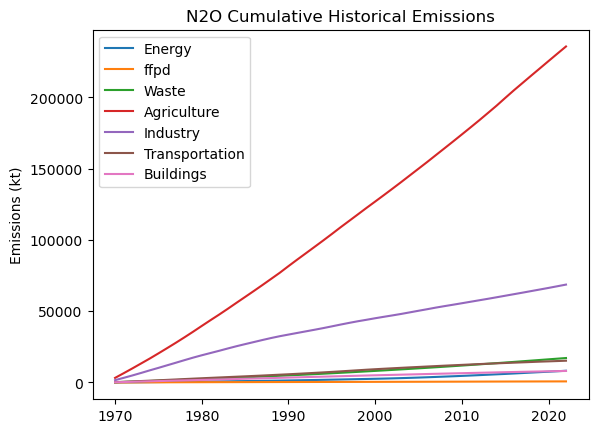

In [2518]:
n2o_hist_decayc.T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('N2O Cumulative Historical Emissions')

Text(0.5, 1.0, 'N2O Cumulative Historical Emissions')

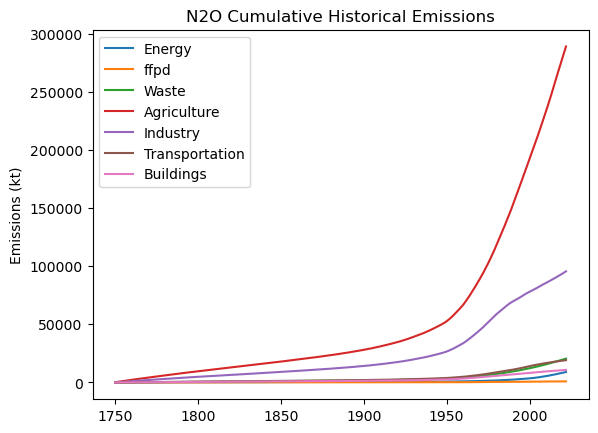

In [2519]:
n2o_hist_decaycyz.T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('N2O Cumulative Historical Emissions')

In [2520]:
# n2ocy.set_index(n2oc_years_pre.index).T.plot()

# plt.ylabel('Emissions (kt)')

# plt.legend(loc='upper left')

# plt.title('N2O Historical Emissions')

<Axes: xlabel='sector'>

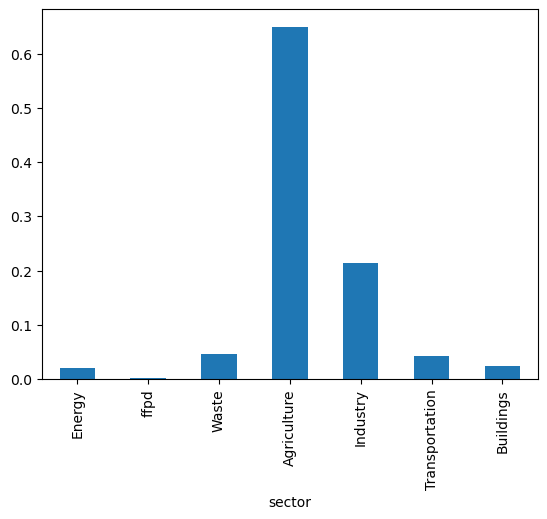

In [2521]:
(n2o_hist_decaycyz.T.iloc[-1,:]/n2o_hist_decaycyz.T.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

Text(0.5, 1.0, 'N2O Historical Emissions')

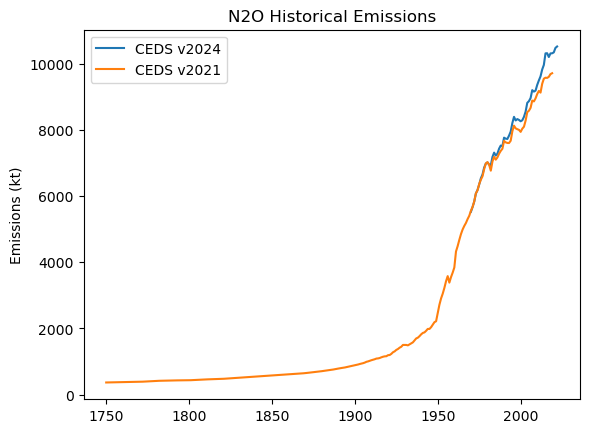

In [2522]:
sum_and_rename2(pd.read_csv(fl_CEDS[4])).drop(columns = {'em','sector','units'}).set_index('sectors').T.sum()
n2o_ceds = sum_and_rename2(pd.read_csv(fl_CEDS[4])).drop(columns = {'em','sector','units'}).set_index('sectors')
years = [int(col.split('X')[1]) for col in n2o_ceds.columns if col.startswith('X')]
n2o_ceds.columns = years

# n2o_ceds.T.sum(axis=1).plot()

# plt.ylabel('Emissions (kt)')

# plt.legend(loc='upper left')

# plt.title('N2O Historical Emissions')

plt.plot(np.arange(1970,2023,1),n2o_ceds.T.sum(axis=1),  label = 'CEDS v2024')
# # plt.plot(np.arange(1970,2020,1),n2o.iloc[:,3:].T.sum(axis=1),  label = 'CEDSi')
# plt.plot(np.arange(1871,2014,1), n2o_yy2, label = 'YY')
# plt.plot(np.arange(1830,2022,1), n2o_j2.Data, label = 'Jenson')
plt.plot(np.arange(1750,2020,1),n2o_cf.T.sum(axis=1),  label = 'CEDS v2021')
plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('N2O Historical Emissions')

## Methane (CH4)
CH4 emissions (kt) timeseries (1970-2022), CEDS v2021_04_21 has data in the fuel file from (1750-2019), so data for those years is used (1750-1969) and sectors are allocated backward using 1969 allocation

In [2523]:
#Try cumulative decay emissions for 1970-2022 timeseries data
ch4c_years = ch4.iloc[:,3:]
years = [int(col.split('X')[1]) for col in ch4c_years.columns if col.startswith('X')]
ch4c_years.columns = years
ch4c_years['sector'] = ch4.sector

# Generate Dataframe of CH4 emissions prior to calculating cumulative decayed emissions
ch4_ceds = sum_and_rename2(pd.read_csv(fl_CEDS[1])).drop(columns = {'em','sector','units'}).set_index('sectors')
ch4c_years_pre = sum_and_rename2(ch4c_years).drop(columns = 'sector').set_index('sectors')
# ch4c_years_pre#.sum()

# Generate Dataframe of CH4 emissions prior to calculating cumulative decayed emissions w/o ffpd
ch4c_years_pre_noffpd = sum_and_rename3(ch4).groupby(by = 'sectors').sum().drop(columns = ['em','sector','units']).reset_index(drop=True)
years = [int(col.split('X')[1]) for col in ch4c_years_pre_noffpd.columns if col.startswith('X')]
ch4c_years_pre_noffpd.columns = years
ch4c_years_pre_noffpd.index= s
# ch4c_years_pre_noffpd#.sum()

# Run code to generate cumulative decayed emissions

# t = np.flip(np.arange(0,53,1))
def decay(t):
    return np.exp(-t/11.8)

ch4c_years = ch4.iloc[:,3:]
years = [int(col.split('X')[1]) for col in ch4c_years.columns if col.startswith('X')]
ch4c_years.columns = years
ch4c_years['sectors'] = co2.sector

cum_emiss = pd.DataFrame(index = ch4c_years_pre.index)
cum_emiss_noffpd = pd.DataFrame(index = ch4c_years_pre_noffpd.index)
for year in ch4c_years_pre.columns[0:]:

    #with ffpd
    cum_emiss[f'{year}'] =  ch4c_years_pre.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )
    #ffpd separated and allocated to other sectors
    cum_emiss_noffpd[f'{year}'] =  ch4c_years_pre_noffpd.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )


# cum_emiss.insert(loc=0, column='1970', value=ch4['X1970'])
# cum_emiss['sector'] = ch4.sector
ch4_hist_decayc = cum_emiss#sum_and_rename2(cum_emiss).set_index('sectors').drop(columns = 'sector').T
ch4_hist_decayc

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Energy,311.871315,612.064647,902.096513,1179.961384,1435.591759,1677.864925,1905.471401,2116.588005,2313.112564,2501.707231,...,1.004901e+04,1.038343e+04,1.070769e+04,1.103660e+04,1.134840e+04,1.164694e+04,1.193466e+04,1.221061e+04,1.252925e+04,1.276600e+04
ffpd,111673.141216,211013.745839,305313.665617,397255.982592,479163.182430,552776.066838,623367.047497,690261.958296,752711.771991,813666.260645,...,1.498086e+06,1.513042e+06,1.525308e+06,1.534949e+06,1.544022e+06,1.553943e+06,1.562226e+06,1.562673e+06,1.564450e+06,1.568380e+06
Waste,34607.627470,68294.128597,100012.729751,129929.776299,158041.311818,184408.039061,209600.890030,233435.149703,256175.118076,277803.786783,...,7.418481e+05,7.535103e+05,7.654725e+05,7.774804e+05,7.900008e+05,8.031250e+05,8.164652e+05,8.296545e+05,8.430423e+05,8.566375e+05
Agriculture,98369.732883,190404.015448,275979.686112,356242.243934,432027.157826,503578.219901,569901.794699,631424.304777,688254.401712,740671.627498,...,1.483725e+06,1.496177e+06,1.508554e+06,1.521407e+06,1.534243e+06,1.547187e+06,1.559134e+06,1.571710e+06,1.583229e+06,1.593876e+06
Industry,494.824944,952.970478,1405.581014,1843.377417,2227.640359,2576.158546,2919.016609,3234.988878,3535.869805,3834.629639,...,1.160265e+04,1.201125e+04,1.235908e+04,1.268159e+04,1.305320e+04,1.346332e+04,1.383376e+04,1.415415e+04,1.451746e+04,1.478926e+04
Transportation,697.416314,1379.006467,2057.461975,2733.967700,3355.792047,3962.825538,4559.919546,5145.976328,5736.441986,6297.879988,...,1.601000e+04,1.622291e+04,1.643994e+04,1.662602e+04,1.678951e+04,1.694171e+04,1.707558e+04,1.705504e+04,1.707965e+04,1.706311e+04
Buildings,6933.689778,13461.240439,19620.180760,25400.111935,30816.611454,35998.059267,40869.430388,45461.492441,49841.971327,54037.430253,...,1.246114e+05,1.247468e+05,1.248333e+05,1.248379e+05,1.248806e+05,1.248191e+05,1.247813e+05,1.245759e+05,1.244955e+05,1.242344e+05


In [2524]:
#CHECK to make sure sum of cumulative decay emissions from inclusive ffpd and partitioned ffpd are same
ch4_hist_decayc.sum()[-1], cum_emiss_noffpd.sum()[-1]

(4187746.178542782, 4187746.178542782)

### Concatenate past emissions (1750-1969) to current sector allocated data (1970-2022)

In [2525]:
#Initial Attempt to extend ch4 and n2o CEDS emissions so timeseries is 1750-2019 like co2 & slcfs
ch4_yy = pd.read_excel(r'C:data\TotalHistoricalCH4N2OforBlake.xlsx', 'CH4')
emiss_tot_j = pd.read_csv(r'C:data\EMISSIONS_ANNUAL_1830-2021.csv')

#Emissions from Jones et al 2023 (NOT USED)
# ch4_j = emiss_tot_j[(emiss_tot_j.Gas.str.contains('CH')) & (emiss_tot_j.Component == 'Total') & (emiss_tot_j.CNTR_NAME == 'GLOBAL')] #.set_index('Year')/1e9 # 1gram is 1e-9 kt
# n2o_j = emiss_tot_j[(emiss_tot_j.Gas.str.contains('N')) & (emiss_tot_j.Component == 'Total') & (emiss_tot_j.CNTR_NAME == 'GLOBAL')]
# ch4_j2 = ch4_j[['Year', 'Data']].set_index('Year') *1000 + 50000 #convert from Tg to kt
# n2o_j2 = n2o_j[['Year', 'Data']].set_index('Year') *1000 #convert from Tg to kt

#load in CEDS historic emissions from fuel csv (v_2021_04_21)
ch4_cf= pd.read_csv(r'C:data\CEDS_v2021-04-21_emissions\CH4_global_CEDS_emissions_by_fuel_2021_04_21.csv')

# Extrapolation code below not necessary because using (1750-1969) data
ch4_cf = ch4_cf.groupby(by = 'em', as_index = False).sum().drop(columns = ['em','fuel','units'])
# ch4_cf[['X2020','X2021','X2022']] = np.nan
years = [int(col.split('X')[1]) for col in ch4_cf.columns if col.startswith('X')]
ch4_cf.columns = years
# ch4_cf.iloc[:,-8:] = ch4_cf.iloc[:,-8:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward", axis = 1)
ch4_cf

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24842.621574,24909.216935,24975.81612,25042.377053,25108.94181,25175.489354,25245.701525,25312.214629,25378.710518,25445.189193,...,351942.402122,354921.897235,356663.161614,358425.932442,360332.847766,359770.677166,357309.033465,357485.146366,360716.548043,362144.405847


In [2526]:
# Combine v_2021_04_21 emissions(1750-1969) with v_2024_04_01 emissions (1970-2022)

if choice_ffpd == 0:
    ch4_decay_use = ch4c_years_pre # with (ch4c_years_pre) or w/o ffpd (ch4c_years_pre_noffpd)
else:
    ch4_decay_use = ch4c_years_pre_noffpd


ch4_jp = pd.concat([ch4_cf.iloc[:, 0:220] * x for x in (ch4_decay_use.iloc[:,0]/ch4_decay_use.iloc[:,0].sum())], ignore_index=True).rename_axis(None, axis=1)#.set_index(n2oc_years_pre.index)
ch4cc = pd.concat([ch4_jp, ch4_decay_use.reset_index(drop=True)], axis=1)


In [2527]:
# Generate cumulative decayed emissions for each year (1750-2022)

# t = np.flip(np.arange(0,190,1))
def decay(t):
    return np.exp(-t/11.8)
    
cum_emiss = pd.DataFrame(index =ch4cc.index)
for year in ch4cc.columns[0:]:
    """
    
   Description:
    Decay function is applying the decay to each year and calculating the cumulative emissions for each year
    (same as for CO2, but with associated decay function)
     
    """
    cum_emiss[f'{year}'] =  ch4cc.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )
    

cum_emiss['sector'] = ch4_decay_use.index
ch4_hist_decaycl =cum_emiss.set_index('sector')#.drop(columns = 'sector')
# ch4_hist_decaycl#.sum()
ch4_hist_decayclz = ch4_hist_decaycl
ch4_hist_decayclz

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sector,,,,,,,,,,,,,,,,,,,,,
Energy,30.612640,58.819938,84.817343,108.784372,130.886005,151.273792,170.091506,187.462164,203.503325,218.322993,...,1.011545e+04,1.044447e+04,1.076377e+04,1.108813e+04,1.139573e+04,1.169043e+04,1.197461e+04,1.224732e+04,1.256298e+04,1.279699e+04
ffpd,10961.603299,21061.915324,30370.921265,38952.901160,46866.930591,54167.275721,60905.417943,67125.406401,72869.335652,78175.879894,...,1.521875e+06,1.534899e+06,1.545389e+06,1.553398e+06,1.560972e+06,1.569516e+06,1.576534e+06,1.575818e+06,1.576526e+06,1.579475e+06
Waste,3397.012740,6527.110381,9411.981409,12071.546278,14524.112574,16786.497441,18874.655016,20802.236180,22582.286079,24226.789889,...,7.492205e+05,7.602837e+05,7.716955e+05,7.831977e+05,7.952536e+05,8.079510e+05,8.208990e+05,8.337280e+05,8.467849e+05,8.600760e+05
Agriculture,9655.768404,18552.849520,26752.891337,34312.516334,41283.762533,47714.431471,53649.871660,59128.884756,64188.550670,68862.936417,...,1.504680e+06,1.515430e+06,1.526242e+06,1.537658e+06,1.549174e+06,1.560904e+06,1.571737e+06,1.583289e+06,1.593867e+06,1.603650e+06
Industry,48.570987,93.325583,134.573893,172.600743,207.667896,240.015807,269.872591,297.433430,322.884845,346.398202,...,1.170806e+04,1.210809e+04,1.244806e+04,1.276334e+04,1.312830e+04,1.353232e+04,1.389716e+04,1.421240e+04,1.457098e+04,1.483842e+04
Transportation,68.456935,131.534971,189.671175,243.266988,292.691346,338.283148,380.363905,419.208710,455.080451,488.220654,...,1.615857e+04,1.635941e+04,1.656534e+04,1.674123e+04,1.689536e+04,1.703897e+04,1.716494e+04,1.713713e+04,1.715507e+04,1.713240e+04
Buildings,680.596569,1307.716299,1885.704512,2418.552300,2909.927616,3363.199798,3781.565282,4167.759043,4524.394695,4853.873486,...,1.260885e+05,1.261039e+05,1.260801e+05,1.259834e+05,1.259330e+05,1.257860e+05,1.256697e+05,1.253920e+05,1.252453e+05,1.249233e+05


### CHECK
make sure decay model is correct

In [2533]:
#Original Equation that calculates the remaining N2O for the present year (2022)
t = np.flip(np.arange(0,273,1))
def methd(x):
    d = x * np.exp(-t/11.8)
    return d

ch4_decayedc = ch4cc.reset_index(drop=True).apply(lambda x: methd(x), axis=1)
ch4_decayedc['total'] =ch4_decayedc.sum(axis=1)
ch4_decayedc['sector'] = ch4c_years_pre.index
ch4_decayed_fractionc = ch4_decayedc.iloc[:,0:-2].div(ch4_decayedc.total, axis=0)
# ch4_decayedc

In [2529]:
# CHECK: if the cumulative decay emission (2022) match the simple decay sum, than good
ch4_decayedc.sum()['total'], ch4_hist_decaycl.iloc[:,-1].sum() #difference is negligible

(4212892.091239141, 4212892.091239141)

Text(0.5, 1.0, 'CH4 Historical Emissions')

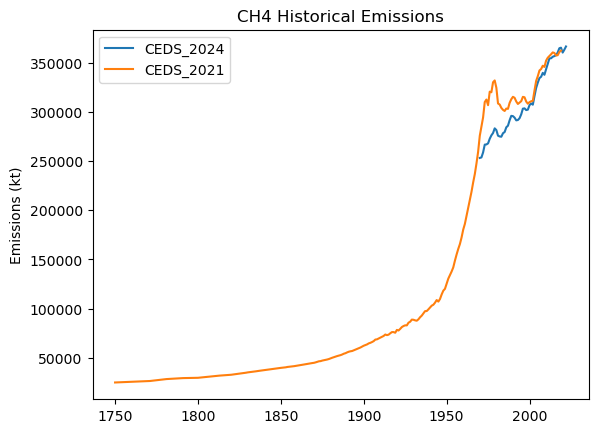

In [2530]:
plt.plot(np.arange(1970,2023,1),ch4c_years_pre.T.sum(axis=1),  label = 'CEDS_2024')
# # plt.plot(np.arange(1970,2020,1),n2o.iloc[:,3:].T.sum(axis=1),  label = 'CEDSi')
# plt.plot(np.arange(1830,2022,1), ch4_j2-50000, label = 'Jones et al 2023') # actual, not adjusted
# plt.plot(np.arange(1850,2040,10), ch4_yy.iloc[0,4:]*1000, label = 'YY')
plt.plot(np.arange(1750,2020,1),ch4_cf.T.sum(axis=1),  label = 'CEDS_2021')
plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('CH4 Historical Emissions')

Text(0.5, 1.0, 'CH4 Historical Emissions')

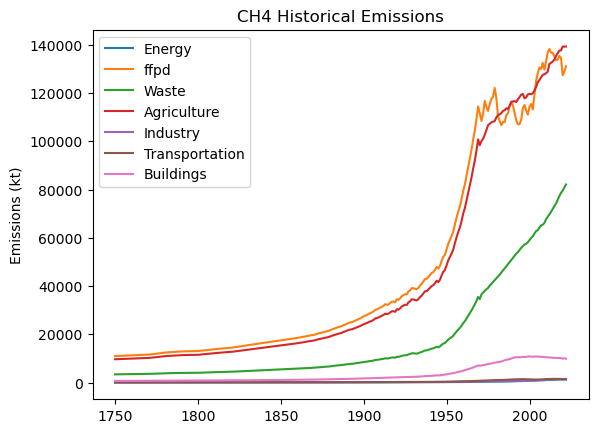

In [2168]:
ch4cc.set_index(ch4_decay_use.index).T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('CH4 Historical Emissions')

Text(0.5, 1.0, 'ch4 Cumulative Historical Emissions')

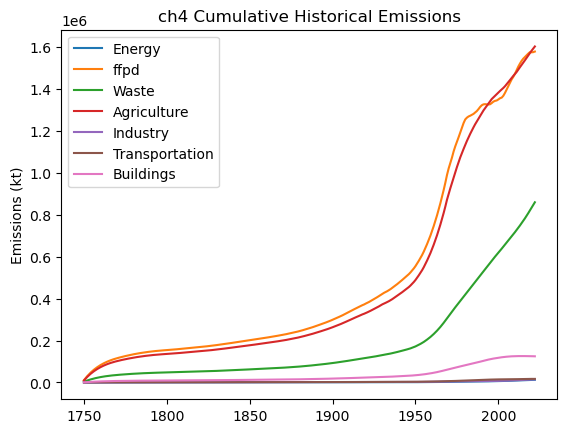

In [2169]:
ch4_hist_decaycl.T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('ch4 Cumulative Historical Emissions')

<Axes: xlabel='sector'>

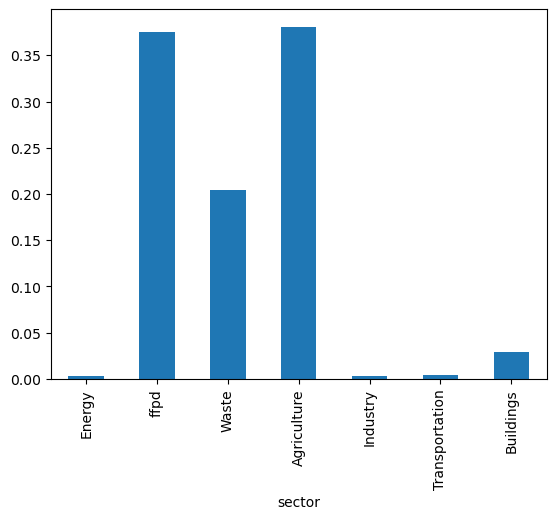

In [2170]:
(ch4_hist_decaycl.T.iloc[-1,:]/ch4_hist_decaycl.T.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

In [2171]:
# sum_and_rename2(pd.read_csv(fl_CEDS[1])).drop(columns = {'em','sector','units'}).set_index('sectors').T.sum()
# ch4_ceds = sum_and_rename2(pd.read_csv(fl_CEDS[1])).drop(columns = {'em','sector','units'}).set_index('sectors')
# years = [int(col.split('X')[1]) for col in ch4_ceds.columns if col.startswith('X')]
# ch4_ceds.columns = years

# ch4_ceds.T.sum(axis=1).plot()

# plt.ylabel('Emissions (kt)')

# plt.legend(loc='upper left')

# plt.title('CH4 Historical Emissions')

<Axes: xlabel='sectors'>

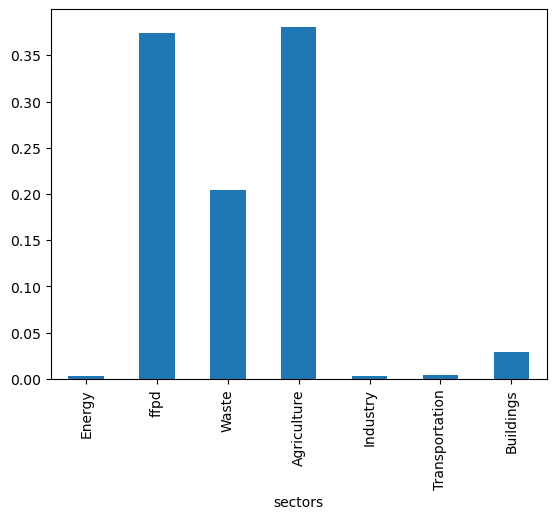

In [2172]:
(ch4_hist_decayc.iloc[:,-1]/ch4_hist_decayc.iloc[:,-1].sum(axis=0)).plot(kind = 'bar')

## SLCF
Generate DataFrame of yearly emissions with no decay function as lifetimes of SLCF or < 1 year

In [2173]:
#slcf
# bcc = sum_and_rename2(pd.read_csv(fl_CEDS[0])).drop(columns = {'em','sector','units'})
# coc = sum_and_rename2(pd.read_csv(fl_CEDS[3])).drop(columns = {'em','sector','units'})
# nh3c = sum_and_rename2(pd.read_csv(fl_CEDS[5])).drop(columns = {'em','sector','units'})
# vocc = sum_and_rename2(pd.read_csv(fl_CEDS[6])).drop(columns = {'em','sector','units'})
# noxc = sum_and_rename2(pd.read_csv(fl_CEDS[7])).drop(columns = {'em','sector','units'})
# occ = sum_and_rename2(pd.read_csv(fl_CEDS[8])).drop(columns = {'em','sector','units'})
# so2c = sum_and_rename2(pd.read_csv(fl_CEDS[9])).drop(columns = {'em','sector','units'})

Text(0.5, 1.0, 'SLCF Historical Emissions')

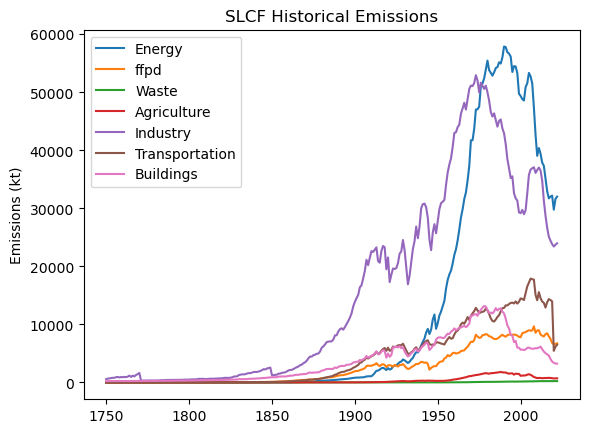

In [2174]:
slcf = so2c.T
slcf.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

# plt.set_xticklabels([int(col.split('X')[1]) for col in slcf.columns if col.startswith('X')])

plt.title('SLCF Historical Emissions')

In [2175]:
# co2c_years_pre
# n2oc_years_pre
# ch4c_years_pre

## Halogenated Compounds (HC)
### aka F-Gas
Data from EDGAR, UNEP, WMO 2022 Report. Utilize AFEAS (2003) and EDGAR for partitioning.

In [2642]:
# Load in Long Lived Climate Forcers
# ch4 = pd.read_excel(r'C:data\EDGAR_CH4_1970_2022\EDGAR_CH4_1970_2022.xlsx','IPCC 2006')
# n2o = pd.read_excel(r'C:data\EDGAR_N2O_1970_2022\EDGAR_N2O_1970_2022.xlsx','IPCC 2006')
# co2 = pd.read_excel(r'C:data\IEA_EDGAR_CO2_1970_2022\IEA_EDGAR_CO2_1970_2022.xlsx','IPCC 2006')
# co2b = pd.read_excel(r'C:data\EDGAR_CO2bio_1970_2022\EDGAR_CO2bio_1970_2022.xlsx','IPCC 2006')
f_gas = pd.read_excel(r'C:data\EDGAR_F-gases_1990-2021\EDGAR_F-gases_1990-2021.xlsx', 'IPCC 2006') # IPCC 2006 sectoR id (1990-2021)
f_gas2 = pd.read_excel(r'C:data\EDGAR_F-gases_1990-2021\EDGAR_F-gases_1990-2021.xlsx', 'IPCC 1996') # IPCC 1996 sectoR id (1990-2021)
f_gas_ar5 = pd.read_excel(r'C:data\EDGAR_AR5_F-gases_1990_2022\EDGAR_AR5_F-gases_1990_2022.xlsx', 'IPCC 2006') # does not include specific substance, only GWP 100
lts = pd.read_excel(r'C:data\lifetimes.xlsx')
lts = lts.rename(columns = {'compound':'Substance'})
ods = pd.read_csv(r'C:data\ozone-depleting-substance-consumption.csv')

In [2643]:
# IPCC 2006 sector id (1990-2021)
fg = f_gas.rename(columns=f_gas.iloc[9]).drop(f_gas.index[0:10]).reset_index(drop=True)
f_sectorfb = fg.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio','Substance']).sum().reset_index()
f_sectorf = f_sectorfb[f_sectorfb.fossil_bio == 'fossil']
f_sectorb = f_sectorfb[f_sectorfb.fossil_bio == 'bio']

# IPCC 1996 sectoR id (1990-2021)
fg2 = f_gas2.rename(columns=f_gas2.iloc[9]).drop(f_gas2.index[0:10]).reset_index(drop=True)
f_sectorfb2 = fg2.groupby(by = ['ipcc_code_1996_for_standard_report_name','fossil_bio','Substance']).sum().reset_index()
f_sectorf2 = f_sectorfb2[f_sectorfb2.fossil_bio == 'fossil']
f_sectorb2 = f_sectorfb2[f_sectorfb2.fossil_bio == 'bio']

In [2644]:
fg['ipcc_code_2006_for_standard_report_name'].unique(), fg2['ipcc_code_1996_for_standard_report_name'].unique()

(array(['Product Uses as Substitutes for Ozone Depleting Substances',
        'Other Product Manufacture and Use', 'Metal Industry',
        'Chemical Industry', 'Electronics Industry'], dtype=object),
 array(['Commerical refrigeration', 'Aerosols', 'Closed cell foam',
        'Other F-gas use', 'Production of metals', 'Electrical Equipment',
        'Production of halocarbons and SF6',
        'Semiconductor/Electronics Manufacture', 'Domestic refrigeration',
        'Industrial refrigeration', 'Transport refrigeration',
        'Mobile Air Conditioning', 'Stationary Air Conditioning',
        'Fire Extinguishers', 'Solvents', 'Other ODS', 'Open cell foam',
        'F-gas as Solvent'], dtype=object))

In [2645]:
fg.ipcc_code_2006_for_standard_report.unique()
fg.Substance.unique()

array(['HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HCFC-141b', 'HCFC-142b',
       'C2F6', 'CF4', 'SF6', 'C3F8', 'C4F10', 'HFC-23', 'c-C4F8',
       'HFC-134', 'HFC-143', 'HFC-236fa', 'HFC-41', 'HFC-43-10-mee',
       'NF3', 'C5F12', 'C6F14'], dtype=object)

In [2646]:
fg2.ipcc_code_1996_for_standard_report.unique()
fg2.Substance.unique() # matches the 2006 for both name and emissions total per year

array(['HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HCFC-141b', 'HCFC-142b',
       'C2F6', 'CF4', 'SF6', 'C3F8', 'C4F10', 'HFC-23', 'c-C4F8',
       'HFC-134', 'HFC-143', 'HFC-236fa', 'HFC-41', 'HFC-43-10-mee',
       'NF3', 'C5F12', 'C6F14'], dtype=object)

In [2647]:
f_hcfc = f_sectorfb[f_sectorfb.Substance.isin(['HCFC-141b', 'HCFC-142b'])]
f_hcfc = f_hcfc.T.iloc[8:,0:].rename(columns = {32:'HCFC-141b', 33:'HCFC-142b'})
# f_hcfc.head()

In [2648]:
# load in data from WMO 2022 report shared by Luke Western, Bristol UK
import glob
import os
import pandas as pd

# the path to your csv file directory
wmo_path = 'data\WMO2022_AGAGE\WMO2022_AGAGE'
# make wmo ods dataframe 
wmo_ods = pd.DataFrame()
# initialize vaiables to track overall min and max years
min_year = float('inf')
max_year = float('-inf')
# iterate through folders in main folder
for compound_folder in os.listdir(wmo_path):
    compounds_folder_path  = os.path.join(wmo_path, compound_folder)

    #check if in directory
    if os.path.isdir(compounds_folder_path):
        output_folder_path = os.path.join(compounds_folder_path, 'outputs')

        #check if 'output' folder exists
        if os.path.exists(output_folder_path):
            #iterate through csv files in the 'output' folder
            for csv_file in os.listdir(output_folder_path):
                if csv_file.endswith('.csv'):
                    csv_file_path = os.path.join(output_folder_path, csv_file)

                    df = pd.read_csv(csv_file_path, skiprows = range (0,12))
                    compound_name = f"{compound_folder}_"
                    # min and max years
                    min_year = df['Year'].min()
                    max_year = df['Year'].max()

                    df.columns = [f"{compound_name}{col}" for col in df.columns]
                    df.set_index(f"{compound_name}Year", inplace = True)
                    #concatenate on common column
                    wmo_ods = pd.concat([wmo_ods, df.iloc[:,2:]], axis=1)

#create common index
com_ind = range (1970, 2021) #ignore any emissions after 2020. These were not published in the ozone assessment and were only preliminary when the files were made.
wmo_ods = wmo_ods.reindex(com_ind)
wmo_ods.columns = [col.split('_')[0] for col in wmo_ods.columns]
wmo_ods.columns = [f"{col}_sigma" if i % 2 != 0 else col for i, col in enumerate (wmo_ods.columns)] # add 'sigma' to the uncertainty (+/-) ['%' is the modulo operator]

# compounds in WMO report (1970-2020) not allocated to emitted sector
set([cols.split('_')[0] for cols in wmo_ods.columns])
# wmo_ods

import scipy
wmo_odsi = wmo_ods.copy()
add_rows = pd.DataFrame({col: [np.nan] * 2 for col in wmo_odsi.columns}, index = range(2021,2023)) #add rows to fill by linear extrapolation
wmo_odsi = pd.concat([wmo_odsi, add_rows])
# wmo_odsi = wmo_odsi.append(add_rows, ignore_index=False)
wmo_odsi.iloc[-8:,:] =wmo_odsi.iloc[-8:,:].interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
wmo_odsi.tail()

,CFC-11,CFC-11_sigma,CFC-113,CFC-113_sigma,CFC-114,CFC-114_sigma,CFC-115,CFC-115_sigma,CFC-12,CFC-12_sigma,...,HFC-236fa,HFC-236fa_sigma,HFC-245fa,HFC-245fa_sigma,HFC-32,HFC-32_sigma,HFC-365mfc,HFC-365mfc_sigma,HFC-4310mee,HFC-4310mee_sigma
2018,74.060985,10.234326,6.952877,5.803309,3.051586,0.926767,1.879363,0.546697,37.319438,20.992701,...,0.379875,0.082227,13.280821,2.041578,57.640280,5.159396,4.447337,0.926870,1.057672,0.316254
2019,50.146834,10.647507,5.961434,5.912160,2.630665,0.888081,1.619408,0.533886,17.235582,21.440230,...,0.384798,0.084202,13.617145,2.183559,65.469685,6.094375,4.373375,0.934955,1.214175,0.337358
2020,48.357969,10.043098,6.851856,5.991660,2.551198,0.882699,1.025666,0.556907,26.740262,21.479277,...,0.386032,0.085597,13.682335,2.297485,70.156393,7.016625,4.315673,0.961070,1.160374,0.335953
2021,46.569104,9.438689,7.742279,6.071160,2.471731,0.877317,0.431924,0.579928,36.244943,21.518325,...,0.387267,0.086992,13.747525,2.411410,74.843102,7.938874,4.257970,0.987185,1.106573,0.334547
2022,44.780239,8.834279,8.632702,6.150660,2.392264,0.871936,-0.161818,0.602949,45.749623,21.557373,...,0.388501,0.088387,13.812715,2.525336,79.529811,8.861124,4.200268,1.013299,1.052772,0.333142


In [2649]:
# ODS EMISSIONS FROM UNEP ARE IN TONNE ODP UNITS ODP = Tonne emission * ozone depeleting potential

odp = {'Substance':['CFC-11', 'CFC-12','CFC-13','CFC-112','CFC-112a','CFC-113','HCFC-22',\
                     'HCFC-141b', 'HCFC-142b','Halon-1211', 'Halon-1301','Halon-2402',\
                    'TCA','MB','CTC'],'odp':[1,0.75,0.3,0.98,0.86,0.82,0.038,0.102,0.057,\
                                             0.32,0.313,0.332,0.12,0.57,0.87]}
odp = pd.DataFrame(data = odp)
ODS = ods[ods.Entity == 'World'].drop(columns = ['Entity','Code'])
ODS = ODS.rename(columns={ODS.columns[1]: 'TCA', ODS.columns[2]: 'MB', ODS.columns[3]: 'HCFC', ODS.columns[4]:\
                          'CTC',ODS.columns[5]: 'Halon',ODS.columns[6]: 'CFC'}).reset_index().drop(columns='index')
# ods.rename(columns={ods.columns[3:8]: 'TCA'})
ODS['Year'] ='Y_' + ODS['Year'].astype(str)
ODS['sector'] = 'Refridgeration/AC/Foam'
ODS = ODS.iloc[2:,:] # we want 1990-2021 that matches w/ the EDGAR f-gas data

#represent the CFC emissions by the 3 main CFCs (by concentration) 0.55/0.35/0.10
ODS['CFC-12'] = ODS.CFC * 0.55
ODS['CFC-11'] = ODS.CFC * 0.35
ODS['CFC-113'] = ODS.CFC * 0.1

#represent the halon emissions by the 3 main halon (by emissions) 0.60/0.30/0.10
ODS['Halon-1211'] = ODS.Halon * 0.6
ODS['Halon-1301'] = ODS.Halon * 0.3
ODS['Halon-2402'] = ODS.Halon * 0.1

#reasonable to assume total HCFC-22 emissions = HCFC total - (HCFC-141b + HCFC-142b)?
matches = dict(zip(odp['Substance'], odp['odp']))

# need to convert emissions of HCFC-141b & 142b to ODP tonnes to extract HCFC-22
f_hcfcb = f_hcfc.copy()*1000
for col in f_hcfcb.columns:
    if col in matches:
        f_hcfcb[col] *= matches[col]

ODS['HCFC-22'] = ODS.HCFC - (f_hcfcb['HCFC-141b']+f_hcfcb['HCFC-142b']).values

# divide out odp to get emissions in tons
for col in ODS.columns:
    if col in matches:
        ODS[col] /= matches[col]
ODS.head()
ODS = ODS.T
ODS.columns = ODS.iloc[0,:]

ODS = ODS.drop(['Year', 'sector'])
ODS = ODS.rename_axis(None, axis=1)
# years = [int(col.split('_')[1]) for col in ODS.columns if col.startswith('Y_')]
# ODS.columns = years
# ODS.head()
ODS['Y_2022'] = pd.Series(dtype='int')
og_columns = ODS.columns
ODS = ODS.T.reset_index(drop=True).apply(pd.to_numeric)
# ODS['CFC-12']/odp.iloc[1,1]
ODSi = ODS.copy()
ODSi.iloc[-8:,:] = ODSi.iloc[-8:,:].interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")
ODS = ODS.T
ODSi = ODSi.T
ODS.columns = og_columns
ODSi.columns = og_columns

In [2650]:
ODSi

,Y_1990,Y_1991,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,Y_1997,Y_1998,Y_1999,...,Y_2013,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022
TCA,139616.666667,298943.333333,472397.500000,317365.000000,118464.166667,128799.158333,24140.000000,19125.000000,14440.832500,17964.998333,...,-212.500000,-50.833333,-186.666667,-261.666667,-390.000000,-343.333333,-313.333333,-269.166667,-180.833333,-92.500000
MB,747.543860,67833.859649,6353.508772,9300.526316,38308.421053,65522.105263,61651.403509,66799.298246,64394.035088,50936.842105,...,2534.385965,1121.754386,566.315789,994.386053,366.315789,-0.701754,20.701760,-25.614035,424.736842,875.087719
HCFC,4636.800300,6968.000000,14613.101000,19307.900000,25047.000000,33001.700000,29207.300000,30324.100000,33560.000000,37242.500000,...,31999.530000,31897.770000,26399.140000,25718.970000,25186.430000,24272.630000,23568.900000,13086.870000,16232.840000,19378.810000
CTC,69787.241379,48806.783908,107080.000000,147144.367816,39855.747126,-12424.255172,1771.954023,-30422.875862,78552.298851,48272.183908,...,-2612.413563,-209.885046,-2126.436782,-3327.816092,-3594.827586,-2743.792989,-418.390805,-2346.091954,1518.735632,5383.563218
Halon,162598.500000,152481.700000,122431.800000,85682.500000,35372.000000,46065.098000,46161.098000,50282.700000,34545.000000,27807.100000,...,-67.300000,-154.099990,-316.800000,-311.800000,-48.600000,-22.800000,-282.700000,-653.399960,-268.600000,116.199960
CFC,732449.200000,615878.700000,566976.600000,489382.300000,358946.780000,285589.780000,177772.200000,175267.900000,163234.200000,149484.200000,...,-1848.700000,-1399.700000,-1493.000000,-1539.800000,-1607.800000,-1154.600000,-1609.900000,-807.000000,-847.900000,-888.800000
CFC-12,537129.413333,451644.380000,415782.840000,358880.353333,263227.638667,209432.505333,130366.280000,128529.793333,119705.080000,109621.746667,...,-1355.713333,-1026.446667,-1094.866667,-1129.186667,-1179.053333,-846.706667,-1180.593333,-591.800000,-621.793333,-651.786667
CFC-11,256357.220000,215557.545000,198441.810000,171283.805000,125631.373000,99956.423000,62220.270000,61343.765000,57131.970000,52319.470000,...,-647.045000,-489.895000,-522.550000,-538.930000,-562.730000,-404.110000,-563.465000,-282.450000,-296.765000,-311.080000
CFC-113,89323.073171,75107.158537,69143.487805,59680.768293,43773.997561,34828.021951,21679.536585,21374.134146,19906.609756,18229.780488,...,-225.451220,-170.695122,-182.073171,-187.780488,-196.073171,-140.804878,-196.329268,-98.414634,-103.402439,-108.390244
Halon-1211,304872.187500,285903.187500,229559.625000,160654.687500,66322.500000,86372.058750,86552.058750,94280.062500,64771.875000,52138.312500,...,-126.187500,-288.937481,-594.000000,-584.625000,-91.125000,-42.750000,-530.062500,-1225.124925,-503.625000,217.874925


In [2651]:
f_sector = f_sectorfb
fd = pd.concat([f_sector.iloc[0:,0:3],f_sector.iloc[0:,8:41]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
f_sector2 = f_sectorfb2
fd2 = pd.concat([f_sector2.iloc[0:,0:3],f_sector2.iloc[0:,8:41]], axis=1).rename(columns = {'ipcc_code_1996_for_standard_report_name':'sectors'})

In [2652]:
fd['Y_2022'] = np.nan
fdi = fd.copy().T.reset_index(drop=True)
fdi.iloc[-8:,:] = fdi.iloc[-8:,:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
# wmo_odsi = wmo_ods.interpolate(method='polynomial', order=2, fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
fdi = fdi.T
fdi.columns = fd.columns
fdi

fd2['Y_2022'] = np.nan
fdi2 = fd2.copy().T.reset_index(drop=True)
fdi2.iloc[-8:,:] = fdi2.iloc[-8:,:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
# wmo_odsi = wmo_ods.interpolate(method='polynomial', order=2, fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
fdi2 = fdi2.T
fdi2.columns = fd.columns
fdi2

,sectors,fossil_bio,Substance,Y_1990,Y_1991,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,...,Y_2013,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022
0,Aerosols,fossil,HFC-134a,0.001367,0.002653,0.15753,0.643113,1.784154,8.587345,10.990198,...,15.923371,16.582881,16.805114,15.446567,14.219954,12.341481,11.898244,10.71547,9.916429,9.117389
1,Aerosols,fossil,HFC-152a,0.011408,1.250612,2.499048,3.683931,4.972305,6.387459,7.839154,...,28.766403,30.34744,31.732051,32.808588,34.198822,35.312753,37.019846,38.402006,39.932972,41.463939
2,Aerosols,fossil,HFC-227ea,0,0,0,0.0,0.000016,0.015414,0.064784,...,2.051082,2.148564,2.24223,2.35144,2.45067,2.580218,2.677873,2.785115,2.899825,3.014534
3,Closed cell foam,fossil,HFC-134a,0,0,0.256216,0.289906,0.298375,0.422005,0.436728,...,5.701914,6.098397,6.54977,6.798449,6.751864,6.872923,6.918941,6.960063,7.011093,7.062123
4,Closed cell foam,fossil,HFC-227ea,0,0,0,0,0,0.000032,0.000025,...,0.059413,0.071053,0.08848,0.098745,0.106024,0.115586,0.114302,0.119488,0.125365,0.131243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Stationary Air Conditioning,fossil,HFC-32,0.000708,0.000957,0.001073,0.001212,0.001357,0.002385,0.005949,...,10.641908,12.711697,14.833001,17.35405,20.207372,23.236536,25.958297,28.826379,32.046775,35.26717
102,Transport refrigeration,fossil,HFC-125,0,0,0,0.004102,0.012323,0.026937,0.045701,...,0.939713,1.027086,1.093037,1.164637,1.226268,1.286183,1.366682,1.43403,1.508381,1.582732
103,Transport refrigeration,fossil,HFC-134a,0.000016,0.000042,0.000231,0.008805,0.023015,0.061912,0.126734,...,1.343734,1.418013,1.446441,1.509053,1.537455,1.566045,1.613833,1.648759,1.691228,1.733697
104,Transport refrigeration,fossil,HFC-143a,0,0,0,0.004847,0.013906,0.030848,0.04933,...,1.028784,1.108918,1.165471,1.232412,1.28913,1.335541,1.397362,1.452345,1.515652,1.57896


In [2654]:
#assign sector to compound based on main use in the literature
ODS2 = ODSi.copy()#.drop(columns = 'sector').T
# ODS2.columns = ODS2.iloc[0]
ODS2 = ODS2.reset_index().rename_axis(None, axis=1).rename(columns = {'index':'Substance'})
ODS2.iloc[:,1:] = ODS2.iloc[:,1:]/1000 # tonnes to kt
ODS2['sectors'] = 'Refridgeration/Foam/AC'
ODS2 = ODS2.iloc[[0,1,3,6,7,8,9,10,11,12],:]

# ODS2.mask(ODS2 < 0, 0)
#assign sector to compound based on main use in the literature
ODS2[ODS2.iloc[:,1:-1] <0] = 0
ODS2['sectors'] = ['Electronics Industry', 'Chemical Industry', 'Chemical Industry', '','','Electronics Industry',\
                   'Electronics Industry', 'Chemical Industry', 'Chemical Industry', 'Refridgeration/Foam/AC']
ODS2

,Substance,Y_1990,Y_1991,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,Y_1997,Y_1998,...,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,sectors
0,TCA,139.616667,298.943333,472.397500,317.365000,118.464167,128.799158,24.140000,19.125000,14.440833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Electronics Industry
1,MB,0.747544,67.833860,6.353509,9.300526,38.308421,65.522105,61.651404,66.799298,64.394035,...,1.121754,0.566316,0.994386,0.366316,0.000000,0.020702,0.000000,0.424737,0.875088,Chemical Industry
3,CTC,69.787241,48.806784,107.080000,147.144368,39.855747,0.000000,1.771954,0.000000,78.552299,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.518736,5.383563,Chemical Industry
6,CFC-12,537.129413,451.644380,415.782840,358.880353,263.227639,209.432505,130.366280,128.529793,119.705080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,
7,CFC-11,256.357220,215.557545,198.441810,171.283805,125.631373,99.956423,62.220270,61.343765,57.131970,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,
8,CFC-113,89.323073,75.107159,69.143488,59.680768,43.773998,34.828022,21.679537,21.374134,19.906610,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Electronics Industry
9,Halon-1211,304.872187,285.903188,229.559625,160.654687,66.322500,86.372059,86.552059,94.280062,64.771875,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217875,Electronics Industry
10,Halon-1301,155.845208,146.148594,117.346773,82.123802,33.902875,44.151851,44.243864,48.194281,33.110224,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111374,Chemical Industry
11,Halon-2402,48.975452,45.928223,36.877048,25.807982,10.654217,13.875030,13.903945,15.145392,10.405120,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035000,Chemical Industry
12,HCFC-22,108.987321,163.277342,350.113881,446.455346,562.769895,737.630255,619.764770,644.027840,711.741156,...,830.904920,686.204131,668.304920,654.290709,630.243341,611.724131,335.881236,418.669920,501.458604,Refridgeration/Foam/AC


In [2655]:
# fd5.iloc[20:40,:]
# fd5[fd5.Substance == 'HFC-125']
# fdi2[fdi2.Substance == 'HFC-365mfc']

In [2656]:
fdi2.sectors.unique()

array(['Aerosols', 'Closed cell foam', 'Commerical refrigeration',
       'Domestic refrigeration', 'Electrical Equipment',
       'F-gas as Solvent', 'Fire Extinguishers',
       'Industrial refrigeration', 'Mobile Air Conditioning',
       'Open cell foam', 'Other F-gas use', 'Other ODS',
       'Production of halocarbons and SF6', 'Production of metals',
       'Semiconductor/Electronics Manufacture', 'Solvents',
       'Stationary Air Conditioning', 'Transport refrigeration'],
      dtype=object)

In [2657]:
#Re-label to get matching sectors for the different f-gas inventories
def label_HC(row):
   if row['Substance'] in (["CFC-11","CFC-115", "CFC-12", "CFC-13", "HCFC-22", 'HFC-365mfc','HCFC-141b','HFC-245fa','HFC-125']):
      return 'Refridgeration/Foam/AC'
   if row['Substance'] in (["CFC-113","CFC-114"]):
      return 'Electronics Industry'
   return row['sectors']

def label_fgas_to_ceds(row):
   if row['sectors'] in (['Aerosols', 'F-gas as Solvent','Other F-gas use', 'Other ODS','Production of halocarbons and SF6', 'Production of metals',\
                         'Semiconductor/Electronics Manufacture','Solvents','Electrical Equipment','Industrial refrigeration']): #uncertain about 'Electrical Equipment'
      return 'Industry'
   if row['sectors'] in (['Closed cell foam','Commerical refrigeration','Domestic refrigeration','Fire Extinguishers','Open cell foam',\
                         'Stationary Air Conditioning']):
      return 'Buildings'
   if row['sectors'] in (['Mobile Air Conditioning','Transport refrigeration']):
      return 'Transportation'
   return row['sectors']

In [2658]:
# wmo_odsi

In [2659]:
wmo_ods2 = wmo_odsi.copy()
wmo_ods2['Year'] = wmo_ods2.index
wmo_ods2['Year'] ='Y_' + wmo_ods2['Year'].astype(str)#.T.drop(columns = 2022)
wmo_ods2 = wmo_ods2.set_index(['Year']).T.reset_index().rename_axis(None, axis=1).rename(columns = {'index':'Substance'})#.drop(columns = 'Y_2022')
wmo_ods2[wmo_ods2.iloc[:,1:-1] <0] = 0
wmo_ods2['sectors'] = 'Refridgeration/Foam/AC'
# wmo_ods2.reset_index().rename(columns = {'index':'Substance'})
# wmo_ods2.set_index('Year')#.T#.reset_index().rename(columns = {'index':'Substance'})
wmo_ods2['Substance'].replace('HFC-4310mee','HFC-43-10-mee', inplace=True) # change name of compound so matches EDGAR
# wmo_ods2 = wmo_ods2.iloc[::2, :]
# [f"{col}_sigma" if i % 2 != 0 else row for i, col in enumerate (wmo_ods.columns)]
# wmo_ods2.sectors = ['Refridgeration/Foam/AC', 'Electronics Industry',]
wmo_ods2['sectors'] = wmo_ods2.apply(label_HC, axis=1)
# fd_years.apply(lambda x: fluod(x), axis=1)
wmo_ods2 = wmo_ods2.iloc[::2, :]
# wmo_ods2

In [2660]:
# wmo_ods2

In [2661]:
# fdi

In [2662]:
fd_use = fdi2 #decide which f-gas sector to use (ie 2006 (fdi) or 1996 code (fdi2))
fd2 = pd.concat([fd_use ,ODS2])
fd3 = fd2.merge(lts, on = 'Substance',how ='left')
y = fd3['lifetime'].to_numpy()
# fd3 = fd2[fd2.Substance.str.contains('HCFC')]
# fd4 = pd.concat([fd,wmo_ods2])

#get unqiue compounds from each of the inventories (EGDAR, WMO, UNEP ODS) and combine
merged_df = pd.merge(fd_use , wmo_ods2, on = 'Substance', how = 'outer', indicator = True) 
edgar_f_keep = np.unique(merged_df[merged_df['_merge'] == 'left_only'].Substance.values)
wmo_only = np.unique(merged_df[merged_df['_merge'] == 'right_only'].Substance.values)
fd_keep = fd_use[fd_use.Substance.isin(edgar_f_keep)]#.drop(fd[fd.Substance == 'HFC-43-10-mee'].index)
fd_match = (fd_use[~fd_use.isin(fd_keep)]).dropna().reset_index(drop = True)

wmo_keep = wmo_ods2[wmo_ods2.Substance.isin(wmo_only)]
wmo_comp = wmo_ods2[~wmo_ods2.Substance.isin(wmo_only)]

fd4 = pd.concat([wmo_ods2,fd_keep])
merged_df2 = pd.merge(fd4, ODS2, on = 'Substance', how = 'outer', indicator = True)

ods_keep = np.unique(merged_df2[merged_df2['_merge'] == 'right_only'].Substance.values)
ods2_keep = ODS2[ODS2.Substance.isin(ods_keep)]

fd4 = pd.concat([fd4,ods2_keep], ignore_index=True)
# cols = fd4.columns
# cols_end = cols[3:35].values
# cols = cols.drop(cols_end)
# fd4 = fd4[np.append(cols,cols_end)] #Create new dataframe with columns in the order you want

fd5 = fd4.merge(lts, on = 'Substance',how ='left')
y = fd5['lifetime'].to_numpy()

In [2663]:
ods2_keep.Substance.unique()

array(['TCA', 'MB', 'CTC', 'Halon-1211', 'Halon-1301', 'Halon-2402'],
      dtype=object)

In [2664]:
# fd5

In [2665]:
### wmo_ods2
# fd5[~fd5.Substance.str.contains('sigma')]
fd5[fd5.Substance.str.contains('HFC-143')]
fd5.Substance.unique()

array(['CFC-11', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-12', 'CFC-13',
       'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HFC-125', 'HFC-134a',
       'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee', 'SF6',
       'C6F14', 'C4F10', 'CF4', 'c-C4F8', 'C2F6', 'C3F8', 'HFC-134',
       'HFC-143', 'HFC-41', 'C5F12', 'NF3', 'TCA', 'MB', 'CTC',
       'Halon-1211', 'Halon-1301', 'Halon-2402'], dtype=object)

In [2668]:
#partition WMO emissions using the EDGAR sectoral fractions for the common compounds
df1 = fd_match.drop(columns = 'fossil_bio')
df2 = wmo_comp
df3 = pd.DataFrame()

for substance in df2['Substance'].unique():
    subset_df2 = df2[df2['Substance'] == substance]
    subset_df1 = df1[df1['Substance'] == substance]
    df1_total_emissions = subset_df1.groupby('Substance').sum()
    df1_frac = pd.DataFrame(index = subset_df1.index)

    for year in df1.columns[2:]:
        if df1_total_emissions[f'{year}'].iloc[0] == 0:
            df1_frac[f'{year}']  = subset_df1[f'{(df1_total_emissions.iloc[:,1:].iloc[0]>0).idxmax()}'] / df1_total_emissions[f'{(df1_total_emissions.iloc[:,1:].iloc[0]>0).idxmax()}'].values
        else:
            df1_frac[f'{year}']  = subset_df1[f'{year}'] / df1_total_emissions[f'{year}'].values
    #partition older years (1970-1989) based on 1990 fractions       
    years = list(range(1970,1990))
    df1_frac_exp = pd.DataFrame(index = df1_frac.index)
    for yr in years:
        df1_frac_exp[f'Y_{yr}'] = df1_frac[f'Y_{Yr}'] if f'Y_{yr}' in df1_frac.columns else df1_frac['Y_1990'].values

    df1_frac = pd.concat([df1_frac_exp, df1_frac], axis = 1)

    df2_part = df1_frac.multiply(np.array(subset_df2.filter(regex='Y_')), axis='columns')
    df2_part['Substance'] = subset_df2.Substance.iloc[0]
    df2_part['sectors'] = subset_df1.sectors
    df3 = pd.concat([df3,df2_part])



In [2669]:
# df3[((df3.Substance.str.contains('HFC-134a')) & (df3['sectors'].isin(duplicate)))]
df3.Substance.unique()

array(['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
       'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee'], dtype=object)

In [2670]:
df3.sectors.unique() 

array(['Other F-gas use', 'Commerical refrigeration',
       'Domestic refrigeration', 'Fire Extinguishers',
       'Industrial refrigeration', 'Mobile Air Conditioning', 'Other ODS',
       'Production of halocarbons and SF6',
       'Semiconductor/Electronics Manufacture', 'Solvents',
       'Stationary Air Conditioning', 'Transport refrigeration',
       'Aerosols', 'Closed cell foam', 'Open cell foam'], dtype=object)

In [2671]:
fdi2.sectors.unique()

array(['Aerosols', 'Closed cell foam', 'Commerical refrigeration',
       'Domestic refrigeration', 'Electrical Equipment',
       'F-gas as Solvent', 'Fire Extinguishers',
       'Industrial refrigeration', 'Mobile Air Conditioning',
       'Open cell foam', 'Other F-gas use', 'Other ODS',
       'Production of halocarbons and SF6', 'Production of metals',
       'Semiconductor/Electronics Manufacture', 'Solvents',
       'Stationary Air Conditioning', 'Transport refrigeration'],
      dtype=object)

In [2672]:
# df3['sectors'] = df3.apply(lambda x: 'Other Transportation' if x.Substance == ('HFC-134a') and x.sectors == 'Product Uses as Substitutes for Ozone Depleting Substances'\
#           else x['sectors'], axis=1) #HFC-134 used as replacement of CFC-12 in mobile AC per WMO 2018 report

# for 2006 sector ID need to partition HFC-134a into both Building and Transportation Categories
# duplicate  = ['Product Uses as Substitutes for Ozone Depleting Substances'] # aerosol and open cell foam used n industry
# df_1 = df3[(df3['sectors'].isin(duplicate)) & (df3.Substance == 'HFC-134a')].assign(sectors = 'Refridgeration/Foam/AC')
# df_12 = df3[(df3['sectors'].isin(duplicate)) & (df3.Substance == 'HFC-134a')].assign(sectors = 'Other Transportation')
# df_1.iloc[:, 0:-2] = df_1.iloc[:, 0:-2]*0.5
# df_12.iloc[:, 0:-2] = df_12.iloc[:, 0:-2]*0.5
# df3 = df3[~((df3.Substance.str.contains('HFC-134a')) & (df3['sectors'].isin(duplicate)))]
# df3 = pd.concat([df3,df_1, df_12])

# for 1996 ID can use the above function to change sector ID [Can just do in sum_and_rename below]
# df3[df3.Substance == 'HFC-134a']

In [2673]:
#load AFEAS data (1931-2000) from https://unfccc.int/gcse?q=afeas
af_cfc12 = pd.read_excel(r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Emerging Carbon Technologies\Research Analyst - Blake\anthro_emissions_mitgation\data\afeas_cfc_12.xlsx')
af_cfc11 = pd.read_excel(r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Emerging Carbon Technologies\Research Analyst - Blake\anthro_emissions_mitgation\data\afeas_cfc_11.xlsx')

In [2674]:
#Retrieve fractions from AFEAS data of CFC-11 and CFC-12
af_cfc11['Substance'] = 'CFC-11'
af_cfc12['Substance'] = 'CFC-12'


def frac_cfc(df):
    cols_per_yr = 18
    subset_dfs = []
    df2 = df.iloc[:,:-1].copy()
    # df2 = df.copy()
    for i in range(0, len(df2.columns), 18):
        subset_df = df2.iloc[:,i:i + 18]
        subset_df.columns = range(subset_df.columns.size)
        subset_dfs.append(subset_df)
    
    cfc = pd.concat(subset_dfs, axis = 0,ignore_index = True)
    cfc.columns = ['Year','Production_annual', 'Released_annual', 'Production_total', 'Released_total', 'Unreleased_total', 'Sales_ref_h',\
                       'Released_ref_h', 'Unreleased_ref_h', 'Sales_ref_nh', 'Released_ref_nh', 'Unreleased_ref_nh', 'Sales_foam_closed',\
                       'Released_foam_closed','Unreleased_foam_closed', 'Sales_foam_open', 'Released_foam_open', 'Unreleased_foam_open']
     # Annual,Total, Refrigeration HERMETIC, Refrigeration NON Hermetic, Blowing Agents Closed Cell Foam, Open Cell Foam Aerosols & Others
    # cfc_12 =  [f"{col}_sigma" if i % 2 != 0 else col for i, col in enumerate (wmo_ods.columns)] # '%' is the modulo operator calc the remainder
    
    #fractions of each use-case from total released
    cfc['ref_h_frac'] = cfc.Released_ref_h / cfc.Released_total # Refrigeration HERMETIC
    cfc['ref_nh_frac'] = cfc.Released_ref_nh / cfc.Released_total # Refrigeration NON Hermetic
    cfc['fc_frac'] = cfc.Released_foam_closed / cfc.Released_total # Closed foam
    cfc['fo_frac'] = cfc.Released_foam_open / cfc.Released_total # Open foam
    #check
    cfc['frac_check'] = cfc.iloc[:,-4:].sum(axis=1)
    
    cfc_2 = cfc.copy()
    cfc_2  = cfc_2.iloc[:, [0] + list(range(-5,-1))]
    cfc_2['Year'] ='Y_' + cfc_2['Year'].astype(str)#.T.drop(columns = 2022)
    cfc_2  = cfc_2.set_index(['Year']).T.reset_index().rename_axis(None, axis=1).rename(columns = {'index':'sectors'})#.drop(columns = 'Y_2022')
    cfc_2['Substance'] = [df.iloc[:,-1].values[0]] * 4
    return cfc_2

In [2675]:
cfc_12_2 = frac_cfc(af_cfc12)
cfc_11_2 = frac_cfc(af_cfc11)
cfc_2 = pd.concat([cfc_11_2, cfc_12_2])

In [2676]:
cfc_2

,sectors,Y_1931,Y_1932,Y_1933,Y_1934,Y_1935,Y_1936,Y_1937,Y_1938,Y_1939,...,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,Y_1997,Y_1998,Y_1999,Y_2000,Substance
0,ref_h_frac,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CFC-11
1,ref_nh_frac,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.00,...,0.076750,0.078294,0.080307,0.082085,0.083528,0.084699,0.085615,0.086259,0.086643,CFC-11
2,fc_frac,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00,...,0.175553,0.186129,0.189413,0.192840,0.196183,0.199477,0.202745,0.205936,0.209067,CFC-11
3,fo_frac,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00,...,0.747697,0.735563,0.730280,0.725076,0.720289,0.715823,0.711640,0.707805,0.704290,CFC-11
0,ref_h_frac,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.00,...,0.008100,0.008474,0.008872,0.009283,0.009718,0.010172,0.010640,0.011123,0.011604,CFC-12
1,ref_nh_frac,0.0,1.0,1.0,1.0,0.875,0.923077,0.904762,0.909091,0.92,...,0.357703,0.367990,0.377614,0.386333,0.393892,0.400062,0.404791,0.408159,0.410423,CFC-12
2,fc_frac,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.00,...,0.050613,0.050487,0.050008,0.049351,0.048689,0.048140,0.047712,0.047392,0.047167,CFC-12
3,fo_frac,0.0,0.0,0.0,0.0,0.125,0.076923,0.095238,0.090909,0.08,...,0.583594,0.573049,0.563496,0.555024,0.547692,0.541617,0.536858,0.533326,0.530806,CFC-12


In [2677]:
#partition WMO emissions using the AFEAS sectoral fractions, for common compounds
df1 = cfc_2
df2 = fd5
df4 = pd.DataFrame()

for substance in df1['Substance'].unique():
    subset_df2 = df2[df2['Substance'] == substance]
    subset_df1 = df1[df1['Substance'] == substance]
    # df1_total_emissions = subset_df1.groupby('Substance').sum()
    # df1_frac = pd.DataFrame(index = subset_df1.index)
    df1_frac = subset_df1 

    years = list(range(1970,2023))
    df1_frac_exp = pd.DataFrame(index = df1_frac.index)
    for yr in years:
        df1_frac_exp[f'Y_{yr}'] = df1_frac[f'Y_{yr}'] if f'Y_{yr}' in df1_frac.columns else df1_frac['Y_2000'].values

    df1_frac = pd.concat([df1_frac.iloc[:,0],df1_frac_exp], axis = 1)

    df2_part = df1_frac_exp.multiply(np.array(subset_df2.filter(regex='Y_')), axis='columns')
    df2_part['Substance'] = subset_df2.Substance.iloc[0]
    df2_part['sectors'] = subset_df1.sectors
    df4 = pd.concat([df4,df2_part])

In [2678]:
df2['Substance'].unique()
df4

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,Substance,sectors
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CFC-11,ref_h_frac
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.933725,15.713662,...,5.663011,5.815266,6.51969,6.416846,4.344859,4.189867,4.034875,3.879882,CFC-11,ref_nh_frac
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.831126,20.414997,...,13.66475,14.032138,15.731901,15.483743,10.484072,10.110078,9.736085,9.362091,CFC-11,fc_frac
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.871533,249.837299,...,46.032717,47.270347,52.996374,52.160396,35.317903,34.058024,32.798145,31.538265,CFC-11,fo_frac
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.233249,2.0824,...,0.392943,0.347865,0.574019,0.433055,0.200002,0.310294,0.420587,0.530879,CFC-12,ref_h_frac
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.028039,105.88472,...,13.898019,12.303658,20.302507,15.316752,7.073877,10.974816,14.875754,18.776692,CFC-12,ref_nh_frac
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.634403,7.793115,...,1.597208,1.413979,2.333234,1.760254,0.812954,1.261263,1.709573,2.157882,CFC-12,fc_frac
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,338.775599,302.922067,...,17.97451,15.9125,26.257527,19.809378,9.148748,14.193889,19.239029,24.284169,CFC-12,fo_frac


In [2679]:
#Reassign sector of CFC-11 and CFC-12 partitioned emissions

duplicated  = ["ref_h_frac"] # all use in commerical buildings
duplicated2  = ["ref_nh_frac"] # unsure about fraciton allocation so 33.33/33.33/33.33 buildings/transportation/industry
duplicated3  = ['fc_frac'] # closed cell foam use in buildings
duplicated4  = ['fo_frac'] # unsure about fraciton allocation so 50/50 aerosol and open cell foam used in industry and in buildings
df_1 = df4[df4['sectors'].isin(duplicated)].assign(sectors = 'Refridgeration/Foam/AC')
df_2 = df4[df4['sectors'].isin(duplicated2)].assign(sectors = 'Refridgeration/Foam/AC')
df_3 = df4[df4['sectors'].isin(duplicated2)].assign(sectors = 'Other Transportation')
df_32 = df4[df4['sectors'].isin(duplicated2)].assign(sectors = 'Other Product Manufacture and Use')
df_4 = df4[df4['sectors'].isin(duplicated3)].assign(sectors = 'Refridgeration/Foam/AC')
df_42 = df4[df4['sectors'].isin(duplicated3)].assign(sectors = 'Buildings')
df_5 = df4[df4['sectors'].isin(duplicated4)].assign(sectors = 'Other Product Manufacture and Use')
# df = df4.append(df1, ignore_index=True)
# df4
df_2.iloc[:, 0:-2] = df_2.iloc[:, 0:-2]*0.3333
df_3.iloc[:, 0:-2] = df_3.iloc[:, 0:-2]*0.3333
df_32.iloc[:, 0:-2] = df_32.iloc[:, 0:-2]*0.3333

df_4.iloc[:, 0:-2] = df_4.iloc[:, 0:-2]*0.5
df_42.iloc[:, 0:-2] = df_42.iloc[:, 0:-2]*0.5

df_6 = pd.concat([df_1, df_2, df_3, df_32, df_4,df_42, df_5])
# df_6

In [2680]:
dfs_list = [df3, fd_keep,  wmo_keep[~wmo_keep.Substance.isin(['CFC-11', 'CFC-12'])], ods2_keep, df_6]
fgas_dfs = pd.concat(dfs_list)
fd6 = fgas_dfs.merge(lts, on = 'Substance',how ='left')
# fd5['sectors'] = fd5.apply(label_HC, axis=1)
# fd6[fd6.Substance.str.contains('HFC-134a')]
# fd5
# fd6


In [2798]:
#fd6.groupby(by = 'Substance').sum().iloc[0:10]#.describe()
#lts[lts.lifetime <1].Substance
# fd6.groupby(by = 'Substance').sum()#.iloc[-5,-4]
# (fd6.groupby(by = 'Substance').sum().iloc[-5,-4]/fd6.groupby(by = 'Substance').sum().iloc[:,-4].sum())*100

In [2685]:
 fd_keep.Substance.unique()

array(['SF6', 'C6F14', 'C4F10', 'CF4', 'c-C4F8', 'C2F6', 'C3F8',
       'HFC-134', 'HFC-143', 'HFC-41', 'C5F12', 'NF3'], dtype=object)

In [2686]:
[df3.Substance.unique(),fd_keep.Substance.unique(), wmo_keep[~wmo_keep.Substance.isin(['CFC-11', 'CFC-12'])].Substance.unique(), ods2_keep.Substance.unique(), df_6.Substance.unique()]

[array(['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
        'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
        'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee'], dtype=object),
 array(['SF6', 'C6F14', 'C4F10', 'CF4', 'c-C4F8', 'C2F6', 'C3F8',
        'HFC-134', 'HFC-143', 'HFC-41', 'C5F12', 'NF3'], dtype=object),
 array(['CFC-113', 'CFC-114', 'CFC-115', 'CFC-13', 'HCFC-22'], dtype=object),
 array(['TCA', 'MB', 'CTC', 'Halon-1211', 'Halon-1301', 'Halon-2402'],
       dtype=object),
 array(['CFC-11', 'CFC-12'], dtype=object)]

In [2687]:
fdi2.Substance.unique()

array(['HFC-134a', 'HFC-152a', 'HFC-227ea', 'HFC-245fa', 'HFC-365mfc',
       'HFC-125', 'HFC-143a', 'HFC-236fa', 'HFC-32', 'SF6', 'C6F14',
       'C4F10', 'CF4', 'HFC-23', 'c-C4F8', 'C2F6', 'C3F8', 'HCFC-141b',
       'HCFC-142b', 'HFC-134', 'HFC-143', 'HFC-41', 'HFC-43-10-mee',
       'C5F12', 'NF3'], dtype=object)

In [2696]:
# F gases decay function
def fluod(x):
    r = x[:-1]
    y = x['lifetime']
    
    d = r * np.exp(-tf/y)
    return d
    
tf = np.arange(0,53,1)

industry = ['Cement production','Chemical Industry', 'Glass Production','Manufacturing Industries and Construction',\
            'Metal Industry','Non-Energy Products from Fuels and Solvent Use','Lime production',\
            'Other Product Manufacture and Use','Electronics Industry',\
            'Product Uses as Substitutes for Ozone Depleting Substances','Other Process Uses of Carbonates', 'Industry',\
            'Aerosols', 'F-gas as Solvent','Other F-gas use', 'Other ODS','Production of halocarbons and SF6', 'Production of metals',\
            'Semiconductor/Electronics Manufacture','Solvents','Electrical Equipment','Industrial refrigeration']
transportation = ['Civil Aviation','Other Transportation','Railways','Road Transportation no resuspension','Water-borne Navigation',\
                 'Road Transportation resuspension', 'Transportation','Mobile Air Conditioning','Transport refrigeration']
burning_biomass = ['Emissions from biomass burning']
power = ['Fossil fuel fires', 'Main Activity Electricity and Heat Production']
fossil_production_distribution = ['Solid Fuels','Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries',\
                                 'Oil and Natural Gas']
waste = ['Incineration and Open Burning of Waste','Biological Treatment of Solid Waste','Solid Waste Disposal',\
        'Wastewater Treatment and Discharge']
agriculture = ['Liming', 'Urea application','Enteric Fermentation','Manure Management','Rice cultivations','Direct N2O Emissions from managed soils',\
              'Indirect N2O Emissions from managed soils','Indirect N2O Emissions from manure management']
buildings = ['Residential and other sectors', 'Refridgeration/Foam/AC', 'Buildings','Closed cell foam','Commerical refrigeration',\
             'Domestic refrigeration','Fire Extinguishers','Open cell foam',\
             'Stationary Air Conditioning']
other = ['Non-Specified','Indirect N2O emissions from the atmospheric deposition of nitrogen in NOx and NH3','Other']
landuse = ['LULUCF']


def sum_and_rename(data):
    industry_sum = data[data.sectors.isin(industry)].sum().to_frame().T
    transportation_sum = data[data.sectors.isin(transportation)].sum().to_frame().T
    burning_biomass_sum = data[data.sectors.isin(burning_biomass)].sum().to_frame().T
    power_sum = data[data.sectors.isin(power)].sum().to_frame().T
    ffpd_sum = data[data.sectors.isin(fossil_production_distribution)].sum().to_frame().T
    waste_sum = data[data.sectors.isin(waste)].sum().to_frame().T
    agriculture_sum = data[data.sectors.isin(agriculture)].sum().to_frame().T
    buildings_sum = data[data.sectors.isin(buildings)].sum().to_frame().T
    other_sum = data[data.sectors.isin(other)].sum().to_frame().T
    lulucf_sum = data[data.sectors.isin(landuse)].sum().to_frame().T
    
    industry_sum['sectors']= 'Industry'
    transportation_sum['sectors'] = 'Transportation'
    burning_biomass_sum['sectors'] = 'Burning'
    power_sum['sectors'] = 'Power'
    ffpd_sum['sectors'] = 'ffpd'
    waste_sum['sectors'] = 'Waste'
    agriculture_sum['sectors'] = 'Agriculture'
    buildings_sum['sectors'] = 'Buildings'
    other_sum['sectors'] = 'Other'
    lulucf_sum['sectors'] = 'LULUCF'
    
    result = pd.concat([industry_sum, transportation_sum, burning_biomass_sum,power_sum, ffpd_sum,waste_sum,\
                       agriculture_sum,buildings_sum,other_sum,lulucf_sum])
    return result

In [2697]:
# sum_and_rename(fd5[fd5.sectors.str.contains('Product')].iloc[:,0:-2].drop(columns = 'Substance')).plot()

In [2794]:
# fd_years 

In [2699]:
# fd.Substance.unique()
fd_years = fd6.drop(columns = ['Substance','sectors', 'fossil_bio']).iloc[0:,:]
fluoro_decayed = fd_years.apply(lambda x: fluod(x), axis=1)
fluoro_decayed['total'] = fluoro_decayed.sum(axis=1)
fluoro_decayed_fraction = fluoro_decayed.iloc[:,0:-1].div(fluoro_decayed.total, axis=0)
# # methane_decayed.sum(axis=1)
fluoro_decayed_fraction['compound'] = fd6['Substance'] #.sum(axis=1)
fluoro_decayed_fraction['sector'] = fd6['sectors'] #.sum(axis=1) 
# carbon_decayed_fraction.set_index('sectors')
fluoro_decayed['compounds'] = fd6['Substance'] 
fluoro_decayed['sectors'] = fd6['sectors']
fluoro_decayed.set_index('sectors')

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,total,compounds
sectors,,,,,,,,,,,,,,,,,,,,,
Other F-gas use,NaN,NaN,NaN,0.783343,0.591360,0.475469,0.420572,0.404275,0.356573,0.312972,...,0.514261,0.451204,0.370508,0.335902,0.318182,0.284290,0.253998,0.226925,45.579981,HCFC-141b
Other F-gas use,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.381983,1.350221,...,2.087445,1.888360,1.727844,1.588614,1.399015,1.169554,0.960808,0.771208,143.411831,HCFC-142b
Commerical refrigeration,NaN,NaN,NaN,0.017517,0.011619,0.021388,0.008407,0.004060,0.012755,0.000000,...,8.650891,9.043893,9.720780,9.808134,9.997106,10.017275,9.996302,9.969976,161.325351,HFC-125
Domestic refrigeration,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012235,0.012296,0.012578,0.012229,0.011988,0.011561,0.011092,0.010655,0.248552,HFC-125
Fire Extinguishers,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.061540,0.064817,0.070233,0.073230,0.074106,0.074946,0.075366,0.075697,1.040270,HFC-125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Refridgeration/Foam/AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.554054,3.595692,...,0.534365,0.468859,0.766796,0.573349,0.262441,0.403547,0.542124,0.678205,147.243591,CFC-12
Buildings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.501642,8.585250,...,2.875676,2.896745,3.185780,3.075805,2.042965,1.932563,1.825625,1.722060,283.370545,CFC-11
Buildings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.554054,3.595692,...,0.534365,0.468859,0.766796,0.573349,0.262441,0.403547,0.542124,0.678205,147.243591,CFC-12


In [2700]:
f_agg_decay = sum_and_rename(fluoro_decayed)
f_agg_decay_fraction =f_agg_decay.iloc[:,0:-2].div(f_agg_decay.total, axis=0)
f_agg_decay_fraction.index = f_agg_decay.sectors
# f_agg_decay_fraction
f_gas_sectors_sum = fluoro_decayed.groupby(by = 'sectors').sum()
# f_gas_sectors_sum.idxmax()
# f_gas_sectors_sum.loc[df[col]. idxmax()]
f_agg_decay

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,total,compounds,sectors
0,0.0,0.0,0.0,1.869935,1.236102,4.172916,4.038603,4.131605,605.549569,549.45331,...,70.101796,83.568226,78.497431,62.327309,65.652356,69.379287,73.5927,14045.975958,HCFC-141bHCFC-142bHFC-125HFC-125HFC-125HFC-125...,Industry
0,0.0,0.0,0.0,0.049908,0.036261,0.02963,0.026607,0.024546,39.957897,36.983472,...,7.320581,8.966563,7.520281,5.221174,5.788427,6.358294,6.937043,1076.469268,HFC-125HFC-125HFC-134aHFC-134aHFC-143aHFC-143a...,Transportation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Burning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Power
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ffpd
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Waste
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Agriculture
0,0.0,0.0,0.0,3.602639,3.225318,3.364398,2.90401,2.711307,127.14506,123.976065,...,49.017163,53.802941,51.539469,46.330928,46.06429,45.807143,45.562399,3792.450665,HFC-125HFC-125HFC-125HFC-125HFC-134aHFC-134aHF...,Buildings
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,LULUCF


In [2768]:
# Calculate Cumulative Decayed Emissions for HC
# if the HC species lifetime <1 do NOT apply decay function

lv = list(fd_years.lifetime.values)
def decay(t, lv):
    return np.exp(-t/lv)

fd_fix_try = fd_years.iloc[:,:-1]
fd_fix_try.columns = np.arange(1970,2023,1)
fd_fix_try = fd_fix_try.fillna(0)
    
cum_emiss = pd.DataFrame(index =fd_fix_try.index)
for year in fd_fix_try.columns[0:]:
    cum_emiss[f'{year}'] =  fd_fix_try.apply(
        lambda row, lv = lv: row[year] if lv[row.name] < 1 else row[year] + sum( # if the HC species lifetime <1 leave as is
            row[:row.index.get_loc(year)][::-1]*[decay(j, lv[row.name]) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )

cum_emiss['sectors'] = fd6.sectors
cum_emiss = cum_emiss.set_index('sectors').reset_index(drop=False)
fd_cumu_r = cum_emiss
fd_cumu_r['Substance'] = fd6.Substance
fd_cumu = sum_and_rename(cum_emiss.set_index('sectors').reset_index(drop=False))
fd_cumu

,sectors,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Substance
0,Industry,0.0,0.0,0.0,5.854338,9.387836,15.129647,20.018382,24.443462,696.584288,...,13981.766399,13933.426494,13889.117325,13864.136513,13831.490426,13771.819288,13714.276799,13662.318284,13618.766817,HCFC-141bHCFC-142bHFC-125HFC-125HFC-125HFC-125...
0,Transportation,0.0,0.0,0.0,0.061835,0.105824,0.140877,0.172009,0.20062,43.536556,...,1609.048378,1638.474727,1666.851089,1696.81129,1720.646904,1737.899753,1753.091231,1766.465382,1778.433909,HFC-125HFC-125HFC-134aHFC-134aHFC-143aHFC-143a...
0,Burning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Power,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,ffpd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Buildings,0.0,0.0,0.0,4.372634,8.10607,11.873109,15.071906,18.012065,202.89709,...,7106.050024,7326.904926,7569.658716,7829.335958,8090.283157,8337.077166,8564.588624,8774.534403,8968.490511,HFC-125HFC-125HFC-125HFC-125HFC-134aHFC-134aHF...
0,Other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,LULUCF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [2769]:
# fd_cumu#_r.groupby(by = 'Substance').sum()

In [2774]:
cum_emiss[cum_emiss.Substance == 'MB'].iloc[:,-2]

112    0.875088
Name: 2022, dtype: float64

In [2775]:
cum_emiss[cum_emiss.Substance == 'MB'].iloc[:,-2]/cum_emiss.iloc[:,-2].sum()

112    0.000036
Name: 2022, dtype: float64

In [2221]:
# fd_cumu.sum()

In [2222]:
# for year in fd_fix_try.columns[0:]:
# #     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)
#       cum_emiss[f'{year}'] =  fd_fix_try.apply(lambda row: row[year] + sum(row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)]), axis=1)
# #     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)
    

In [2337]:
fd6.Substance.unique()

array(['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
       'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee', 'SF6', 'C6F14', 'C4F10',
       'CF4', 'c-C4F8', 'C2F6', 'C3F8', 'HFC-134', 'HFC-143', 'HFC-41',
       'C5F12', 'NF3', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-13',
       'HCFC-22', 'TCA', 'MB', 'CTC', 'Halon-1211', 'Halon-1301',
       'Halon-2402', 'CFC-11', 'CFC-12'], dtype=object)

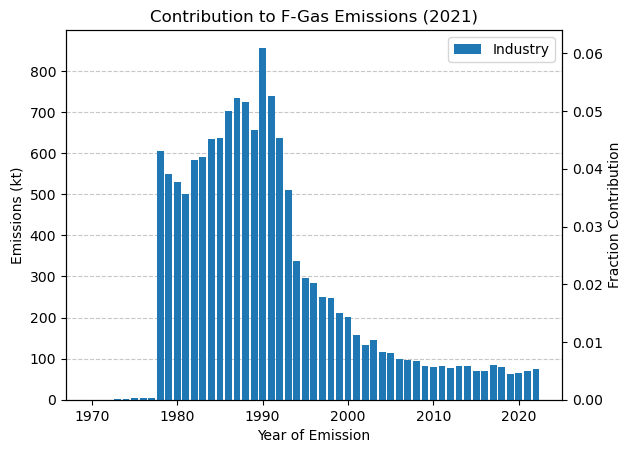

In [2224]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),f_agg_decay.iloc[0,0:-3].values, label  = 'Industry')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to F-Gas Emissions (2021)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),f_agg_decay_fraction.iloc[0,0:-1].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

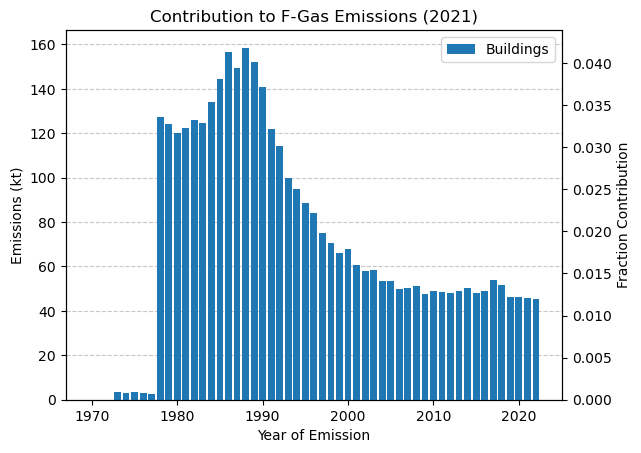

In [2225]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),f_agg_decay.iloc[7,0:-3].values, label  = 'Buildings')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to F-Gas Emissions (2021)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),f_agg_decay_fraction.iloc[7,0:-1].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

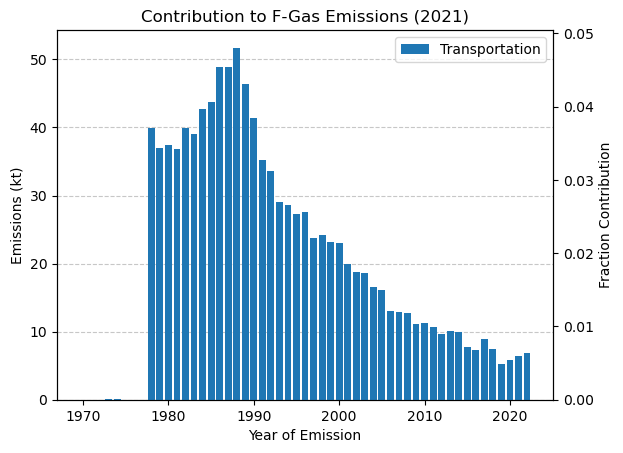

In [2226]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),f_agg_decay.iloc[1,0:-3].values, label  = 'Transportation')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to F-Gas Emissions (2021)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),f_agg_decay_fraction.iloc[1,0:-1].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [2227]:
# inds_f = sum_and_rename(fd6[fd6.sectors.str.contains('Product')].iloc[:,0:-2].drop(columns = 'Substance'))
# inds_f#.iloc[0,:]
# fd6[fd6.Substance == 'HFC-134a'].sum()

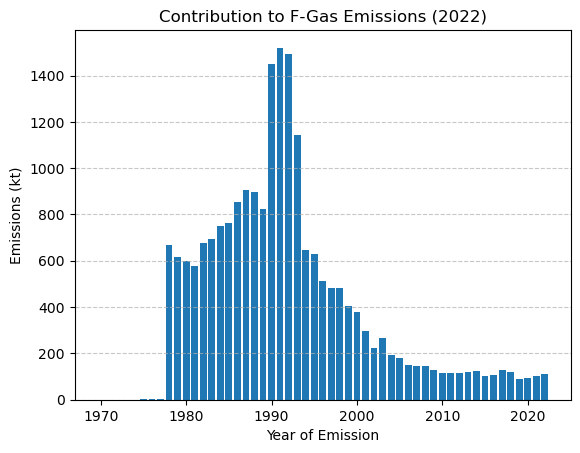

In [2228]:
inds_f = sum_and_rename(fd6[(fd6.sectors.str.contains('|'.join(['Ind','Pro'])))].iloc[:,0:-2].drop(columns = 'Substance'))

fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),inds_f.iloc[0,0:-1].values, label  = 'Product use as replacement for ODS')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to F-Gas Emissions (2022)')
# ax2 = ax1.twinx()
# bar2 = ax2.bar(np.arange(1970,2022,1),f_agg_decay_fraction.iloc[7,0:-1].values) #, label  = 'Emissions (kt)')
# ax2.set_ylabel('Fraction Contribution')
# ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [2229]:
f_agg_decay2 = sum_and_rename(fluoro_decayed).rename(columns={'sectors':'sector'}).drop(columns = 'compounds')
years = [int(col.split('Y_')[1]) for col in f_agg_decay2.columns if col.startswith('Y')] + ['total', 'sector']
f_agg_decay2.columns = years
f_agg_decay2

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2015,2016,2017,2018,2019,2020,2021,2022,total,sector
0,0.0,0.0,0.0,1.869935,1.236102,4.172916,4.038603,4.131605,605.549569,549.45331,...,69.738276,70.101796,83.568226,78.497431,62.327309,65.652356,69.379287,73.5927,14045.975958,Industry
0,0.0,0.0,0.0,0.049908,0.036261,0.02963,0.026607,0.024546,39.957897,36.983472,...,7.819808,7.320581,8.966563,7.520281,5.221174,5.788427,6.358294,6.937043,1076.469268,Transportation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Burning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Power
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ffpd
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Waste
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Agriculture
0,0.0,0.0,0.0,3.602639,3.225318,3.364398,2.90401,2.711307,127.14506,123.976065,...,47.960226,49.017163,53.802941,51.539469,46.330928,46.06429,45.807143,45.562399,3792.450665,Buildings
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LULUCF


In [2230]:
fd6

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,Substance,sectors,fossil_bio,lifetime
0,NaN,NaN,NaN,1.077846,0.90502,0.809338,0.796251,0.851309,0.835142,0.815302,...,54.988309,55.448099,58.418502,58.054826,57.691151,57.327475,HCFC-141b,Other F-gas use,NaN,9.4
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.155373,2.226139,...,23.523162,22.863196,21.284738,18.810217,16.335695,13.861174,HCFC-142b,Other F-gas use,NaN,18.0
2,NaN,NaN,NaN,0.01936,0.013277,0.025267,0.010268,0.005127,0.016653,0.0,...,46.568879,48.580006,51.194339,53.036364,54.719229,56.424954,HFC-125,Commerical refrigeration,NaN,30.0
3,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.060259,0.060573,0.061387,0.061211,0.060718,0.060302,HFC-125,Domestic refrigeration,NaN,30.0
4,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.33646,0.362713,0.37949,0.396799,0.412552,0.428409,HFC-125,Fire Extinguishers,NaN,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.817202,3.896558,...,1.166617,0.880127,0.406477,0.630632,0.854786,1.078941,CFC-12,Refridgeration/Foam/AC,NaN,112.0
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.915563,10.207498,...,7.865951,7.741871,5.242036,5.055039,4.868042,4.681046,CFC-11,Buildings,NaN,52.0
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.817202,3.896558,...,1.166617,0.880127,0.406477,0.630632,0.854786,1.078941,CFC-12,Buildings,NaN,112.0
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.871533,249.837299,...,52.996374,52.160396,35.317903,34.058024,32.798145,31.538265,CFC-11,Other Product Manufacture and Use,NaN,52.0


In [2231]:
# Generate DataFrame of Raw f-gas emissions to save
hc_years_pre = fd6.iloc[:,:-4]
years = [int(col.split('Y_')[1]) for col in hc_years_pre.columns if col.startswith('Y_')]
hc_years_pre.columns = years
hc_years_pre = pd.concat([fd6.iloc[:,-3],hc_years_pre], axis=1)
hc_years_pre = sum_and_rename(hc_years_pre)#.reset_index(drop=True)
hc_years_pre 

,sectors,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Industry,0,0,0,5.854338,5.661352,9.091101,9.038665,9.000246,676.850199,...,278.367423,281.968326,261.746627,264.147876,283.205108,274.610413,246.839303,248.464548,252.542184,259.382831
0,Transportation,0,0,0,0.061835,0.048253,0.042348,0.040843,0.040469,43.349766,...,87.610042,89.203627,86.45342,87.493767,91.118437,86.966878,82.039319,81.376564,80.736656,80.305359
0,Burning,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Power,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,ffpd,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Waste,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Agriculture,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Buildings,0,0,0,4.372634,4.016002,4.251187,3.850885,3.732119,185.79705,...,607.902448,635.067447,643.689422,680.289036,713.773784,732.665665,736.668773,734.984519,732.892908,730.565629
0,Other,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,LULUCF,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Store and Save
Generate DataFrame of LLCF and SLCF for model runs (ie w/ and w/o ffpd)

In [2232]:
#Generate single DataFrame of pre decay LLCFs
cf_tot_pre = {}
cf_tot_pre['co2'] = co2c_years_pre.reset_index()
cf_tot_pre['ch4'] = ch4c_years_pre.reset_index()
cf_tot_pre['n2o'] = n2oc_years_pre.reset_index()
cf_tot_pre['hc'] = hc_years_pre.reset_index(drop=True)

df_cf_tot_pre = pd.concat(cf_tot_pre, axis=1)  # ['CO2'].loc[1752]


cf_tot_pre2 = {}
cf_tot_pre2['co2'] = co2c_years_pre_noffpd.reset_index()
cf_tot_pre2['ch4'] = ch4c_years_pre_noffpd.reset_index()
cf_tot_pre2['n2o'] = n2oc_years_pre_noffpd.reset_index()
cf_tot_pre2['hc'] = hc_years_pre.reset_index(drop=True)

df_cf_tot_pre2 = pd.concat(cf_tot_pre2, axis=1)  # ['CO2'].loc[1752]


In [2233]:
#generate dataframe of cumulative decayed LLCF

cf_tot = {}

add_cols = pd.DataFrame(0, index = f_agg_decay2.index, columns = [i for i in range(1750, 1970)])
# f_agg_decay3 = pd.concat([add_cols,f_agg_decay2], axis=1).set_index('sector').reindex(co2_hist_decayc2.reset_index()['sector'])
f_agg_decay3 = pd.concat([add_cols,fd_cumu], axis=1).set_index('sectors').reindex(co2_hist_decayc.reset_index()['sector'])


cf_tot['co2'] = co2_hist_decayc.reset_index()
cf_tot['ch4'] = ch4_hist_decayclz.reset_index()
cf_tot['n2o'] = n2o_hist_decaycyz.reset_index()
cf_tot['hc'] = f_agg_decay3.iloc[:, list(range(0,273)) + [-1]].reset_index(drop=False).fillna(0)#.reindex(["Z", "C", "A"])

df_cf_tot = pd.concat(cf_tot, axis=1)  # ['CO2'].loc[1752]
df_cf_tot['co2']



,sector,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.493764e+08,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08
1,ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,...,7.202186e+07,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07
2,Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.450119e+05,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05
3,Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329934e+07,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07
4,Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,...,2.461809e+08,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08
5,Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.742855e+08,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08
6,Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,...,1.008350e+08,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08


In [2234]:
df_cf_tot['co2'].sum()

sector    EnergyffpdWasteAgricultureIndustryTransportati...
1750                                            8838.825882
1751                                           17107.636643
1752                                           24914.783806
1753                                           32340.151057
                                ...                        
2018                                       954443448.399318
2019                                       974222808.066863
2020                                       992073866.890779
2021                                      1011803749.319266
2022                                      1031193494.255279
Length: 274, dtype: object

In [2235]:
df_cf_tot_sl = pd.concat(ceds_df_slcf_all, axis=1)

In [2236]:
df_cf_tot_sl['bc']

,sectors,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,total
0,Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,240.161932,243.555638,280.156787,303.825041,324.175992,342.407408,363.240384,404.033374,403.067743,403.067743
1,ffpd,0.067133,0.067273,0.067413,0.067553,0.067693,0.067833,0.067973,0.068113,0.068253,...,513.932947,426.64504,421.460863,413.412887,425.227888,435.42758,439.63235,445.100777,434.743208,434.743208
2,Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007
3,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,280.526555,273.498577,262.058999,277.223557,264.929857,255.505276,238.149937,238.589395,237.834528,237.834528
4,Industry,8.764243,8.787549,8.810955,8.834262,8.857669,8.881077,8.922163,8.94566,8.969158,...,932.362728,906.34775,817.303365,772.125124,749.053528,721.600988,704.254529,701.652557,702.467605,702.467605
5,Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1342.816277,1317.922529,1308.410337,1323.921889,1321.469381,1258.401739,1101.482018,1133.088513,1125.070703,1125.070703
6,Buildings,511.264724,512.522781,513.781557,515.036997,516.293156,517.548005,519.156042,520.408186,521.65902,...,2420.913983,2391.460445,2349.234117,2356.942414,2269.394165,2213.929842,2180.026925,2160.710616,2152.063083,2152.063083


In [2237]:
df_cf_tot['hc']

,sector,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2022
0,Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ffpd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Industry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13983.055122,13934.117107,13889.477441,13864.524584,13831.706562,13771.881212,13714.300472,13662.325066,13618.890450,13618.890450
5,Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1609.048378,1638.474727,1666.851089,1696.811290,1720.646904,1737.899753,1753.091231,1766.465382,1778.433909,1778.433909
6,Buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7106.050024,7326.904926,7569.658716,7829.335958,8090.283157,8337.077166,8564.588624,8774.534403,8968.490511,8968.490511


In [2238]:
co2_hist_decayc#.reset_index()['sector']

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sector,,,,,,,,,,,,,,,,,,,,,
Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.493764e+08,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08
ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,14521.264471,...,7.202186e+07,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07
Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.450119e+05,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05
Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329934e+07,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07
Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,27557.871692,...,2.461809e+08,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08
Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.742855e+08,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08
Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,31928.859256,...,1.008350e+08,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08


### Save Emission Data (with ffpd)

In [2239]:
# # generate files of  emissions for timeseries (- 2022) for LLCF

# # Content: Emissions (metric kilotons) for LLCF (1850-2019) extrapolated to 2022,
# # Other Method: Extrapolation (linear) used 2015-2019 emissions

# template = """\
# README: 
# Content: Emissions (metric kilotons) by sector for LLCF (1850-2022)

# {}"""

# for spec in ['co2','ch4','n2o', 'hc']:
#     with open('data_out/data_out_2024/emissions/present_day/'+ str(spec) +'_emissions_2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(df_cf_tot_pre[spec].to_csv(index = False)))

# # generate files of cumulative decayed emissions (1750-2022) for LLCF

# # Content: Cumulative Decayed Emissions (metric kilotons) by sector for LLCF (1850-2019) extrapolated to 2022,
# # Note: Emissions of CO2 for (1750-2019),
# # Other Method: Extrapolation (linear) used 2015-2019 emissions

# template = """\
# README: 
# Content: Cumulative Decayed Emissions (metric kilotons) by sector for LLCF (1850-2022)

# {}"""

# for spec in ['co2','ch4','n2o','hc']:
#     with open('data_out/data_out_2024/emissions/all_years/'+ str(spec) +'_decay_emission_cumulative_1750-2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(df_cf_tot[spec].to_csv(index = False)))

# # generate files of  emissions (1750-2022) for SLCF

# # Content: CEDS emissions (metric kilotons) by sector for SLCF (1750-2019) extrapolated to 2022,
# # Other Method: Extrapolation (linear) used 2015-2019 emissions
    
# template = """\
# README: 
# Content: CEDS emissions (metric kilotons) by sector for SLCF (1750-2022)

# {}"""

# for spec in ceds_df_slcf_all.keys():
#     with open('data_out/data_out_2024/emissions/all_years/'+ str(spec) +'_emissions_1750-2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(ceds_df_slcf_all[spec].iloc[:,:-1].to_csv(index = False)))

In [2240]:
# generate files of cumulative decayed emissions for present day (2022) for LLCF

# template = """\
# README: 
# Content: Cumulative Decayed Emissions (metric kilotons) for LLCF (1850-2019) extrapolated to 2022,
# Note: Emissions of CO2 for (1750-2019),
# Other Method: Extrapolation (linear) used 2015-2019 emissions

# {}"""

# for spec in ['co2','ch4','n2o','hc']:
#     with open('data_out/emissions/present_day/'+ str(spec) +'_decay_emission_cumulative_2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(df_cf_tot[spec].iloc[:,[0,-2]].to_csv(index = False)))

# #generate files of present day emissions (2022) for SLCF
# template = """\
# README: 
# Content: CEDS emissions (metric kilotons) for SLCF (1750-2019) extrapolated to 2022,
# Other Method: Extrapolation (linear) used 2015-2019 emissions

# {}"""

# for spec in ceds_df_slcf_all.keys():
#     with open('data_out/emissions/present_day/'+ str(spec) +'_emissions_2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(ceds_df_slcf_all[spec].iloc[:,[0,-2]].to_csv(index = False)))

In [2241]:
df_cf_tot['co2']

,sector,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.493764e+08,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08
1,ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,...,7.202186e+07,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07
2,Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.450119e+05,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05
3,Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329934e+07,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07
4,Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,...,2.461809e+08,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08
5,Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.742855e+08,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08
6,Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,...,1.008350e+08,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08


### Save Emission Data (with ffpd separated)

In [2242]:
# #generate files of  emissions for timeseries (- 2022) for LLCF

# # Content: Emissions (metric kilotons) for LLCF (1750-2019) extrapolated to 2022,
# # Note: ffpd separated into other sectors based on IEA final fuel consumption %
# # Other Method: Extrapolation (linear) used 2015-2019 emissions
# template = """\
# README: 
# Content: Emissions (metric kilotons) by sector for LLCF (1750-2022),
# Note: ffpd separated into other sectors based on IEA final fuel consumption %

# {}"""

# for spec in ['co2','ch4','n2o', 'hc']:
#     with open('data_out/data_out_2024/ffpd_sep/emissions/present_day/'+ str(spec) +'_emissions_2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(df_cf_tot_pre2[spec].to_csv(index = False)))

# #generate files of cumulative decayed emissions (1750-2022) for LLCF

# # Content: Cumulative Decayed Emissions (metric kilotons) for LLCF (1750-2019) extrapolated to 2022,
# # Note: ffpd separated into other sectors based on IEA final fuel consumption %
# # Other Method: Extrapolation (linear) used 2015-2019 emissions

# template = """\
# README: 
# Content: Cumulative Decayed Emissions (metric kilotons) by sector for LLCF (1750-2022) 
# Note: ffpd separated into other sectors based on IEA final fuel consumption %

# {}"""

# for spec in ['co2','ch4','n2o','hc']:
#     with open('data_out/data_out_2024/ffpd_sep/emissions/all_years/'+ str(spec) +'_decay_emission_cumulative_1750-2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(df_cf_tot[spec].to_csv(index = False)))

# #generate files of  emissions (1750-2022) for SLCF

# # Content: CEDS emissions (metric kilotons) for SLCF (1750-2019) extrapolated to 2022,
# # Note: ffpd separated into other sectors based on IEA final fuel consumption %
# # Other Method: Extrapolation (linear) used 2015-2019 emissions

# template = """\
# README: 
# Content: CEDS emissions (metric kilotons) by sector for SLCF (1750-2022)
# Note: ffpd separated into other sectors based on IEA final fuel consumption %

# {}"""

# for spec in ceds_df_slcf_all.keys():
#     with open('data_out/data_out_2024/ffpd_sep/emissions/all_years/'+ str(spec) +'_emissions_1750-2022.csv', 'w', newline = '') as fp:
#         fp.write(template.format(ceds_df_slcf_all[spec].iloc[:,:-1].to_csv(index = False)))

# Calculate ERF of each compound
Data and Process from [IPCC AR6 CH6 Fig 12](https://github.com/IPCC-WG1/Chapter-6_Fig12_22_24)

In [2243]:
# Load Historical Effective Radiative Forcing data generated by IPCC AR6 Ch6 team
erf = pd.read_csv(r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Documents\AR6_CH6_RCMIPFIGS\ar6_ch6_rcmipfigs\data_out\fig6_12_ts15_historic_delta_GSAT\hist_ERF_est.csv')

In [2244]:
erf.index = erf.iloc[:,0]
erf.index.name = None
del erf['Unnamed: 0']

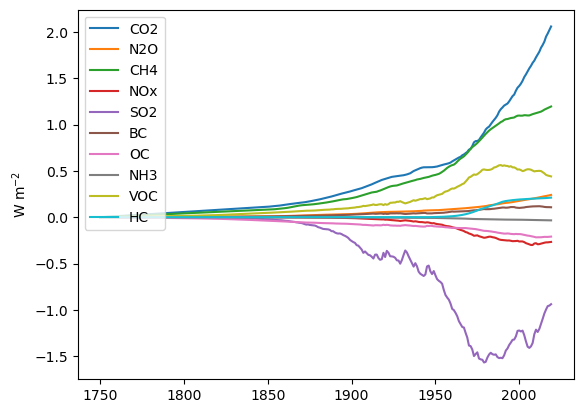

In [2245]:
erf.plot()

plt.ylabel('W m$^{-2}$')

plt.legend(loc='upper left')

In [2246]:
erf.columns = [x.lower() for x in erf.columns]
# erf

In [2247]:
# ERF in 1970, as of 1/25/24 comparing emissions from 1970-2021 (max) so ERF comparison should be erf_1970 and erf_2019 (latest erf available)
# erf_1970 = erf[erf.index == 1970].values
# erf_latest = erf.values[-1]
# erf_use = abs(erf_latest - erf_1970) #ERF change since 1970
# erf_use = pd.DataFrame(data = erf_use)
# erf_use.columns = erf.columns
# erf_use.so2 = erf_use.so2 * -1 #would some of the prev. neg. erfs be pos. if using relative values ?
erf_use = erf

In [2248]:
erf

,co2,n2o,ch4,nox,so2,bc,oc,nh3,voc,hc
1750,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
1751,0.001126,0.000078,0.000824,-0.000001,-0.000055,0.000024,-0.000125,-0.000005,0.000174,0.000000
1752,0.002252,0.000155,0.001647,-0.000002,-0.000095,0.000049,-0.000249,-0.000010,0.000348,0.000000
1753,0.003378,0.000233,0.002471,-0.000003,-0.000130,0.000073,-0.000373,-0.000016,0.000521,0.000000
1754,0.004505,0.000310,0.003294,-0.000004,-0.000167,0.000097,-0.000497,-0.000021,0.000694,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,1.894420,0.225867,1.160556,-0.274934,-1.038115,0.111334,-0.211918,-0.032429,0.473219,0.205775
2016,1.948068,0.229055,1.169129,-0.271339,-0.995462,0.109283,-0.212355,-0.032766,0.456502,0.206995
2017,1.981696,0.232610,1.176556,-0.271009,-0.958711,0.109212,-0.212410,-0.033141,0.449865,0.208398
2018,2.019078,0.237074,1.185527,-0.269076,-0.953242,0.108447,-0.210940,-0.033449,0.444873,0.210010


In [2249]:
# Extraplate to ERFs to 2022
new_rows = pd.DataFrame({col: [np.nan] *3 for col in erf.columns}, index = range(2020, 2023))
erf_use = pd.concat([erf,new_rows], ignore_index=False)
erf_use.iloc[-5:,:] = erf_use.iloc[-5:,:].interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")
erf_use.tail()

,co2,n2o,ch4,nox,so2,bc,oc,nh3,voc,hc
2018,2.019078,0.237074,1.185527,-0.269076,-0.953242,0.108447,-0.210940,-0.033449,0.444873,0.210010
2019,2.057554,0.240569,1.194509,-0.266546,-0.938012,0.107475,-0.209062,-0.033769,0.440334,0.211366
2020,2.096031,0.244064,1.203491,-0.264017,-0.922782,0.106503,-0.207184,-0.034089,0.435796,0.212723
2021,2.134507,0.247558,1.212473,-0.261487,-0.907551,0.105531,-0.205306,-0.034409,0.431257,0.214080
2022,2.172984,0.251053,1.221455,-0.258958,-0.892321,0.104558,-0.203428,-0.034729,0.426718,0.215437


In [2250]:
#calc the erf contribution from each sector to the total compound erf
def frac_con1(df_agent,spec_1,erf_tot):
    frac_con = df_agent[spec_1].total/df_agent[spec_1].total.sum() * erf_tot[spec_1].values[-1]
    return frac_con

def frac_con2(df_agent, spec_sl, spec_erf, erf_tot):
    frac_con = df_agent[spec_sl]/df_agent[spec_sl].sum() * erf_tot[spec_erf].values[-1]
    return frac_con
    
#calc the erf contribution from each sector to the compound erf for each year
def frac_con3(df_agent,spec_1,erf_tot):
    frac_con = (df_agent[spec_1].iloc[:,1:-1]/df_agent[spec_1].iloc[:,1:-1].sum())* pd.DataFrame(erf_tot[spec_1]).T.values
    return frac_con

def frac_con4(df_agent,spec_1,spec_2,erf_tot):
    frac_con = (df_agent[spec_1].iloc[:,1:-1]/df_agent[spec_1].iloc[:,1:-1].sum())* pd.DataFrame(erf_tot[spec_2]).T.values
    return frac_con


In [2251]:
df_cf_tot.keys()

MultiIndex([('co2', 'sector'),
            ('co2',   '1750'),
            ('co2',   '1751'),
            ('co2',   '1752'),
            ('co2',   '1753'),
            ('co2',   '1754'),
            ('co2',   '1755'),
            ('co2',   '1756'),
            ('co2',   '1757'),
            ('co2',   '1758'),
            ...
            ( 'hc',   '2014'),
            ( 'hc',   '2015'),
            ( 'hc',   '2016'),
            ( 'hc',   '2017'),
            ( 'hc',   '2018'),
            ( 'hc',   '2019'),
            ( 'hc',   '2020'),
            ( 'hc',   '2021'),
            ( 'hc',   '2022'),
            ( 'hc',   '2022')],
           length=1097)

In [2252]:
df_cf_tot_sl['co']

,sectors,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,total
0,Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12987.804552,12873.192319,12916.829929,12864.524854,12801.791757,12378.675866,11781.271607,12476.460068,12309.864058,12309.864058
1,ffpd,68.508217,68.5727,68.639419,68.703902,68.770621,68.83734,69.295434,69.362153,69.428872,...,46008.570735,44965.58245,44306.164785,44237.346117,44122.440181,44730.616319,45315.649573,45963.761989,46539.601672,46539.601672
2,Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17053.888992,17047.247678,17048.989127,17041.833211,17044.978599,17047.024551,17043.53013,17056.656213,17056.656213,17056.656213
3,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8531.303043,8872.104179,8505.181043,9177.100684,9265.389569,8043.302675,7369.79805,7114.253883,6915.025657,6915.025657
4,Industry,2857.939471,2867.616959,2877.296924,2886.974413,2896.654381,2906.33435,2916.448336,2926.128451,2935.808568,...,99073.434379,90309.792752,86708.319467,86407.60105,85970.984205,86571.702841,89938.093538,90413.140676,89960.650805,89960.650805
5,Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,113342.835366,113538.906537,106344.806963,103060.034428,100022.640486,95215.23273,81937.601414,83826.166003,80936.164262,80936.164262
6,Buildings,64788.797607,64962.005313,65134.938532,65307.371029,65479.528984,65651.299292,65842.455455,66013.445598,66184.048094,...,207709.61382,204788.212007,198810.748901,195351.057644,187572.846597,180830.774133,175635.338539,172686.284243,171013.069137,171013.069137


In [2253]:
cf_tot = {}

add_cols = pd.DataFrame(0, index = f_agg_decay2.index, columns = [i for i in range(1750, 1970)])
f_agg_decay3 = pd.concat([add_cols,fd_cumu], axis=1).set_index('sectors').reindex(co2_hist_decayc.reset_index()['sector'])
f_agg_decay3['total'] = f_agg_decay3.iloc[:,-1]
f_agg_decay3 = f_agg_decay3.fillna(0)

# co2_hist_decayc2 = co2_hist_decayc.T
co2_hist_decayc['total'] = co2_hist_decayc.iloc[:,-1]
ch4_hist_decayclz['total'] = ch4_hist_decayclz.iloc[:,-1]
n2o_hist_decaycyz['total'] = n2o_hist_decaycyz.iloc[:,-1]

cf_tot['co2'] = co2_hist_decayc.reset_index()
cf_tot['ch4'] = ch4_hist_decayclz.reset_index()
cf_tot['n2o'] = n2o_hist_decaycyz.reset_index()
cf_tot['hc'] = f_agg_decay3.iloc[:, list(range(0,273)) + [-1]].reset_index(drop=False)#.reindex(["Z", "C", "A"])

df_cf_tot = pd.concat(cf_tot, axis=1)  # ['CO2'].loc[1752]
df_cf_tot.columns

# comps = ['co2','ch4','n2o','f','bc','co','voc','so2','nox','nh3','oc']
fracs = {} # calculating erf for final year (2022)
fracs2 = {} # calculating erf for all years

#LLCF Present year (2022) ERF fractions by sector 
for spec in ['co2', 'ch4', 'n2o','hc']:
    frac_con = frac_con1(df_cf_tot,spec,erf_use)
    # print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs[spec] = frac_con

#LLCF All Years (1750 - 2022) ERF fractions by sector 
for spec in ['co2', 'ch4', 'n2o','hc']:
    frac_con = frac_con3(df_cf_tot,spec,erf_use)
    print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs2[spec] = frac_con

#SLCF Present year (2022) ERF fractions by sector 
for spec in ['bc','voc','so2','nox','nh3','oc']:
    frac_con = frac_con2(ceds_df_slcf_tot,spec, spec,erf_use)
    #frac_con = frac_con2(df_slcf_tot,spec, spec,erf_use)
    # print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs[spec] = frac_con

spec = 'co'
frac_con = frac_con2(ceds_df_slcf_tot,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
#frac_con = frac_con2(df_slcf_tot,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
# print(spec)
fracs[spec] = frac_con

#decrease erf of co and voc by half because they share ERF in IPCC, not sure if equivalent contributions tho
fracs['co'] = fracs['co']/2
fracs['voc'] = fracs['voc']/2


#SLCF All Years (1750 - 2022) ERF fractions by sector 
df_cf_tot_sl = pd.concat(ceds_df_slcf_all, axis=1)

for spec in ['bc','voc','so2','nox','nh3','oc']:
    frac_con = frac_con3(df_cf_tot_sl,spec,erf_use)
    #frac_con = frac_con2(df_slcf_tot,spec, spec,erf_use)
    print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs2[spec] = frac_con

spec = 'co'
frac_con = frac_con4(df_cf_tot_sl,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
#frac_con = frac_con2(df_slcf_tot,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
# print(spec)
fracs2[spec] = frac_con

#decrease erf of co and voc by half because they share ERF in IPCC, not sure if equivalent contributions tho
fracs2['co'] = fracs2['co']/2
fracs2['voc'] = fracs2['voc']/2

co2
ch4
n2o
hc
bc
voc
so2
nox
nh3
oc


In [2254]:
# df_cf_tot['co2']

In [2255]:
# Generate table (DataFrame) of present year (2022) erfs
df_spec_sector_erf = pd.concat(fracs, axis=1)  # ['CO2'].loc[1752]
df_spec_sector_erf.index =co2_hist_decayc.index # co2_agg_decay.sectors
df_spec_sector_erf = df_spec_sector_erf.T
# df_spec_sector_erf.rename('sector')
df_spec_sector_erf.index = [x.upper() for x in df_spec_sector_erf.index]
df_spec_sector_erf

sector,Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings
CO2,0.669967,0.178166,0.001768,0.031971,0.605231,0.449473,0.236408
CH4,0.00371,0.457941,0.249364,0.46495,0.004302,0.004967,0.036219
N2O,0.005071,0.000541,0.01157,0.163036,0.053933,0.010825,0.006077
HC,0.0,0.0,0.0,0.0,0.120415,0.015724,0.079297
BC,0.007901,0.008522,0.005459,0.004662,0.013771,0.022055,0.042188
VOC,0.00304,0.05185,0.004448,0.019936,0.070752,0.028284,0.035049
SO2,-0.389104,-0.081971,-0.002857,-0.008703,-0.291336,-0.078928,-0.039421
NOX,-0.050045,-0.008578,-0.005626,-0.020006,-0.038139,-0.12656,-0.010003
NH3,-0.000138,-0.000581,-0.004897,-0.026829,-0.000539,-0.000257,-0.001486
OC,-0.020074,-0.003771,-0.027636,-0.00333,-0.025952,-0.009697,-0.112968


In [2256]:
# Re-order forcer names
index_order = df_spec_sector_erf.index #[::-1].index
index_order

rename_dic_cols = {
    'co2': 'CO$_2$',
    'CO2': 'CO$_2$',
    'CH4': 'CH$_4$',
    'ch4': 'CH$_4$',
    'N2O': 'N$_2$O',
    'n2o': 'N$_2$O',
    'HC': 'CFC + HCFC + HFC',
    'HFCs': 'HFC',
    'NOx': 'NO$_x$',
    'VOC': 'NMVOC + CO',
    'SO2': 'SO$_2$',
    'OC': 'Organic carbon',
    'BC': 'Black carbon',
    'NH3': 'Ammonia'
}

In [2257]:
index_order

Index(['CO2', 'CH4', 'N2O', 'HC', 'BC', 'VOC', 'SO2', 'NOX', 'NH3', 'OC',
       'CO'],
      dtype='object')

In [2258]:
# rn_dic_cat_o = {}
# for key in rename_dic_cat.keys():
#     rn_dic_cat_o[rename_dic_cat[key]]=key
rn_dic_cols_o = {}
for key in rename_dic_cols.keys():
    rn_dic_cols_o[rename_dic_cols[key]]=key

### Generate ERF Figure by Gas-Sector

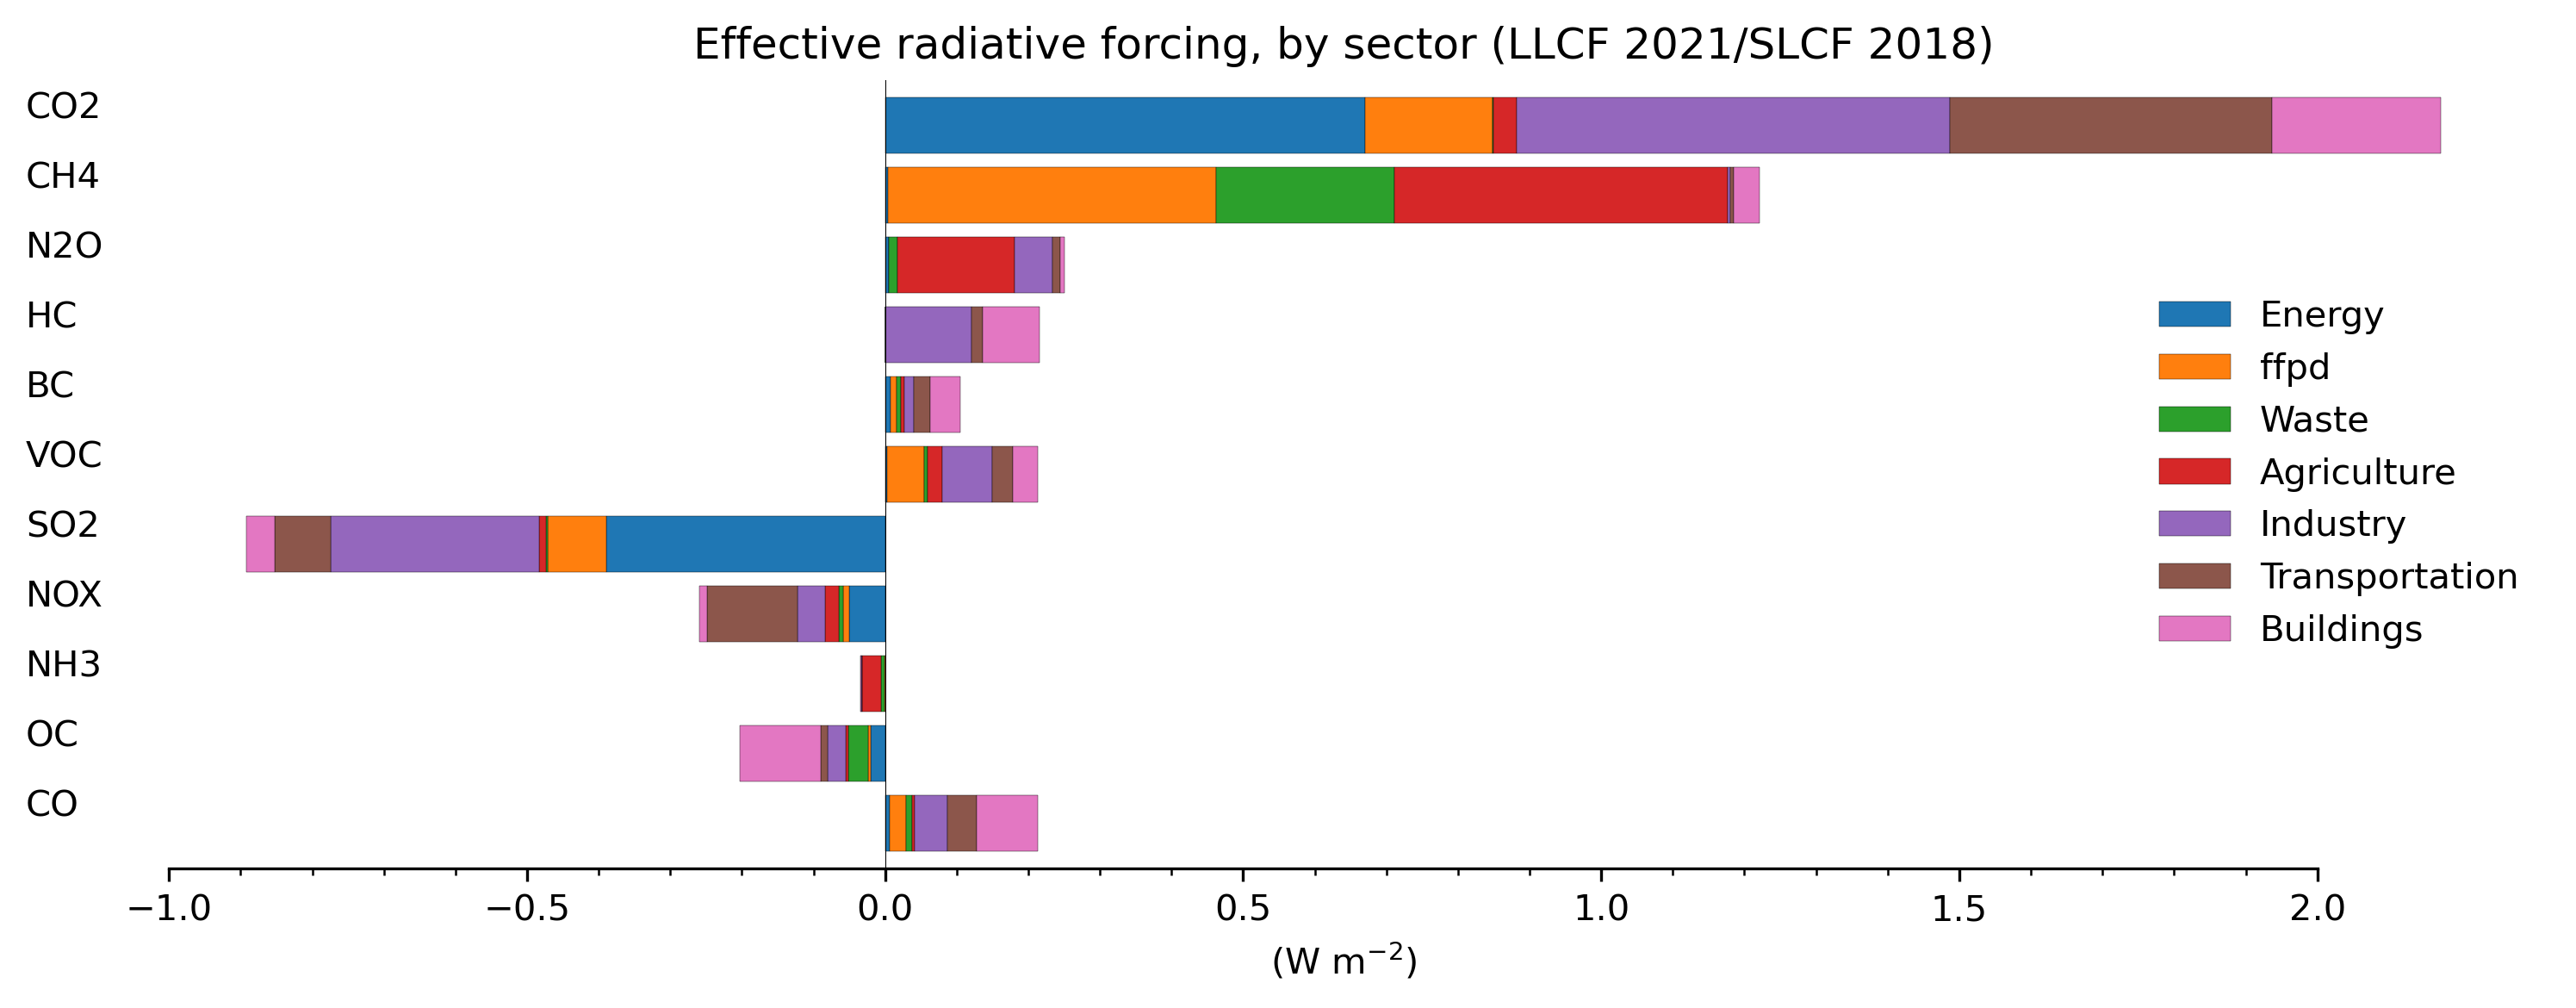

In [2259]:
# Generate Figure of erf by Gas-Sector
import seaborn as sns
ybar = np.arange(len(df_spec_sector_erf) + 1)  # , -1)
sns.set_style()

fig, axs = plt.subplots(1, 1, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}

ax = axs
ax.axvline(x=0., color='k', linewidth=0.25)

df_spec_sector_erf.plot.barh(stacked=True, ax=ax, **kws)#color=col_ls, ax=ax, **kws)
# tab_plt_erf.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = table['Total'][::-1]
# tot = tab_plt_erf.reindex(index_order).sum(axis=1)  # tab_plt

tot = df_spec_sector_erf.sum(axis=1)  # tab_plt
# xerr = df_err['95-50_period'].reindex(index_order)
y = np.arange(len(tot))
# ax.errorbar(tot, y, xerr=xerr, marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

for lab, y in zip(index_order.T, ybar):
    # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
    ax.text(-1.2, y - 0.1, lab, ha='left')  # , va='left')

# for lab, y in zip(index_order2, ybar):
#     # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
#     ax.text(-.75, y - 0.1, lab, ha='left')  # , va='left')
    
ax.set_title('Effective radiative forcing, by sector (LLCF 2021/SLCF 2018)')
ax.set_xlabel(r'(W m$^{-2}$)')
# ax.set_xlim(-1.5, 2.6)
# plt.xlim(-1.6, 2.0)
# sns.despine(fig, left=True, trim=True)
ax.legend(loc='lower right', frameon=False)
ax.set_yticks([])

ax.get_legend().remove()

ax.set_xticks(np.arange(-1, 2.1, .5))
ax.set_xticks(np.arange(-1, 2, .1), minor=True)

# ax = axs[1]
# ax.axvline(x=0., color='k', linewidth=0.25)

# tab_plt_dT.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = tab_plt_dT.reindex(index_order).sum(axis=1)
# # xerr =0# df_err['95-50'][::-1]
# y = np.arange(len(tot))
# xerr_dT = err_dT[['p50-05', 'p95-50']].reindex(index_order).transpose().values
# ax.errorbar(tot, y,
#             xerr=xerr_dT,
#             # xerr=err_dT[['min 1 sigma','plus 1 sigma']].loc[tot.index].transpose().values,
#             marker='d', linestyle='None', color='k', label='Sum', )
# # ax.legend(frameon=False)
# ax.set_ylabel('')

# ax.set_title('Change in GSAT, 1750 to 2019')
# ax.set_xlabel(r'($^{\circ}$C)')
# ax.set_xlim(-1.3, 1.8)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-1., 2.)
ax.legend(loc='right', frameon=False)

# ax.set_xticks(np.arange(-1, 2.1, .5))
# # ax.xaxis.set_major_locator(MultipleLocator(.5))

# ax.set_xticks(np.arange(-1, 1.6, .5))
# ax.set_xticks(np.arange(-1, 1.5, .1), minor=True)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()

# fig.savefig('ERF_Compound_Sector_1750_2022_CEDS.png')
# fig.savefig('ERF_Compound_Sector_1750_2022_CEDS_ffpd_separated.png')
# fig.savefig('ERF_Compound_Sector_ERF1750_2019_EDGAR.png')
# fig.savefig('ERF_Compound_Sector_ERF1970_2019.png')

<Axes: xlabel='sector'>

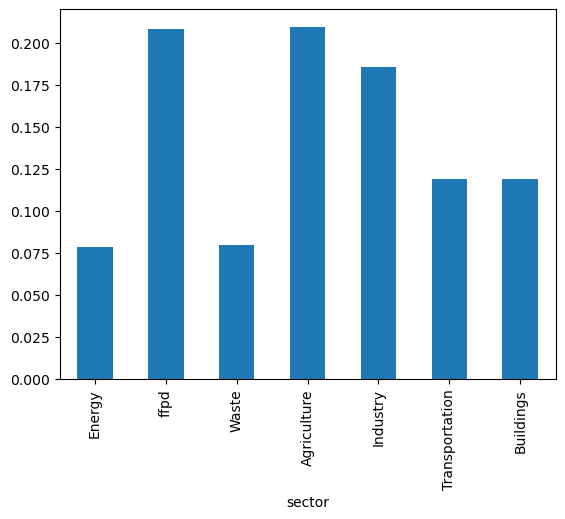

In [2260]:
# Bar chart of ERF fractions by sector
(df_spec_sector_erf.sum(axis=0)/df_spec_sector_erf.sum(axis=0).sum()).plot(kind = 'bar')

### Generate ERF Figure by Sector-Gas

In [2261]:
# Generate table (DataFrame) of present year (2022) erfs

df_spec_sector_erf.T
erf2 = df_spec_sector_erf.T.copy()
erf2['sum'] = erf2.sum(axis=1)
erf2.loc['Total'] = erf2.sum(axis=0)
erf2

,CO2,CH4,N2O,HC,BC,VOC,SO2,NOX,NH3,OC,CO,sum
sector,,,,,,,,,,,,
Energy,0.669967,0.00371,0.005071,0.0,0.007901,0.00304,-0.389104,-0.050045,-0.000138,-0.020074,0.006184,0.236512
ffpd,0.178166,0.457941,0.000541,0.0,0.008522,0.05185,-0.081971,-0.008578,-0.000581,-0.003771,0.023379,0.625499
Waste,0.001768,0.249364,0.01157,0.0,0.005459,0.004448,-0.002857,-0.005626,-0.004897,-0.027636,0.008568,0.24016
Agriculture,0.031971,0.46495,0.163036,0.0,0.004662,0.019936,-0.008703,-0.020006,-0.026829,-0.00333,0.003474,0.629161
Industry,0.605231,0.004302,0.053933,0.120415,0.013771,0.070752,-0.291336,-0.038139,-0.000539,-0.025952,0.045191,0.557627
Transportation,0.449473,0.004967,0.010825,0.015724,0.022055,0.028284,-0.078928,-0.12656,-0.000257,-0.009697,0.040657,0.356544
Buildings,0.236408,0.036219,0.006077,0.079297,0.042188,0.035049,-0.039421,-0.010003,-0.001486,-0.112968,0.085907,0.357266
Total,2.172984,1.221455,0.251053,0.215437,0.104558,0.213359,-0.892321,-0.258958,-0.034729,-0.203428,0.213359,3.002769


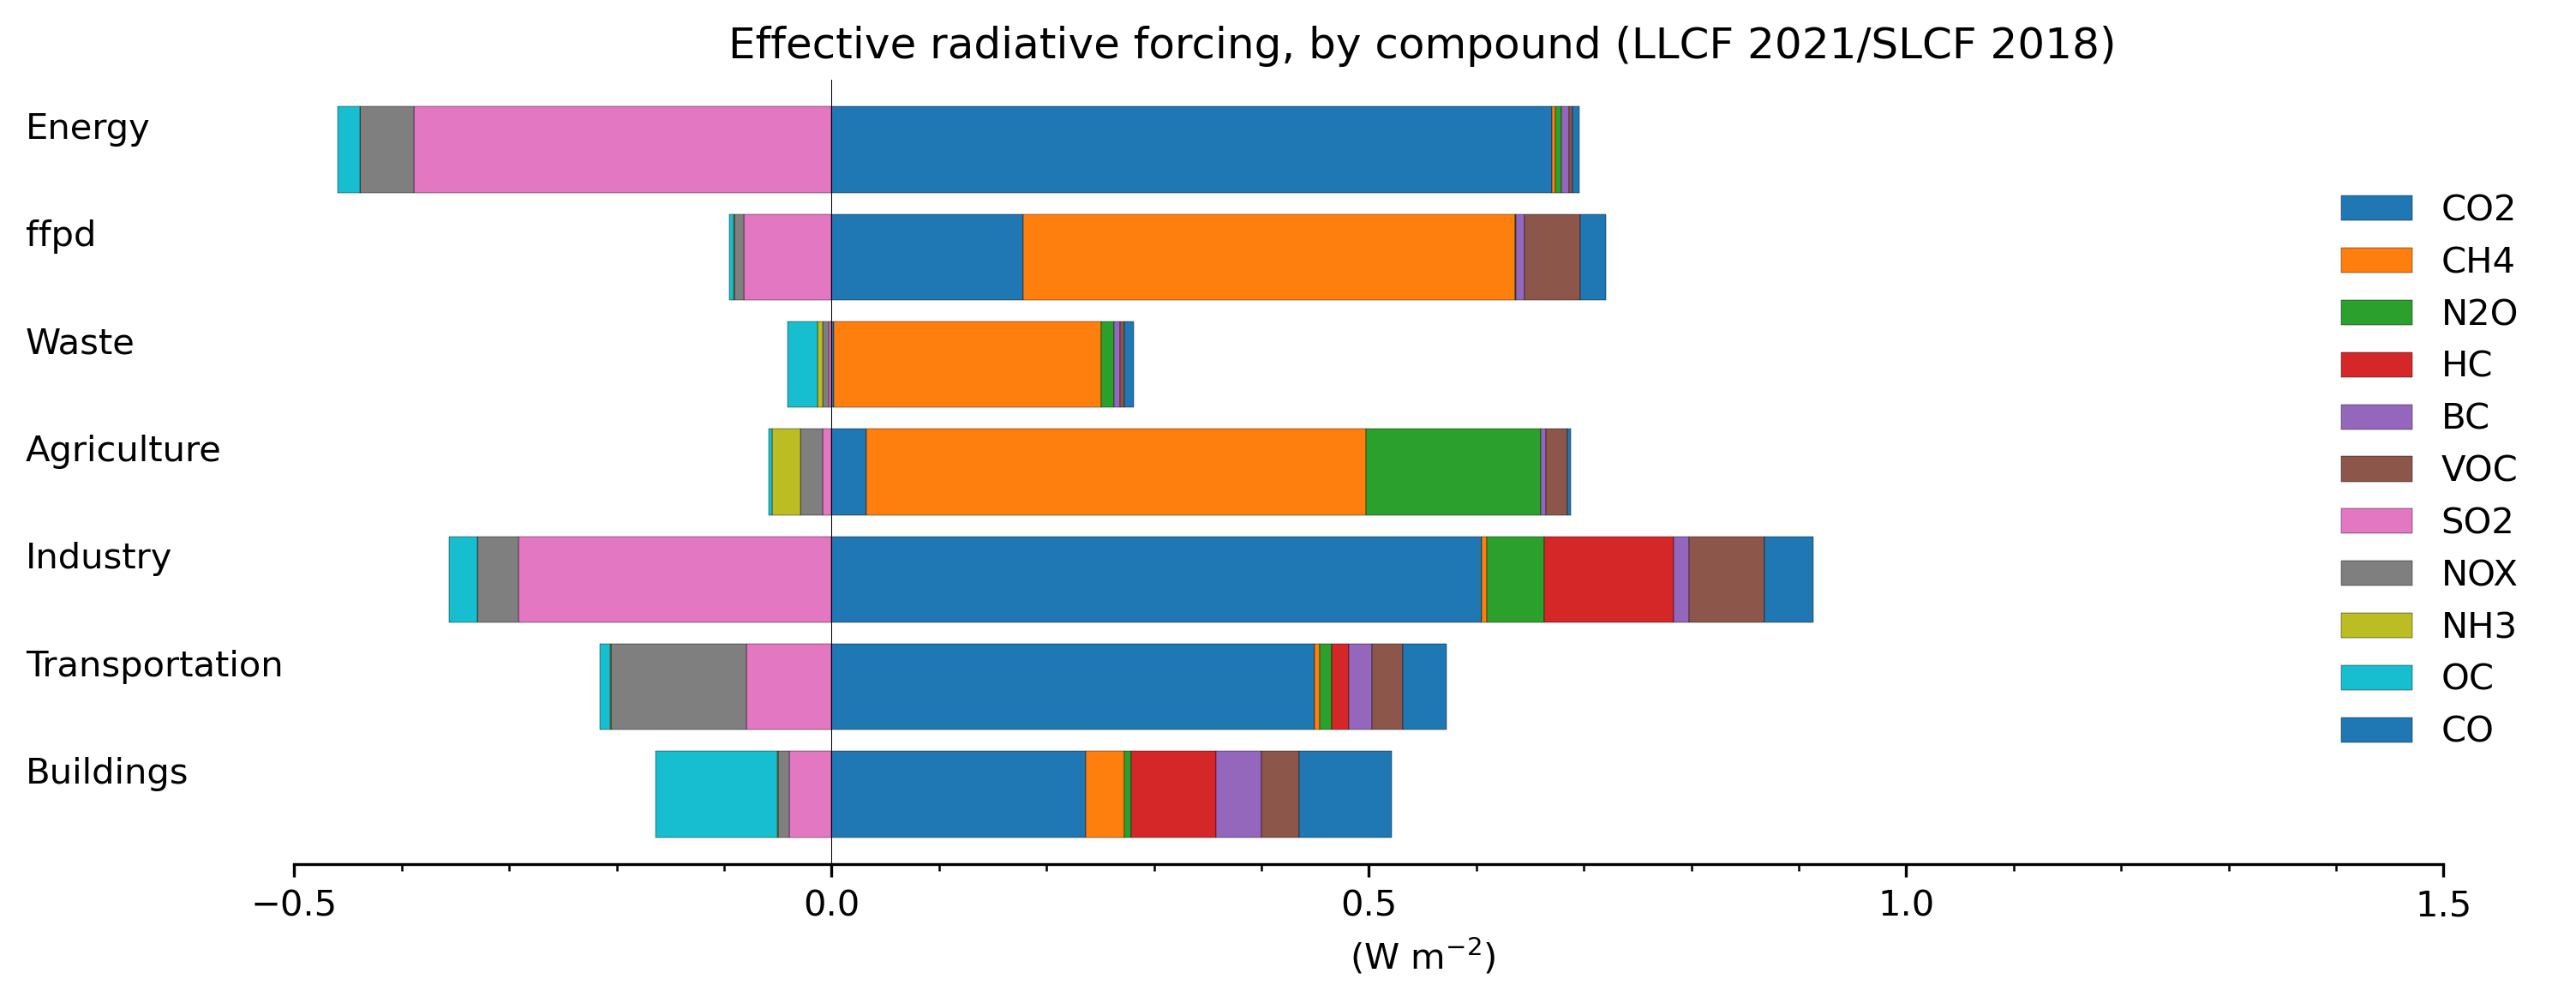

In [2262]:
# Generate Figure of ers by Sector-Gas

index_order2 = df_spec_sector_erf.T.index

sns.set_style()
fig, axs = plt.subplots(1, 1, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}

ax = axs
ax.axvline(x=0., color='k', linewidth=0.25)

df_spec_sector_erf.T.plot.barh(stacked=True, ax=ax, **kws)#color=col_ls, ax=ax, **kws)
# tab_plt_erf.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = table['Total'][::-1]
# tot = tab_plt_erf.reindex(index_order).sum(axis=1)  # tab_plt

tot = df_spec_sector_erf.T.sum(axis=1)  # tab_plt
# xerr = df_err['95-50_period'].reindex(index_order)
y = np.arange(len(tot))
# ax.errorbar(tot, y, xerr=xerr, marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

for lab, y in zip(index_order2, ybar):
    # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
    ax.text(-.75, y - 0.1, lab, ha='left')  # , va='left')
ax.set_title('Effective radiative forcing, by compound (LLCF 2021/SLCF 2018)')
ax.set_xlabel(r'(W m$^{-2}$)')
# ax.set_xlim(-1.5, 2.6)
# plt.xlim(-1.6, 2.0)
# sns.despine(fig, left=True, trim=True)
ax.legend(loc='lower right', frameon=False)
ax.set_yticks([])

ax.get_legend().remove()

ax.set_xticks(np.arange(-.5, 1.6, .5))
ax.set_xticks(np.arange(-.5, 1.5, .1), minor=True)
ax.set_xlim([-.5,1.6])

# ax = axs[1]
# ax.axvline(x=0., color='k', linewidth=0.25)

# tab_plt_dT.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = tab_plt_dT.reindex(index_order).sum(axis=1)
# # xerr =0# df_err['95-50'][::-1]
# y = np.arange(len(tot))
# xerr_dT = err_dT[['p50-05', 'p95-50']].reindex(index_order).transpose().values
# ax.errorbar(tot, y,
#             xerr=xerr_dT,
#             # xerr=err_dT[['min 1 sigma','plus 1 sigma']].loc[tot.index].transpose().values,
#             marker='d', linestyle='None', color='k', label='Sum', )
# # ax.legend(frameon=False)
# ax.set_ylabel('')

# ax.set_title('Change in GSAT, 1750  

# ax.set_xlabel(r'($^{\circ}$C)')
# ax.set_xlim(-1.3, 1.8)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-.5, 1.5)
ax.legend(loc='right', frameon=False)

# ax.set_xticks(np.arange(-1, 2.1, .5))
# # ax.xaxis.set_major_locator(MultipleLocator(.5))

# ax.set_xticks(np.arange(-1, 1.6, .5))
# ax.set_xticks(np.arange(-1, 1.5, .1), minor=True)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()
# fig.savefig('ERF_Sector_Gas_CEDS.png')
# fig.savefig('ERF_Sector_Gas_CEDS_ffpd_separated.png')
# fig.savefig('ERF_Sector_Gas_EDGAR.png')

In [2263]:
 df_spec_sector_erf.T.sum(axis=1) 

sector
Energy            0.236512
ffpd              0.625499
Waste              0.24016
Agriculture       0.629161
Industry          0.557627
Transportation    0.356544
Buildings         0.357266
dtype: object

In [2264]:
 df_spec_sector_erf#.sum(axis=1)

sector,Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings
CO2,0.669967,0.178166,0.001768,0.031971,0.605231,0.449473,0.236408
CH4,0.00371,0.457941,0.249364,0.46495,0.004302,0.004967,0.036219
N2O,0.005071,0.000541,0.01157,0.163036,0.053933,0.010825,0.006077
HC,0.0,0.0,0.0,0.0,0.120415,0.015724,0.079297
BC,0.007901,0.008522,0.005459,0.004662,0.013771,0.022055,0.042188
VOC,0.00304,0.05185,0.004448,0.019936,0.070752,0.028284,0.035049
SO2,-0.389104,-0.081971,-0.002857,-0.008703,-0.291336,-0.078928,-0.039421
NOX,-0.050045,-0.008578,-0.005626,-0.020006,-0.038139,-0.12656,-0.010003
NH3,-0.000138,-0.000581,-0.004897,-0.026829,-0.000539,-0.000257,-0.001486
OC,-0.020074,-0.003771,-0.027636,-0.00333,-0.025952,-0.009697,-0.112968


# Calculate sectoral contribution to del_GSAT
[IPCC AR6 CH6 Fig 12](https://github.com/IPCC-WG1/Chapter-6_Fig12_22_24) \
OpenSCM model dependencies are deprecated so fails, but still require the structure from IPCC to run temperture response (del_T) calculations

In [2265]:
import inspect

import numpy as np
from openscm_units import unit_registry
from scmdata import ScmRun

import openscm_twolayermodel
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel
from openscm_twolayermodel.base import Model

from IPython.display import clear_output

In [2266]:
# NBVAL_IGNORE_OUTPUT
openscm_twolayermodel.__version__

'0.2.3'

In [2267]:
inspect.getmro(ImpulseResponseModel)

(openscm_twolayermodel.impulse_response_model.ImpulseResponseModel,
 openscm_twolayermodel.base.TwoLayerVariant,
 openscm_twolayermodel.base.Model,
 abc.ABC,
 object)

In [2268]:
inspect.getmro(TwoLayerModel)

(openscm_twolayermodel.two_layer_model.TwoLayerModel,
 openscm_twolayermodel.base.TwoLayerVariant,
 openscm_twolayermodel.base.Model,
 abc.ABC,
 object)

In [2269]:
run_length = 200

driver = ScmRun(
    data=np.arange(run_length) * 4 / 70,
    index=1850 + np.arange(run_length),
    columns={
        "unit": "W/m^2",
        "model": "idealised",
        "scenario": "1pctCO2",
        "region": "World",
        "variable": "Effective Radiative Forcing",
    },
)
driver

<ScmRun (timeseries: 1, timepoints: 200)>
Time:
	Start: 1850-01-01T00:00:00
	End: 2049-01-01T00:00:00
Meta:
	       model region scenario   unit                     variable
	0  idealised  World  1pctCO2  W/m^2  Effective Radiative Forcing

In [2270]:
type(driver)

scmdata.run.ScmRun

In [2271]:
# NBVAL_IGNORE_OUTPUT
# driver.lineplot()

In [2272]:
# NBVAL_IGNORE_OUTPUT
# two_layer = TwoLayerModel(lambda0=4 / 3 * unit_registry("W/m^2/delta_degC"))
# res_two_layer = two_layer.run_scenarios(driver)

# impulse_response = ImpulseResponseModel(d1=10 * unit_registry("yr"))
# res_impulse_response = impulse_response.run_scenarios(driver)

# res = res_two_layer.append(res_impulse_response)
# res.head()

In [2273]:
# from openscm_twolayermodel import ImpulseResponseModel  # pip install openscm-twolayermodel
# from openscm_units import unit_registry  # pip install openscm-units
# from scmdata import ScmRun  # pip install scmdata

# from IPython.display import clear_output

In [2274]:
# from ar6_ch6_rcmipfigs.utils.badc_csv 
# import read_csv_badc
# from ar6_ch6_rcmipfigs.constants import RESULTS_DIR, INPUT_DATA_DIR_BADC, OUTPUT_DATA_DIR

In [2275]:
import sys
sys.path.append('utils/badc_csv')

In [2276]:
# %%
def get_header_length(fp):
    """
    Finds the header length in a BADC csv file
    :param fp: file path
    :return:
    """
    cnt_data = 0
    with open(fp) as f:
        line = f.readline()
        cnt = 1
        while line:
            l_sp = line.split(',')
            if l_sp[0].strip() == 'data':
                cnt_data = cnt
                break
            line = f.readline()
            cnt += 1

    return cnt_data

# %%
def read_csv_badc(fp, **kwargs):
    # %%
    if kwargs is None:
        kwargs = {'index_col': 0}
    length_header = get_header_length(fp)
    if 'header' in kwargs.keys():
        hd = kwargs['header']
        if type(hd) is list:
            hd: list
            length_header = list(np.array(hd) + length_header - hd[0])
        del kwargs['header']
    df = pd.read_csv(fp, skipfooter=1, header=length_header, **kwargs, engine='python')
    if df.index[-1] == 'end_data':
        df = df.drop('end_data', axis=0)

    # %%
    return df

In [2277]:
# from anthro_emissions_mitigation.utils import read_csv_badc

In [2278]:
# Load in IRF function constants
fn_IRF_constants = (r'C:data\recommended_irf_from_2xCO2_2021_02_25_222758.csv')

### [Source IPCC AR6] General about computing $\Delta T$:

We compute the change in GSAT temperature ($\Delta T$) from the effective radiative forcing (ERF) from MAGICC?????? (#TODO: check model and reference), by integrating with the impulse response function (IRF(t-t'))

(Geoffroy at al 2013).

For any forcing agent $x$, with estimated ERF$_x$, the change in temperature $\Delta T$ is calculated as:

\begin{align*}
\Delta T_x (t) &= \int_0^t ERF_x(t') IRF(t-t') dt' \\
\end{align*}

#### The Impulse response function (IRF):
In these calculations we use:
\begin{align*}
IRF(t) = \frac{q_1}{d_1} \exp\Big(\frac{-t}{d_1}\Big) + \frac{q_2}{d_2} \exp\Big(\frac{-t}{d_2}\Big)
\end{align*}

Where the constants, $q_i$ and $d_i$ are shown below.


In [2279]:
#irf_consts = pd.read_csv(fn_IRF_constants).set_index('id')
irf_consts = read_csv_badc(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'
irf_consts  # [d1]

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.649789,147.168593,1.31,1.027856,0.880636,3.424102,285.003478,0.443768,0.319591,1.027856,3.0,1.801052,3.93


In [2280]:
# Tune thermal response parameters so that 2019 del_T matches with IPCC AR6 CH6 (~0.95 deg C)
# these adjustments within 1 sigma of average (d1,d2) and d3 in Leach et al., 2021 (https://gmd.copernicus.org/articles/14/3007/2021/)

irf_consts['d1 (yr)'] = 3.424102 + (3.424102*0.8)
irf_consts['d2 (yr)'] = 285.003478 + (285.003478*0.6)

In [2281]:
irf_consts

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.649789,147.168593,1.31,1.027856,0.880636,6.163384,456.005565,0.443768,0.319591,1.027856,3.0,1.801052,3.93


In [2282]:
# lets get the irf values from 0 until i
d1 = float(irf_consts[ld1]) #+ (float(irf_consts[ld1]) * 0.1)
d2 = float(irf_consts[ld2]) #*2#+ (float(irf_consts[ld2]) * 0.2)
q1 = float(irf_consts[lq1])
q2 = float(irf_consts[lq2])
eff = float(irf_consts['efficacy (dimensionless)'])

print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=6.1633835999999995, d2=456.00556479999995, q1=0.443767728883447, q2=0.3195910497425088


In [2283]:
# name of output variable
name_deltaT = 'Delta T'

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'
percentile = 'percentile'

In [2284]:
IRFpercentiles = [recommendation]
# {'ECS = 2K':0.526, 'ECS = 3.4K':0.884, 'ECS = 5K': 1.136 }

In [2285]:
first_y = 1750
last_y = 2022

ref_year = 1750

In [2286]:
# variables to plot:
variables_erf_comp = [
    'CO2', 'N2O', 'CH4', 'HC', 'NOx', 'SO2', 'BC', 'OC', 'NH3'
]
# total ERFs for anthropogenic and total:
variables_erf_tot = []
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = []

In [2287]:
# IRF function
def IRF(t, d1, q1, d2, q2):
    """
    Returns the IRF function for:
    :param q2:
    :param d2:
    :param q1:
    :param d1:
    :param t: Time in years
    :return:
    IRF
    """
    #print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')
    irf = q1 / d1 * np.exp(-t / d1) + q2 / d2 * np.exp(-t / d2)
    return irf
    # l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))

In [2288]:
#import temperture response data from IPCC AR6 Ch6 (fig6_12_ts15_historic_delta_GSAT)
import xarray as xr
dt = xr.open_dataset(r'C:data\dT_data_hist_recommendation.nc')

df_deltaT = dt['Delta T'].squeeze().drop_vars('percentile').to_dataframe().unstack('variable')['Delta T']
# df_deltaT

In [2289]:
# df = pd.read_csv(PATH_DATASET, index_col=0)
erf_use.columns = [x.upper() for x in erf_use.columns]
da_ERF = erf_use.iloc[:-3,:].to_xarray().to_array()#'variable'
da_ERF = da_ERF.rename({'index':'year'})
#ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
ds = xr.Dataset({'ERF':da_ERF})
ds

<xarray.Dataset>
Dimensions:   (year: 270, variable: 10)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
  * variable  (variable) object 'CO2' 'N2O' 'CH4' 'NOX' ... 'NH3' 'VOC' 'HC'
Data variables:
    ERF       (variable, year) float64 0.0 0.001126 0.002252 ... 0.21 0.2114

In [2290]:
# Generate DataFrame of All Climate Forcers sector allocated ERF
cf_erf = {}
for spec in fracs2.keys():
    cf_erf[spec] = fracs2[spec]#
    cf_erf[spec]['sector'] = df_cf_tot['co2'].sector
    cf_erf[spec] = cf_erf[spec].set_index('sector').T.rename_axis(None, axis=1)
    cf_erf[spec].index =cf_erf[spec].index.astype(int)

In [2291]:
# cf_erf

In [2292]:
# Generate DataFrame of ERF for each LLCF
co2_erf = fracs2['co2']#
co2_erf['sector'] = df_cf_tot['co2'].sector
co2_erf = co2_erf.set_index('sector').T.rename_axis(None, axis=1)
co2_erf.index = co2_erf.index.astype(int)
# co2_erf.index
ch4_erf = fracs2['ch4']#
ch4_erf['sector'] = df_cf_tot['ch4'].sector
ch4_erf = ch4_erf.set_index('sector').T.rename_axis(None, axis=1)
ch4_erf.index = ch4_erf.index.astype(int)

n2o_erf = fracs2['n2o']#
n2o_erf['sector'] = df_cf_tot['n2o'].sector
n2o_erf = n2o_erf.set_index('sector').T.rename_axis(None, axis=1)
n2o_erf.index = n2o_erf.index.astype(int)

hc_erf = fracs2['hc']#
hc_erf['sector'] = df_cf_tot['hc'].sector
hc_erf = hc_erf.set_index('sector').T.rename_axis(None, axis=1)
hc_erf.index = hc_erf.index.astype(int)
# hc_erf

In [2293]:
#build xarray for each climate forcer/species (spec) to run through IRF

ds_specs = {}
for spec in fracs2.keys():
    cf_erf[spec] = fracs2[spec]#
    cf_erf[spec]['sector'] = df_cf_tot['co2'].sector
    cf_erf[spec] = cf_erf[spec].set_index('sector').T.rename_axis(None, axis=1)
    cf_erf[spec].index =cf_erf[spec].index.astype(int)
    da_ERF = cf_erf[spec].to_xarray().to_array()#'variable'
    da_ERF = da_ERF.rename({'index':'year'})
    ds_specs[spec] = xr.Dataset({'ERF':da_ERF})
    ds_specs[spec]['ERF'] = ds_specs[spec].ERF.astype('float')
    ds_specs[spec]['time'] = pd.to_datetime(ds_specs[spec]['year'].to_pandas().index.map(str), format='%Y')
    ds_specs[spec]['delta_t'] = xr.DataArray(np.ones(len(ds_specs[spec]['year'])), dims='year', coords={'year': ds_specs[spec]['year']})

In [2294]:
#Example
# ds_specs['ch4']['year']

In [2295]:
# [OLD] Generate xarray of climate forcer/species ERF
# da_ERF = co2_erf.to_xarray().to_array()#'variable'
# da_ERF = da_ERF.rename({'index':'year'})
# #ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
# ds_co2 = xr.Dataset({'ERF':da_ERF})
# ds_co2['ERF'] = ds_co2.ERF.astype('float')

# da_ERF = ch4_erf.to_xarray().to_array()#'variable'
# da_ERF = da_ERF.rename({'index':'year'})
# #ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
# ds_ch4 = xr.Dataset({'ERF':da_ERF})
# ds_ch4['ERF'] = ds_ch4.ERF.astype('float')

# da_ERF = n2o_erf.to_xarray().to_array()#'variable'
# da_ERF = da_ERF.rename({'index':'year'})
# #ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
# ds_n2o = xr.Dataset({'ERF':da_ERF})
# ds_n2o['ERF'] = ds_n2o.ERF.astype('float')

# da_ERF = hc_erf.to_xarray().to_array()#'variable'
# da_ERF = da_ERF.rename({'index':'year'})
# #ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
# ds_hc = xr.Dataset({'ERF':da_ERF})
# ds_hc['ERF'] = ds_hc.ERF.astype('float')


In [2296]:
# [OLD] Generate xarray of climate forcer/species del_T

ds['time'] = pd.to_datetime(ds['year'].to_pandas().index.map(str), format='%Y')
# delta_t is 1 (year)
ds['delta_t'] = xr.DataArray(np.ones(len(ds['year'])), dims='year', coords={'year': ds['year']})

# ds_co2['time'] = pd.to_datetime(ds_co2['year'].to_pandas().index.map(str), format='%Y')
# ds_co2['delta_t'] = xr.DataArray(np.ones(len(ds_co2['year'])), dims='year', coords={'year': ds_co2['year']})

# ds_ch4['time'] = pd.to_datetime(ds_ch4['year'].to_pandas().index.map(str), format='%Y')
# ds_ch4['delta_t'] = xr.DataArray(np.ones(len(ds_ch4['year'])), dims='year', coords={'year': ds_ch4['year']})

# ds_n2o['time'] = pd.to_datetime(ds_n2o['year'].to_pandas().index.map(str), format='%Y')
# ds_n2o['delta_t'] = xr.DataArray(np.ones(len(ds_n2o['year'])), dims='year', coords={'year': ds_n2o['year']})

# ds_hc['time'] = pd.to_datetime(ds_hc['year'].to_pandas().index.map(str), format='%Y')
# ds_hc['delta_t'] = xr.DataArray(np.ones(len(ds_hc['year'])), dims='year', coords={'year': ds_hc['year']})


In [2297]:
# ds_co2

In [2298]:
ds2 = ds.copy()

### [Source: IPCC AR6 Ch6] Integrate and compute $\Delta T$:
The code below integrates the read in ERFs with the pre defined impulse response function (IRF).

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

In [2299]:
def integrate_(i, _var, _nvar, ds_in: xr.Dataset, ds_DT, irf_cnst: dict):
    """

    :param i:
    :param _var:
    :param _nvar:
    :param ds_in:
    :param ds_DT:
    :param irf_cnst: dictionary
    :return:
    """
    #print('_var',_var)
    #print('_nvar',_nvar)
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds_in[{'year': slice(0, i + 1)}].copy()
    #print(ds_short)
    # lets get the current year
    current_year = ds_short['year'][{'year': i}]  # .dt.year
    # lets get a list of years
    _years = ds_short['year']  # .dt.year
    # lets get the year delta until current year(i)
    ds_short['end_year_delta'] = current_year - _years

    # lets get the irf values from 0 until i
    d1 = irf_cnst[ld1]
    d2 = irf_cnst[ld2] #+ (irf_cnst[ld2] * 0.2)
    q1 = irf_cnst[lq1]
    q2 = irf_cnst[lq2]

    ds_short['irf'] = IRF(
        ds_short['end_year_delta'] * ds_short['delta_t'], d1, q1, d2, q2)

    # lets do the famous integral
    ds_short['to_integrate'] = \
        ds_short[_var] * \
        ds_short['irf'] * \
        ds_short['delta_t']

    # lets sum all the values up until i and set
    # this value at ds_DT
    # If whole array is null, set value to nan
    if np.all(ds_short['to_integrate'].isnull()):  # or last_null:
        _val = np.nan
    else:
        # 

        _ds_int = ds_short['to_integrate'].sum(['year'])
        # mask where last value is null (in order to not get intgral 
        _ds_m1 = ds_short['to_integrate'].isel(year=-1)
        # where no forcing data)
        _val = _ds_int.where(_ds_m1.notnull())
    # set value in dataframe:
    ds_DT[_nvar][{'year': i}] = _val


def integrate_to_dT(_ds, from_t, to_t, irf_cnsts, int_var='ERF'):
    """
    Integrate forcing to temperature change.

    :param _ds: dataset containing the forcings
    :param from_t: start year
    :param to_t: end year
    :param int_var: variables to integrate
    :param irf_cnsts: irf constants
    :return:
    """
    # slice dataset
    ds_sl = _ds.sel(year=slice(from_t, to_t))
    len_time = len(ds_sl['year'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    namevar = name_deltaT
    # set all values to zero for results dataarray:
    ds_DT[namevar] = ds_DT[int_var] * 0
    # Units Kelvin:
    ds_DT[namevar].attrs['unit'] = 'K'
    if 'unit' in ds_DT[namevar].coords:
        ds_DT[namevar].coords['unit'] = 'K'

    for i in range(len_time):
        # da = ds[var]
        if (i % 20) == 0:
            print('%s of %s done' % (i, len_time))
        integrate_(i, int_var, namevar, ds_sl, ds_DT, irf_cnsts)
    clear_output()
    # fn = 'DT_%s-%s.nc' % (from_t, to_t)
    #fname = OUTPUT_DATA_DIR/ fn#'DT_%s-%s.nc' % (from_t, to_t)
    # save dataset.
    #ds_DT.to_netcdf(fname)
    return ds_DT

In [2300]:
def calc_dGSAT(var, ds, ds_out, scenario='scenario'):
    s_y = int(ds.isel(year=0)['year'].values)
    _erf_tmp = ds['ERF'].sel(variable=var).to_pandas()
    unit = "W/m^2"

    driver = ScmRun(
    
        data=_erf_tmp,
        index=s_y + np.arange(len(_erf_tmp)),
        columns={
            "unit": unit,
            "model": "custom",
            "scenario": scenario,
            "region": "World",
            "variable": "Effective Radiative Forcing",
        },
    )

    impulse_res = ImpulseResponseModel(
        d1=d1 * unit_registry("yr"),
        d2=d2 * unit_registry("yr"),
        q1=q1* unit_registry("delta_degC / (W / m^2)"),
        q2=q2* unit_registry("delta_degC / (W / m^2)"),
        efficacy=eff* unit_registry("dimensionless"),
    )
    dt_tmp = impulse_res.run_scenarios(driver)


    df_tmp= dt_tmp.filter(variable='Surface Temperature').timeseries()#.lineplot()#['Surface']
    #_ds_dT[var] =df_tmp.transpose()
    
    #ds_out[var]  = 
    df_tmp = df_tmp.reset_index().iloc[:,12:].transpose().rename({0:var}, axis=1)#.to_xarray()
    year_index = pd.to_datetime(df_tmp.index).year
    df_tmp['year'] = year_index
    df_tmp = df_tmp.set_index('year')

    ds_out[var] = df_tmp.to_xarray()[var]

    return ds_out

In [2301]:
def calc_GSAT_all_vars(_ds, ds_out, variables=None, scenario='scenario'):
    

    if variables is None:
        variables =_ds['variable'].values
    

    _ds_dT = xr.Dataset()
    for var in variables:
        print(var)
        _ds_dT = calc_dGSAT(var, _ds, _ds_dT, scenario=scenario)
        print()
    # ds_DT = np.array(_ds_dT, name=name_deltaT) #.to_array(name=name_deltaT)
    ds_DT = _ds_dT.toarray(name=name_deltaT)

    #ds_out[name_deltaT] = ds_DT
    

    return ds_DT

In [2302]:
def calc_GSAT_all_scenarios(ds, ds_out, scenarios_l = None):
    

    scenarios_l = None
    if scenarios_l is None:
        scenarios_l = ds[scenario].values
    _ds_dT = xr.Dataset()
    _ds_out = xr.Dataset()
    for scn in scenarios_l:
        print(scn)
        ds_scn = calc_GSAT_all_vars(ds.sel(scenario = scn), _ds_dT, scenario=scn)
        ds_scn = ds_scn.rename(scn)
        _ds_out[scn] = ds_scn
    ds_DT = _ds_out.to_array(dim=scenario, name=name_deltaT)
    ds_out[name_deltaT] = ds_DT
    

    return ds_out

In [2303]:
# [OLD] Generate dictionary of integrated CFs producing del_T
dic_ds_old = {}
check_irf = {}
for key in IRFpercentiles:
    dic_ds_old[key] = integrate_to_dT(ds, first_y, last_y, irf_consts.loc[key], int_var='ERF')
    # check_irf[key] = irf_consts.loc[key]

In [2304]:
# irf_consts.loc[key]

In [2305]:
# dic_ds_old

In [2306]:
# [OLD] Generate dictionary of integrated CFs for each sector producing del_T 
# dic_ds_old_co2 = {}
# dic_ds_old_ch4 = {}
# dic_ds_old_n2o = {}
# dic_ds_old_hc = {}
# for key in IRFpercentiles:
#     dic_ds_old_co2[key] = integrate_to_dT(ds_co2, first_y, last_y, irf_consts.loc[key], int_var='ERF')
#     dic_ds_old_ch4[key] = integrate_to_dT(ds_ch4, first_y, last_y, irf_consts.loc[key], int_var='ERF')
#     dic_ds_old_n2o[key] = integrate_to_dT(ds_n2o, first_y, last_y, irf_consts.loc[key], int_var='ERF')
#     dic_ds_old_hc[key] = integrate_to_dT(ds_hc, first_y, last_y, irf_consts.loc[key], int_var='ERF')



In [2307]:
 # dic_ds_old_co2

In [2308]:
# [OLD] Generate dictionary of integrated CFs for each sector producing del_T
dic_ds_cfs = {}
for spec in ds_specs:
    for key in IRFpercentiles:
        dic_ds_cfs[spec,key] = integrate_to_dT(ds_specs[spec], first_y, last_y, irf_consts.loc[key], int_var='ERF')
dic_ds_cfs#['co2']

{('co2',
  'recommendation'): <xarray.Dataset>
 Dimensions:   (year: 273, variable: 7)
 Coordinates:
   * year      (year) int32 1750 1751 1752 1753 1754 ... 2018 2019 2020 2021 2022
   * variable  (variable) object 'Energy' 'ffpd' ... 'Transportation' 'Buildings'
 Data variables:
     ERF       (variable, year) float64 0.0 0.0 0.0 0.0 ... 0.2318 0.2341 0.2364
     time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2022-01-01
     delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
     Delta T   (variable, year) float64 0.0 0.0 0.0 0.0 ... 0.1174 0.1186 0.1198,
 ('ch4',
  'recommendation'): <xarray.Dataset>
 Dimensions:   (year: 273, variable: 7)
 Coordinates:
   * year      (year) int32 1750 1751 1752 1753 1754 ... 2018 2019 2020 2021 2022
   * variable  (variable) object 'Energy' 'ffpd' ... 'Transportation' 'Buildings'
 Data variables:
     ERF       (variable, year) float64 0.0 1.015e-06 ... 0.03627 0.03622
     time      (year) datetime64[ns] 1750-0

In [2309]:
# irf_consts.loc['recommendation']

In [2310]:
# for key in IRFpercentiles:
#     print(irf_consts.loc[key])

In [2311]:
ds['variable'].values

array(['CO2', 'N2O', 'CH4', 'NOX', 'SO2', 'BC', 'OC', 'NH3', 'VOC', 'HC'],
      dtype=object)

In [2312]:
# dic_ds = {}
# for key in IRFpercentiles:
#     ds_out = ds.copy(deep=True)

#     ds_out[name_deltaT]= calc_GSAT_all_vars(ds,ds_out)
#     dic_ds[key] = ds_out

In [2313]:
# ds#['delta_t']#[{'year': i}]  # .dt.year

In [2314]:
# #check
# for per in IRFpercentiles:
#     dic_ds[per].isel( variable=0)[name_deltaT].plot()

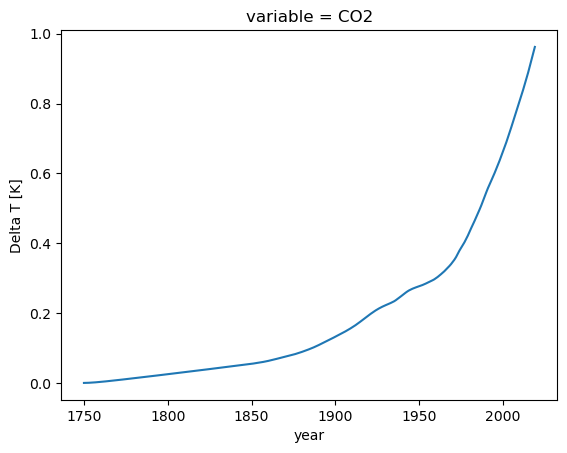

In [2315]:
#check
for per in IRFpercentiles:
     dic_ds_old[per].isel( variable=0)[name_deltaT].plot()

In [2316]:
# for per in IRFpercentiles:
#      dic_ds_old_co2[per].isel( variable=0)[name_deltaT].plot(label = 'energy')
     # dic_ds_old_co2[per].isel( variable=1)[name_deltaT].plot(label = 'ffpd')

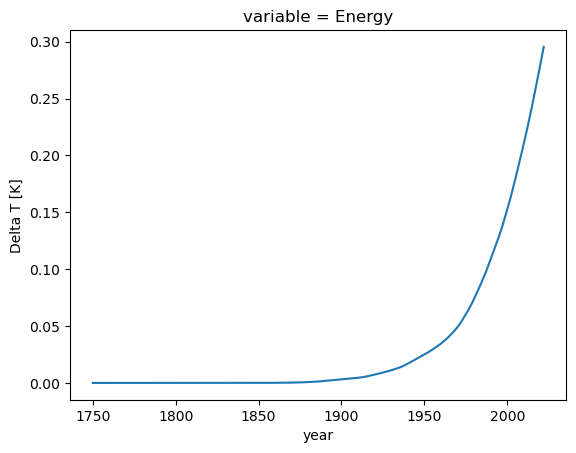

In [2317]:
for per in IRFpercentiles:
     dic_ds_cfs['co2',per].isel( variable=0)[name_deltaT].plot(label = 'energy')

In [2318]:
#dataset with percentile as dimension

In [2319]:
# ds_tmp = xr.Dataset(coords=dic_ds[recommendation].coords)
# ds_tmp
# for key in IRFpercentiles:
#     ds_tmp[key] = dic_ds[key]['Delta T']  # .dims,dic_ds[key],)
# ds['Delta T'] = ds_tmp.to_array('percentile')

In [2320]:
# [OLD] Convert xarray values into percentile
# ds_tmp_old = xr.Dataset(coords=dic_ds_old[recommendation].coords)
# ds_tmp_old
# for key in IRFpercentiles:
#     ds_tmp_old[key] = dic_ds_old[key]['Delta T']  # .dims,dic_ds[key],)
# ds2['Delta T'] = ds_tmp_old.to_array('percentile')

In [2321]:
# [OLD] temperture to percentiles
# ds_tmp_old_co2 = xr.Dataset(coords=dic_ds_old_co2[recommendation].coords)
# ds_tmp_old_ch4 = xr.Dataset(coords=dic_ds_old_ch4[recommendation].coords)
# ds_tmp_old_n2o = xr.Dataset(coords=dic_ds_old_n2o[recommendation].coords)
# ds_tmp_old_hc = xr.Dataset(coords=dic_ds_old_hc[recommendation].coords)

# for key in IRFpercentiles:
#     ds_tmp_old_co2[key] = dic_ds_old_co2[key]['Delta T']  # .dims,dic_ds[key],)
#     ds_tmp_old_ch4[key] = dic_ds_old_ch4[key]['Delta T']
#     ds_tmp_old_n2o[key] = dic_ds_old_n2o[key]['Delta T']
#     ds_tmp_old_hc[key] = dic_ds_old_hc[key]['Delta T']
# ds_co2['Delta T'] = ds_tmp_old_co2.to_array('percentile')
# ds_ch4['Delta T'] = ds_tmp_old_ch4.to_array('percentile')
# ds_n2o['Delta T'] = ds_tmp_old_n2o.to_array('percentile')
# ds_hc['Delta T'] = ds_tmp_old_hc.to_array('percentile')

In [2322]:
# temperture xarray to percentiles
ds_tmp = {}
for spec in ds_specs:
    for key in IRFpercentiles:
        ds_tmp[spec] = xr.Dataset(coords=dic_ds_cfs[spec,key].coords)
        ds_tmp[spec][key] = dic_ds_cfs[spec, key]['Delta T']
        ds_specs[spec]['Delta T'] = ds_tmp[spec].to_array('percentile')

    
    # ds_specs[spec]['Delta T'] = dic_ds_cfs[spec]['Delta T'].to_array('percentile')

 # dic_ds_cfs[spec,key]

In [2323]:
# ds_co2['Delta T'].sel(percentile='recommendation')
ds_specs.keys()

dict_keys(['co2', 'ch4', 'n2o', 'hc', 'bc', 'voc', 'so2', 'nox', 'nh3', 'oc', 'co'])

In [2324]:
# Generate dictionary of DataFrames containing del_T for all years, climate forcers/species (spec), and sectors
ds_dt = {} # all del_T (1750-2022)
ds_dt_2022 ={} # present day del_T (2022)
for spec in ds_specs.keys():
    ds_dt[spec] = ds_specs[spec]['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
    # Get values for latest year (2022)
    ds_dt_2022[spec] =  ds_dt[spec].iloc[-1,:]
ds_dt_ = ds_dt.copy()

#generate dictionary of dataframes containing relative contributions of each species/sector to overall del_temp for that year and 21st century (2000-2022)
ds_dt_2 = {} # del_T (2000-2022) by gas
ds_dt_3 = {} # del_T (2000-2022) by year
ds_dt_tot = {} # total annual temp change
ds_dt_4 = {} # trend in del_T relative to total for each year
ds_dt_4_ind = {} # trend in del_T compared to each climate forcers/species (spec)

for spec in ds_dt_.keys():
    ds_dt_2[spec] = ds_dt_[spec].iloc[-23:,:] 
    ds_dt_2[spec] = ds_dt_2[spec].fillna(0)
    for i in np.arange(2000,2023,1):
        ds_dt_yr = []
        for key,df in ds_dt_2.items():
            year_row = df.loc[df.index == i]
            ds_dt_yr.append(year_row)
        ds_dt_3[i] = pd.concat(ds_dt_yr, axis=0, keys = ds_dt_2.keys())#.drop(columns = 'year')
        ds_dt_3[i]['species sum del_T'] = ds_dt_3[i].sum(axis=1)
        ds_dt_3[i].loc['sector sum del_T'] = ds_dt_3[i].sum(axis=0)
        ds_dt_tot[i] = ds_dt_3[i].loc['sector sum del_T','species sum del_T']
        ds_dt_4[i] = ds_dt_3[i].iloc[:-1,:-1].div(ds_dt_3[i].iloc[-1,-1])
        ds_dt_4_ind[i] = ds_dt_3[i].iloc[:-1,:-1].div(ds_dt_3[i].iloc[:-1,-1].values, axis =0) # each cell relative to species total
        ds_dt_4[i]['rel sum compound'] = ds_dt_4[i].sum(axis=1)
        ds_dt_4[i].loc['rel sum sector'] = ds_dt_4[i].sum(axis=0)


# calc trend in rel contribution to temp by species/sector for time period (2000-2022)
from scipy.stats import linregress
dt_rel = {}
for spec in ds_dt_4.keys():
    dt_rel[spec] = ds_dt_4[spec].iloc[:-1,:-1]
    dt_rel[spec].index = [i[0] for i in dt_rel[spec].index]

#build dataframe to store slope of linear regression (trend)
dt_trend = pd.DataFrame(index = dt_rel[2000].index, columns =  dt_rel[2000].columns)

#grab the unique cell for each relative year dataframe (2000-2022), store, and perform linear regression
for row in dt_trend.index:
    for col in dt_trend.columns:
        y = [df.at[row,col] for df in dt_rel.values()]
        x = np.arange(1, len(y) +1)

        slope, intercept, r_value, p_value, std_err = linregress(x,y)

        dt_trend.at[row, col] = slope

# sum of species and sector trends (2000-2022)
dt_trend['species sum trend_rel_del_T'] = dt_trend.sum(axis=1)
dt_trend.loc['sector sum trend_rel_del_T'] = dt_trend.sum(axis=0)


In [2389]:
#Present year (2022) climate forcer temp. effect by sector
ds_dt_3[2022]#.iloc[-1,:-1] / ds_dt_3[2022].iloc[-1,-1]

variable,Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings,species sum del_T
"(co2, 2022)",0.295460,0.085699,0.000694,0.015199,0.295487,0.206459,0.119840,1.018838
"(ch4, 2022)",0.001656,0.239511,0.119887,0.238406,0.001939,0.002519,0.019202,0.623120
"(n2o, 2022)",0.002107,0.000261,0.005316,0.077161,0.027173,0.005305,0.003025,0.120348
"(hc, 2022)",0.000000,0.000000,0.000000,0.000000,0.063544,0.007382,0.034681,0.105607
"(bc, 2022)",0.002984,0.005084,0.002614,0.002627,0.007795,0.012340,0.024793,0.058238
"(voc, 2022)",0.001388,0.027910,0.002438,0.010621,0.036495,0.021119,0.024078,0.124049
"(so2, 2022)",-0.222365,-0.047605,-0.001371,-0.005153,-0.184321,-0.070951,-0.031567,-0.563333
"(nox, 2022)",-0.028060,-0.004441,-0.002697,-0.010534,-0.020625,-0.068846,-0.005569,-0.140772
"(nh3, 2022)",-0.000056,-0.000273,-0.002387,-0.013184,-0.000284,-0.000133,-0.000787,-0.017104
"(oc, 2022)",-0.007494,-0.002337,-0.013507,-0.001821,-0.013764,-0.005335,-0.067656,-0.111913


In [2587]:
df_deltaT.sum(axis=1)

year
1750    0.000000
1751    0.000000
1752    0.000232
1753    0.000638
1754    0.001177
          ...   
2015    1.076759
2016    1.115478
2017    1.155597
2018    1.194812
2019    1.231020
Length: 270, dtype: float64

### Calculation requests

In [2790]:
#to get how much co2 (1800-1899) has contributed to todays warming
# 1. find fraction co2 (1800-1899) still in atmosphere (2022 total)
# 2. find how much that is in warming by multiplying fraction to todays co2 warming
# 3. divide this temp. number by the total temperature to get the contribution to todays warming
co2_from_19th = (carbon_decayedc.iloc[:,50:150].sum().sum() / carbon_decayedc.iloc[:,-2].sum())
print('Fraction of CO2 from the 19th century in the atmosphere 2022 = ', round(co2_from_19th,3))
print()
print('Contribution of 19th century CO2 emissions to net warming (2022) = ', round(co2_from_19th * ds_dt_3[2022].iloc[0,-1],3) \
     ,'degC and in percent = ', round(((co2_from_19th * ds_dt_3[2022].iloc[0,-1])/ds_dt_3[2022].iloc[-1,-1])*100, 3),'%')

Fraction of CO2 from the 19th century in the atmosphere 2022 =  0.015

Contribution of 19th century CO2 emissions to net warming (2022) =  0.016 degC and in percent =  1.16 %


In [2606]:
carbon_decayedc.iloc[:,50:150].sum(axis=1).sum()/ carbon_decayedc.iloc[:,-2].sum()

0.015269970857859538

In [2474]:
((ds_dt['co2'].iloc[149] - ds_dt['co2'].iloc[49]).sum())/1.341130

0.07865202113661347

In [2475]:
1.341130 * 0.04

0.0536452

In [2471]:
co2c_years_pre.iloc[:,50:150].sum(axis=1).sum() /co2_hist_decayc.iloc[:,-1].sum()

0.0400782059998526

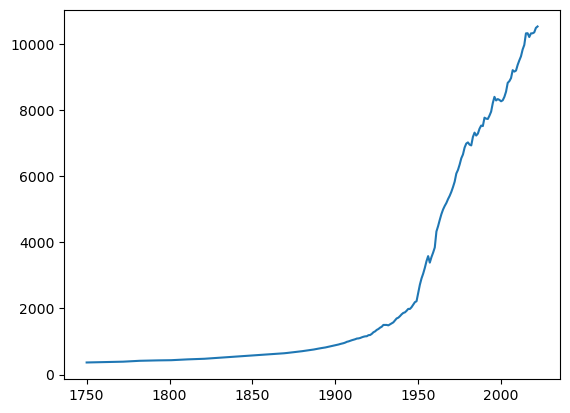

In [2481]:
plt.plot(np.arange(1750,2023,1), n2occ.sum())

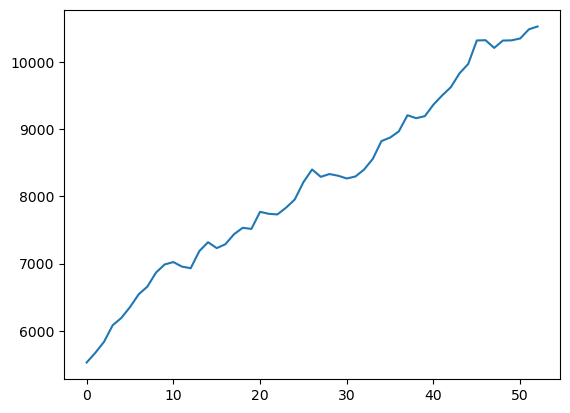

In [2478]:
plt.plot(np.arange(0,53,1), n2oc_years_pre.sum())

In [2494]:
(((ds_dt['n2o'].iloc[230][3] - ds_dt['n2o'].iloc[210][3])) / 1.341130)*100

0.6703509682108032

In [2550]:
0.120348 * 0.098143

0.011811313763999999

In [2552]:
(0.011811313763999999/ 1.341130)*100

0.8806986469618904

In [2793]:
#to get how much 2no from ag (1960-1980) has contributed to todays warming
# 1. find fraction of ag from 1960-1980 still in atmosphere (2022 total)
# 2. find how much that is in warming by multiplying fraction to todays N2O warming
# 3. divide this temp. number by the total temperture to get the contribution to todays warming
n2o_from_ag = (n2o_decayedc.iloc[:,210:231].sum(axis=1)/n2o_decayedc.iloc[:,-2].sum())[3]
n2o_from_ag, ((n2o_from_ag * ds_dt_3[2022].iloc[2,-1])/ds_dt_3[2022].iloc[-1,-1])*100, n2o_from_ag * ds_dt_3[2022].iloc[2,-1]

print('Fraction of n2o from Ag 1960-1980 still in atmosphere (2022 total) = ', round(n2o_from_ag,3))
print()
print('Contribution of n2o from Ag 1960-1980 emissions to net warming (2022) = ', round(n2o_from_ag * ds_dt_3[2022].iloc[2,-1],3) \
     ,'degC and in percent = ', round(((n2o_from_ag * ds_dt_3[2022].iloc[2,-1])/ds_dt_3[2022].iloc[-1,-1])*100, 3),'%')

Fraction of n2o from Ag 1960-1980 still in atmosphere (2022 total) =  0.098

Contribution of n2o from Ag 1960-1980 emissions to net warming (2022) =  0.012 degC and in percent =  0.881 %


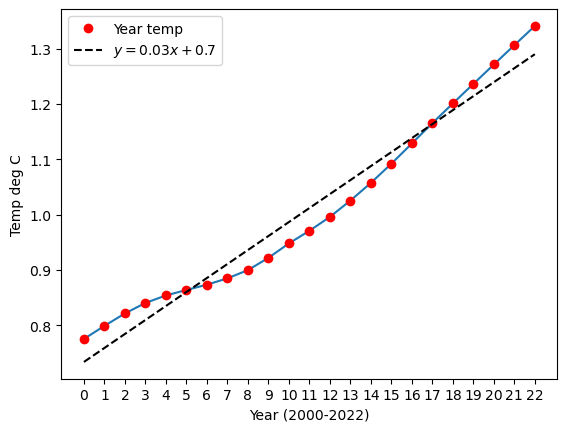

In [2326]:
# Total del_T by year with trend of time period (2000-2022)
plt.plot(np.arange(0,22+1), list(ds_dt_tot.values()))
x = np.arange(0,22+1)
y = list(ds_dt_tot.values())
coef = np.polyfit(np.arange(0,22+1), list(ds_dt_tot.values()),1)
poly1d_fn = np.poly1d(coef) 
m,b = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'ro', label = 'Year temp')
plt.plot( x, poly1d_fn(x), '--k', label=f'$y = {m:.2f}x {b:+.1f}$') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.ylabel('Temp deg C')
plt.xlabel('Year (2000-2022)')
plt.xticks(np.arange(0,22+1))
plt.legend()
# plt.xlim(0, 5)
# plt.ylim(0, 12)

In [2327]:
#Generate DataFrame (table) of del_T for all climate forcers and sectors
del_t_all = pd.concat(ds_dt_2022, axis=1)
del_t_all.columns = [x.upper() for x in del_t_all.columns]
del_t_all = del_t_all.T.rename_axis('Del_T cumulative decayed emissions (1750-2022)', axis = 'columns')
del_t_all['species sum del_T'] = del_t_all.sum(axis=1)
del_t_all.loc['sector sum del_T'] = del_t_all.sum(axis=0)

# Results

In [2328]:
del_t_all#.iloc[:-1,:-1]

Del_T cumulative decayed emissions (1750-2022),Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings,species sum del_T
CO2,0.295460,0.085699,0.000694,0.015199,0.295487,0.206459,0.119840,1.018838
CH4,0.001656,0.239511,0.119887,0.238406,0.001939,0.002519,0.019202,0.623120
N2O,0.002107,0.000261,0.005316,0.077161,0.027173,0.005305,0.003025,0.120348
HC,0.000000,0.000000,0.000000,0.000000,0.063544,0.007382,0.034681,0.105607
BC,0.002984,0.005084,0.002614,0.002627,0.007795,0.012340,0.024793,0.058238
VOC,0.001388,0.027910,0.002438,0.010621,0.036495,0.021119,0.024078,0.124049
SO2,-0.222365,-0.047605,-0.001371,-0.005153,-0.184321,-0.070951,-0.031567,-0.563333
NOX,-0.028060,-0.004441,-0.002697,-0.010534,-0.020625,-0.068846,-0.005569,-0.140772
NH3,-0.000056,-0.000273,-0.002387,-0.013184,-0.000284,-0.000133,-0.000787,-0.017104
OC,-0.007494,-0.002337,-0.013507,-0.001821,-0.013764,-0.005335,-0.067656,-0.111913


In [2329]:
tab_plt_dT= del_t_all.iloc[:-1,:-1]

### Generate ERF & del_T Figure by Gas-Sector

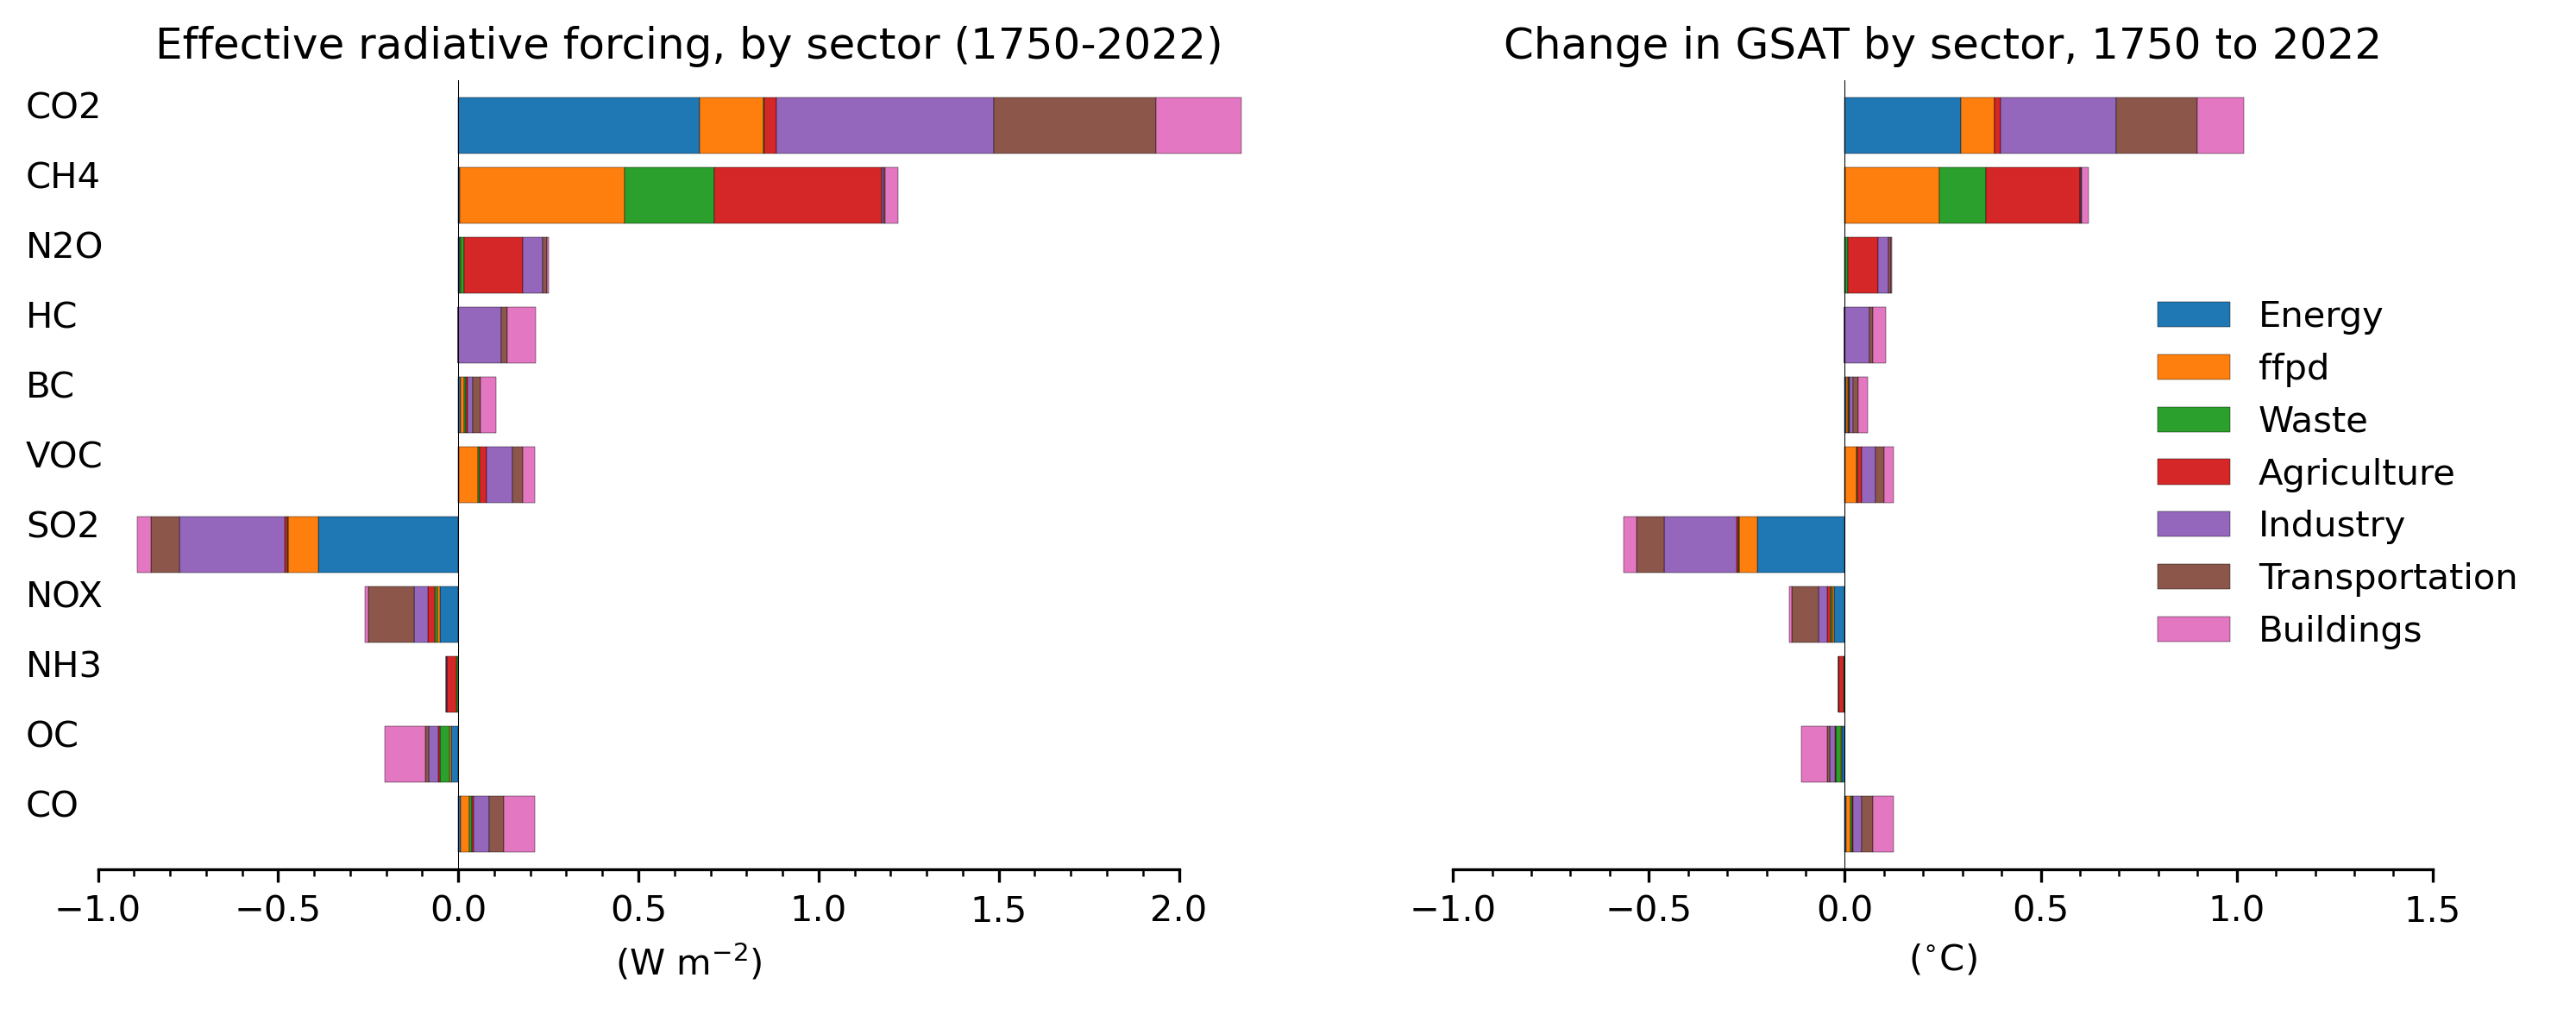

In [2330]:
sns.set_style()
fig, axs = plt.subplots(1, 2, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}

ax = axs[0]
ax.axvline(x=0., color='k', linewidth=0.25)

df_spec_sector_erf.plot.barh(stacked=True, ax=ax, **kws)#color=col_ls, ax=ax, **kws)
# tab_plt_erf.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = table['Total'][::-1]
# tot = tab_plt_erf.reindex(index_order).sum(axis=1)  # tab_plt

tot = df_spec_sector_erf.sum(axis=1)  # tab_plt
# xerr = df_err['95-50_period'].reindex(index_order)
y = np.arange(len(tot))
# ax.errorbar(tot, y, xerr=xerr, marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

for lab, y in zip(index_order.T, ybar):
    # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
    ax.text(-1.2, y - 0.1, lab, ha='left')  # , va='left')

# for lab, y in zip(index_order2, ybar):
#     # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
#     ax.text(-.75, y - 0.1, lab, ha='left')  # , va='left')
    
ax.set_title('Effective radiative forcing, by sector (1750-2022)')
ax.set_xlabel(r'(W m$^{-2}$)')
# ax.set_xlim(-1.5, 2.6)
# plt.xlim(-1.6, 2.0)
# sns.despine(fig, left=True, trim=True)
ax.legend(loc='lower right', frameon=False)
ax.set_yticks([])

ax.get_legend().remove()

ax.set_xticks(np.arange(-1, 2.1, .5))
ax.set_xticks(np.arange(-1, 2, .1), minor=True)
ax.invert_yaxis()

ax = axs[1]
ax.axvline(x=0., color='k', linewidth=0.25)

tab_plt_dT.reindex(index_order).plot.barh(stacked=True, ax=ax, **kws)# color=col_ls, ax=ax, **kws)
tot = tab_plt_dT.reindex(index_order).sum(axis=1)
# # xerr =0# df_err['95-50'][::-1]
y = np.arange(len(tot))
# xerr_dT = err_dT[['p50-05', 'p95-50']].reindex(index_order).transpose().values
# ax.errorbar(tot, y,
#             xerr=xerr_dT,
#             # xerr=err_dT[['min 1 sigma','plus 1 sigma']].loc[tot.index].transpose().values,
#             marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

ax.set_title('Change in GSAT by sector, 1750 to 2022')
ax.set_xlabel(r'($^{\circ}$C)')
ax.set_xlim(-1.3, 1.8)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-1., 1.5)
ax.legend(loc='right', frameon=False)

ax.set_xticks(np.arange(-1, 1.5, .5))
# ax.xaxis.set_major_locator(MultipleLocator(.5))

ax.set_xticks(np.arange(-1, 1.6, .5))
ax.set_xticks(np.arange(-1, 1.5, .1), minor=True)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()

# fig.savefig('data_out/ERF_delT_Compound_Sector_ERF_GSAT_1750_2022_CEDS.png')
#fig.savefig('data_out/ERF_delT_Compound_Sector_ERF_GSAT_1750_2022_CEDS_ffpd_separated.png')
# fig.savefig('ERF_Compound_Sector_ERF1750_2019_EDGAR.png')
# fig.savefig('ERF_Compound_Sector_ERF1970_2019.png')

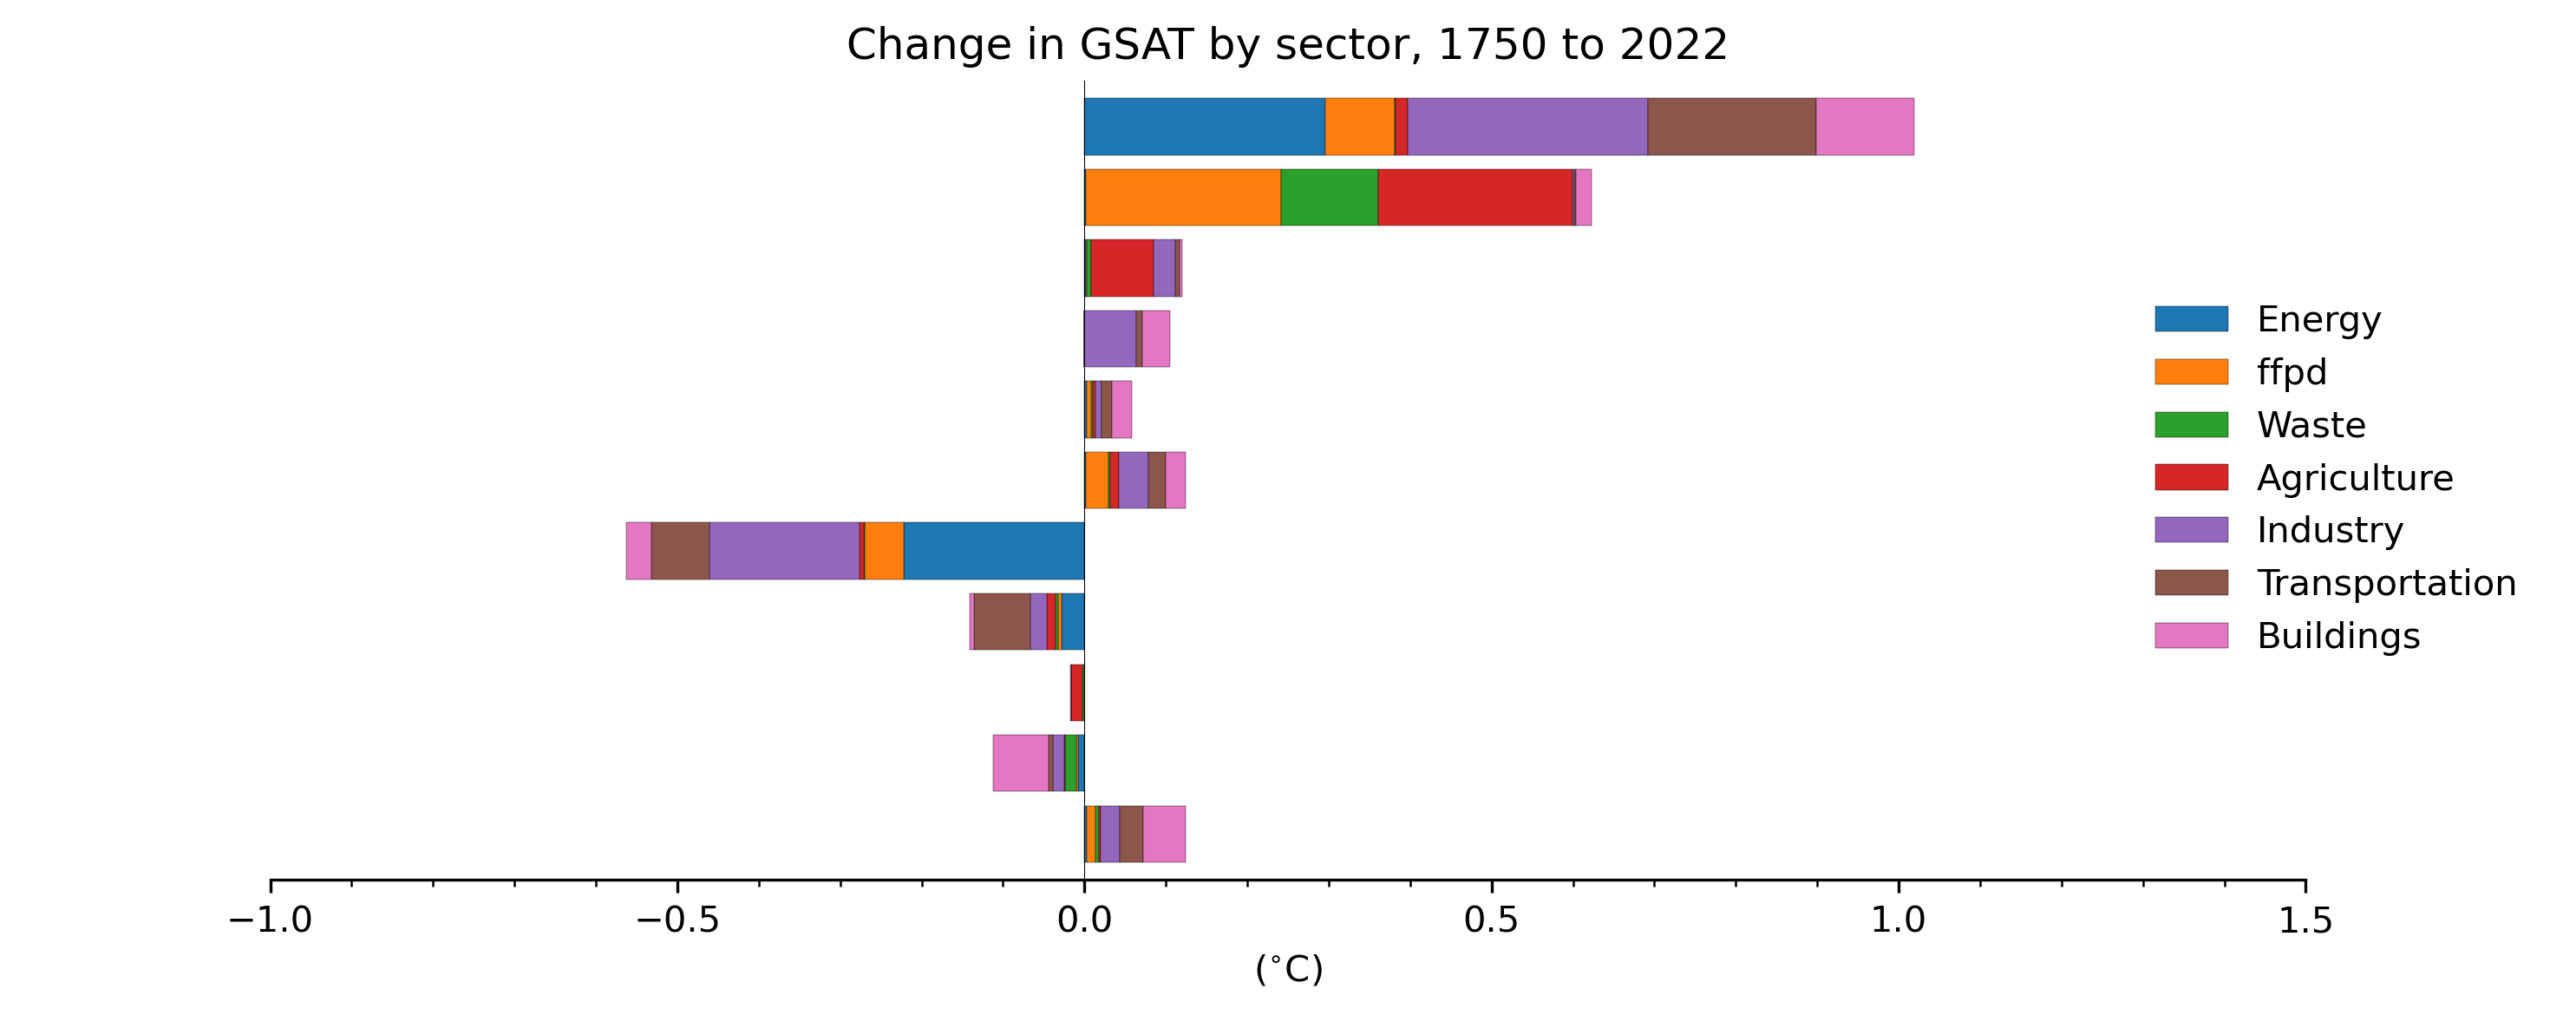

In [2331]:
sns.set_style()
fig, axs = plt.subplots(1, 1, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}


ax = axs
ax.axvline(x=0., color='k', linewidth=0.25)

tab_plt_dT.reindex(index_order).plot.barh(stacked=True, ax=ax, **kws)# color=col_ls, ax=ax, **kws)
tot = tab_plt_dT.reindex(index_order).sum(axis=1)
# # xerr =0# df_err['95-50'][::-1]
y = np.arange(len(tot))
# xerr_dT = err_dT[['p50-05', 'p95-50']].reindex(index_order).transpose().values
# ax.errorbar(tot, y,
#             xerr=xerr_dT,
#             # xerr=err_dT[['min 1 sigma','plus 1 sigma']].loc[tot.index].transpose().values,
#             marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

ax.set_title('Change in GSAT by sector, 1750 to 2022')
ax.set_xlabel(r'($^{\circ}$C)')
ax.set_xlim(-1.3, 1.8)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-1., 1.5)
ax.legend(loc='right', frameon=False)

ax.set_xticks(np.arange(-1, 1.5, .5))
# ax.xaxis.set_major_locator(MultipleLocator(.5))

ax.set_xticks(np.arange(-1, 1.6, .5))
ax.set_xticks(np.arange(-1, 1.5, .1), minor=True)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()

# fig.savefig('data_out/DelT_Compound_Sector_GSAT_1750_2022_CEDS.png')
# fig.savefig('data_out/DelT_Compound_Sector_GSAT_1750_2022_CEDS_ffpd_separated.png')

## Save ERF and del_Temp files

In [2332]:
# WITH FFPD
# newpath = r'C:data_out' 
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# newpath = r'C:data_out/data_out_2024/del_T_years'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)
    
# newpath = r'C:data_out/data_out_2024/relative_del_T_years'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# newpath = r'C:data_out/data_out_2024/relative_del_T_years_trend'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# #save ERF for 2022
# erf2.T.to_csv('data_out/data_out_2024/all_species&sectors_ERF_decay_emiss_cumulative_2022.csv')

# #save del_T for 2022
# del_t_all.to_csv('data_out/data_out_2024/all_species&sectors_del_T_decay_emiss_cumulative_2022.csv')

# #save del_T for each year
# for yr in ds_dt_3.keys():
#     ds_dt_3[yr].to_csv('data_out/data_out_2024/del_T_years/del_T_decay_emiss_cumulative_' + str(yr) +'.csv')   
    
# # save rel contributions for each year
# for yr in ds_dt_4.keys():
#     ds_dt_4[yr].to_csv('data_out/data_out_2024/relative_del_T_years/relative_del_T_decay_emiss_cumulative_' + str(yr) +'.csv')
    
# #save trend in rel contributions (2000-2022)
# dt_trend.to_csv('data_out/data_out_2024/relative_del_T_years_trend/trend_relative_del_T_decay_emiss_cumulative.csv')


In [2333]:
# WITH FFPD SEPARATED

# newpath = r'C:data_out' 
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# newpath = r'C:data_out/data_out_2024/ffpd_sep/del_T_years'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)
    
# newpath = r'C:data_out/data_out_2024/ffpd_sep/relative_del_T_years'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# newpath = r'C:data_out/data_out_2024/ffpd_sep/relative_del_T_years_trend'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)
    
# # save ERF for 2022
# erf2.T.to_csv('data_out/data_out_2024/ffpd_sep/all_species&sectors_ERF_decay_emiss_cumulative_2022.csv')

# #save del_T for 2022
# del_t_all.to_csv('data_out/data_out_2024/ffpd_sep/all_species&sectors_del_T_decay_emiss_cumulative_2022.csv')

# #save del_T for each year
# for yr in ds_dt_3.keys():
#     ds_dt_3[yr].to_csv('data_out/data_out_2024/ffpd_sep/del_T_years/del_T_decay_emiss_cumulative_' + str(yr) +'.csv')   
    
# # save rel contributions for each year
# for yr in ds_dt_4.keys():
#     ds_dt_4[yr].to_csv('data_out/data_out_2024/ffpd_sep/relative_del_T_years/relative_del_T_decay_emiss_cumulative_' + str(yr) +'.csv')
    
# #save trend in rel contributions (2000-2022)
# dt_trend.to_csv('data_out/data_out_2024/ffpd_sep/relative_del_T_years_trend/trend_relative_del_T_decay_emiss_cumulative.csv')

In [2334]:
raise SystemExit("Stop here")

SystemExit: Stop here

# END 
Below is old code not used to generate results and figures

In [ ]:
arg = np.array([])
for yr in dt_rel.keys():
    fc = dt_rel[yr].iloc[1,3]
    arg = np.append(arg, fc)
    


In [ ]:
dt_rel[2022]#.iloc[1,3]

In [ ]:
ds_dt_2019 ={}
for spec in ds_specs.keys():
    ds_dt[spec] = ds_specs[spec]['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
    # Get values for latest year
    ds_dt_2019[spec] =  ds_dt[spec].iloc[-4,:]
ds_dt_2019 = pd.concat(ds_dt_2019, axis=1)
ds_dt_2019.columns = [x.upper() for x in ds_dt_2019.columns]
ds_dt_2019 = ds_dt_2019.T.rename_axis('Del_T cumulative decayed emissions (1750-2022)', axis = 'columns')
ds_dt_2019['species sum del_T'] = ds_dt_2019.sum(axis=1)
ds_dt_2019.loc['sector sum del_T'] = ds_dt_2019.sum(axis=0)
ds_dt_2019

In [ ]:
ds_dt_2= ds2['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
ds_dt_co2 = ds_co2['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
ds_dt_ch4 = ds_ch4['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
ds_dt_n2o = ds_n2o['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
ds_dt_hc = ds_hc['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
# ds_dt_2.to_csv('temp_response_int_values_1750_2019.csv')
# ds_dt_co2.iloc[-1].sum()
ds_dt_ch4

In [ ]:
(((ds_dt_co2.iloc[-4]).sum() - df_deltaT.iloc[-1,0])/df_deltaT.iloc[-1,0])*100

In [ ]:
ds_dt_ch4.iloc[-1].sum() 

In [ ]:
ds_dt_ch4

In [ ]:
ds_dt_n2o

In [ ]:
ds_dt_hc

In [ ]:
ds_dt_hc.iloc[-1].sum()

In [ ]:
ds_dt_co2.iloc[-1]/ ds_dt_co2.iloc[-1].sum()

In [ ]:
df_spec_sector_erf.iloc[0,:]/ df_spec_sector_erf.iloc[0,:].sum()

In [ ]:
# df_deltaT.to_csv('temp_response_openscm_values_1750_2019.csv')

In [ ]:
df_deltaT.rename(columns = {'NOx':'NOX'}).sum(axis=1)

In [ ]:
ds_dt_2 

In [ ]:
# ds2.merge(df_deltaT, how = 'inner' ,indicator=False) 
df_diff = (ds_dt_2 - df_deltaT.rename(columns = {'NOx':'NOX'}))
df_diff#.mean(axis=0)

In [ ]:
df_deltaT.rename(columns = {'NOx':'NOX'}).iloc[-1,:]/df_deltaT.rename(columns = {'NOx':'NOX'}).iloc[-1,:]

In [ ]:
(ds_dt_2.iloc[-1,:] - df_deltaT.rename(columns = {'NOx':'NOX'}).iloc[-1,:])/df_deltaT.rename(columns = {'NOx':'NOX'}).iloc[-1,:]

In [ ]:
ds_dt_2.iloc[-1,:]

In [ ]:
df_deltaT.rename(columns = {'NOx':'NOX'}).iloc[-1,:]

In [ ]:
ds_dt_2

In [ ]:
(0.985875 - 0.951383)/0.951383	

In [ ]:
df_deltaT

In [ ]:
df_diff_percent = ((df_diff/df_deltaT.rename(columns = {'NOx':'NOX'}))*100)#.mean(axis=0)
# df_deltaT.to_csv('temp_response_openscm_values_1750_2019.csv')
df_diff_percent#.iloc[2:,:-1].mean(axis=0)

In [ ]:
variable
CO2    18.275021
N2O    18.630617
CH4    18.226879
NOX    21.061506
SO2    19.691683
BC     18.866992
OC     18.214968
NH3    19.037994
VOC    18.597586
dtype: float64

In [ ]:
df_diff_percent[df_diff_percent.HC <1e7].plot()#.mean(axis=0)

In [ ]:
df_diff

In [ ]:


df_deltaT['CO2'].plot(label = 'openscm')
ds_dt_2['CO2'].plot(label = 'IRF')

In [ ]:
ds_dt_2.plot()

In [ ]:
df_diff.tail()

In [ ]:
d1, d2,q1,q2

In [ ]:
d1=3.424102092311003, d2=285.0034778419114, q1=0.443767728883447, q2=0.3195910497425088

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

plt.show()

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(6, 4))

ax1 = ax.twinx()
ax.plot(pd.to_datetime(np.arange(2000,2020,1),format='%Y'), co2.iloc[:,253:].sum(axis=0).values/1e6, '-k,' , label = '$CO_2$')
ax1.plot(pd.to_datetime(np.arange(2000,2020,1),format='%Y'), erf_use.iloc[250:,0].values, '-b') #, label = '$CO_2$ ERF')
# plt.xticks(pd.to_datetime(np.arange(2000,2020,1),format='%Y'))

# ax.xaxis.set_major_formatter('%Y')
# plt.gcf().autofmt_xdate(rotation=90)
# ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
# ax.set(xticks=pd.to_datetime(np.arange(2000,2020,1),format='%Y').year.values)
# ax.xaxis.set_major_formatter(
#     mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
# ax.xaxis.set_major_formatter(pd.to_datetime(np.arange(2000,2020,1)).DateFormatter("%Y"))
dtFmt = mdates.DateFormatter('%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.set_xticks(np.arange(np.min(pd.to_datetime(np.arange(2000,2020,1),format='%Y')), np.max(pd.to_datetime(np.arange(2000,2020,1),format='%Y')), 20))
ax.set_xlim(np.min(pd.to_datetime(np.arange(2000,2020,1),format='%Y')), np.max(pd.to_datetime(np.arange(2000,2021,1),format='%Y')))
ax.set_ylim(24,40)
ax1.set_ylim(1.2,2.2)
ax.set_ylabel('Emissions (Gt)', color = 'k')
ax1.set_ylabel('ERF ($W/m^2$)', color='b')
ax.legend(loc = 'upper left')
plt.show()
plt.show()

In [ ]:
erf_use

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(pd.to_datetime(np.arange(2000,2020,1),format='%Y'), erf_use.iloc[250:,0].values, label = '$CO_2$', color = 'k')
# plt.xticks(pd.to_datetime(np.arange(2000,2020,1),format='%Y'))

dtFmt = mdates.DateFormatter('%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.set_xticks(np.arange(np.min(pd.to_datetime(np.arange(2000,2020,1),format='%Y')), np.max(pd.to_datetime(np.arange(2000,2020,1),format='%Y')), 20))
ax.set_xlim(np.min(pd.to_datetime(np.arange(2000,2020,1),format='%Y')), np.max(pd.to_datetime(np.arange(2000,2021,1),format='%Y')))
ax.set_ylabel('ERF ($W/m^2$)')
plt.legend()
plt.show()
plt.show()

### Historical Emissions Contributions to Warming (EDGAR) [OLD]
emissions contributions to warming by sector/compound

In [ ]:
# Load in Long Lived Climate Forcers
# ch4 = pd.read_excel(r'C:data\EDGAR_CH4_1970_2022\EDGAR_CH4_1970_2022.xlsx','IPCC 2006')
# n2o = pd.read_excel(r'C:data\EDGAR_N2O_1970_2022\EDGAR_N2O_1970_2022.xlsx','IPCC 2006')
# co2 = pd.read_excel(r'C:data\IEA_EDGAR_CO2_1970_2022\IEA_EDGAR_CO2_1970_2022.xlsx','IPCC 2006')
# co2b = pd.read_excel(r'C:data\EDGAR_CO2bio_1970_2022\EDGAR_CO2bio_1970_2022.xlsx','IPCC 2006')
f_gas = pd.read_excel(r'C:data\EDGAR_F-gases_1990-2021\EDGAR_F-gases_1990-2021.xlsx', 'IPCC 2006') # IPCC 2006 sectoR id
f_gas2 = pd.read_excel(r'C:data\EDGAR_F-gases_1990-2021\EDGAR_F-gases_1990-2021.xlsx', 'IPCC 1996') # IPCC 1996 sectoR id
f_gas_ar5 = pd.read_excel(r'C:data\EDGAR_AR5_F-gases_1990_2022\EDGAR_AR5_F-gases_1990_2022.xlsx', 'IPCC 2006') # does not include specific substance, only GWP 100
lts = pd.read_excel(r'C:data\lifetimes.xlsx')
lts = lts.rename(columns = {'compound':'Substance'})
ods = pd.read_csv(r'C:data\ozone-depleting-substance-consumption.csv')

In [ ]:
# plt.plot(np.arange(1970,2021, 1), df['CFC-11'])

In [ ]:
#read in the short lived climate forcers (EDGAR)

# bc = pd.read_excel(r'C:data\v61_AP_BC_1970_2018b\BC_1970_2018.xlsx')
# co = pd.read_excel(r'C:data\v61_AP_CO_1970_2018b\CO_1970_2018.xlsx')
# nh3 = pd.read_excel(r'C:data\v61_AP_NH3_1970_2018b\NH3_1970_2018.xlsx')
# voc = pd.read_excel(r'C:data\v61_AP_NMVOC_1970_2018b\NMVOC_1970_2018.xlsx')
# nox = pd.read_excel(r'C:data\v61_AP_NOx_1970_2018b\NOx_1970_2018.xlsx')
# oc = pd.read_excel(r'C:data\v61_AP_OC_1970_2018b\OC_1970_2018.xlsx')
# so2 = pd.read_excel(r'C:data\v61_AP_SO2_1970_2018b\SO2_1970_2018.xlsx')


In [ ]:
# load in LULUCF data from FAOSTAT
# lulucf =  pd.read_csv(r'C:data\LUCF_FAOSTAT_data_en_10-2-2023.csv')

In [ ]:
# Get land use emissions for the 3 main GHGs
# co2l = lulucf[lulucf.Element == 'Emissions (CO2)']
# co2l = co2l[['Year', 'Value']].reset_index(drop=True)
# years = co2l.Year.values
# year = ['Y_' + str(year) for year in years]
# # co2l = co2l.pivot(values = 'Year')
# co2l['Year'] = year
# # co2l = co2l.pivot( columns = 'Year', values = 'Value').sum(axis = 0).to_frame().T
# co2l = co2l.T
# co2l.columns = co2l.iloc[0]
# co2l = co2l.iloc[1:].reset_index(drop=True)
# co2l.index = co2l.index.set_names([None])

# ch4l = lulucf[lulucf.Element == 'Emissions (CH4)']
# ch4l = ch4l[['Year', 'Value']].reset_index(drop=True)
# years = ch4l.Year.values
# year = ['Y_' + str(year) for year in years]
# ch4l['Year'] = year
# ch4l = ch4l.T
# ch4l.columns = ch4l.iloc[0]
# ch4l = ch4l.iloc[1:].reset_index(drop=True)
# ch4l.index = ch4l.index.set_names([None])

# n2ol = lulucf[lulucf.Element == 'Emissions (N2O)']
# n2ol = n2ol[['Year', 'Value']].reset_index(drop=True)
# years = n2ol.Year.values
# year = ['Y_' + str(year) for year in years]
# n2ol['Year'] = year
# n2ol = n2ol.T
# n2ol.columns = n2ol.iloc[0]
# n2ol = n2ol.iloc[1:].reset_index(drop=True)
# n2ol.index = n2ol.index.set_names([None])
# ch4l

In [ ]:
### ch4.columns = ch4.iloc[9]
# ch4.drop(ch4.index[0:10]).reset_index(drop=True)
# ch4.rename(columns=ch4.iloc[9]).drop(ch4.index[0:10]).reset_index(drop=True)
# f_gas.iloc[0:10,:]
# ods[ods.Entity == 'World'].drop(columns = ['Entity','Code'])
#ch4.iloc[0:10,:]

In [ ]:
# ch4 = ch4.rename(columns=ch4.iloc[8]).drop(ch4.index[0:9]).reset_index(drop=True)

In [ ]:
# ch4_sectorfb = ch4.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# ch4_sectorf = ch4_sectorfb[ch4_sectorfb.fossil_bio == 'fossil']
# ch4_sectorb = ch4_sectorfb[ch4_sectorfb.fossil_bio == 'bio']
# len(ch4.ipcc_code_2006_for_standard_report.unique()),len(ch4.ipcc_code_2006_for_standard_report_name.unique())

In [ ]:
# ch4_sector[['ipcc_code_2006_for_standard_report_name','Y_2018','Y_2019','Y_2020',"Y_2021"]].to_excel("ch4_sector_emissions.xlsx") 
# len(ch4[ 'ipcc_code_2006_for_standard_report_name'].unique())

In [ ]:
# n2o = n2o.rename(columns=n2o.iloc[8]).drop(n2o.index[0:9]).reset_index(drop=True)

# n2o_sectorfb = n2o.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# n2o_sectorf = n2o_sectorfb[n2o_sectorfb.fossil_bio == 'fossil']
# n2o_sectorb = n2o_sectorfb[n2o_sectorfb.fossil_bio == 'bio']

In [ ]:
# n2o_sector[['ipcc_code_2006_for_standard_report_name','Y_2018','Y_2019','Y_2020',"Y_2021"]].to_excel("n2o_sector_emissions.xlsx") 

In [ ]:
# co2b.rename(columns=co2b.iloc[8]).drop(co2b.index[0:8]).reset_index(drop=True)

In [ ]:
# co2 = co2.rename(columns=co2.iloc[8]).drop(co2.index[0:9]).reset_index(drop=True)
# co2b = co2b.rename(columns=co2b.iloc[8]).drop(co2b.index[0:9]).reset_index(drop=True)
# co2_sectorf = co2.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# co2_sectorb = co2b.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()


In [ ]:
# co2_sectorfb = pd.concat([co2, co2b]).groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# co2_sectorfb

In [ ]:
# co2.C_group_IM24_sh.unique()

In [ ]:
# Black Carbon emissions from EDGAR
# bc = bc.rename(columns=bc.iloc[8]).drop(bc.index[0:9]).reset_index(drop=True)
# bc_sectorfb = bc.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# bc_sectorf = bc_sectorfb[bc_sectorfb.fossil_bio == 'fossil']
# bc_sectorb = bc_sectorfb[bc_sectorfb.fossil_bio == 'bio']

In [ ]:
# Carbon Monoxide emissions from EDGAR
# co = co.rename(columns=co.iloc[8]).drop(co.index[0:9]).reset_index(drop=True)
# co_sectorfb = co.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# co_sectorf = co_sectorfb[co_sectorfb.fossil_bio == 'fossil']
# co_sectorb = co_sectorfb[co_sectorfb.fossil_bio == 'bio']


In [ ]:
# Ammonia emissions from EDGAR
# nh3 = nh3.rename(columns=nh3.iloc[8]).drop(nh3.index[0:9]).reset_index(drop=True)
# nh3_sectorfb = nh3.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# nh3_sectorf = nh3_sectorfb[nh3_sectorfb.fossil_bio == 'fossil']
# nh3_sectorb = nh3_sectorfb[nh3_sectorfb.fossil_bio == 'bio']
# nh3_sector[['ipcc_code_2006_for_standard_report_name','Y_2015','Y_2016','Y_2017',"Y_2018"]].to_excel("nh3_sector_emissions.xlsx") 

In [ ]:
# Volatile Organic Carbon Emissions from Edgar
# voc = voc.rename(columns=voc.iloc[8]).drop(voc.index[0:9]).reset_index(drop=True)
# voc_sectorfb = voc.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# voc_sectorf = voc_sectorfb[voc_sectorfb.fossil_bio == 'fossil']
# voc_sectorb = voc_sectorfb[voc_sectorfb.fossil_bio == 'bio']


In [ ]:
# NOx Emissions from Edgar
# nox = nox.rename(columns=nox.iloc[8]).drop(nox.index[0:9]).reset_index(drop=True)
# nox_sectorfb = nox.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# nox_sectorf = nox_sectorfb[nox_sectorfb.fossil_bio == 'fossil']
# nox_sectorb = nox_sectorfb[nox_sectorfb.fossil_bio == 'bio']


In [ ]:
#Organic Carbon emissions from EDGAR
# oc = oc.rename(columns=oc.iloc[8]).drop(oc.index[0:9]).reset_index(drop=True)
# oc_sectorfb = oc.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# oc_sectorf = oc_sectorfb[oc_sectorfb.fossil_bio == 'fossil']
# oc_sectorb = oc_sectorfb[oc_sectorfb.fossil_bio == 'bio']


In [ ]:
# Sulfur Dioxide Emissions from EDGAR
# so2 = so2.rename(columns=so2.iloc[8]).drop(so2.index[0:9]).reset_index(drop=True)
# so2_sectorfb = so2.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio']).sum().reset_index()
# so2_sectorf = so2_sectorfb[so2_sectorfb.fossil_bio == 'fossil']
# so2_sectorb = so2_sectorfb[so2_sectorfb.fossil_bio == 'bio']


In [ ]:
# assign substance ID
# f_sector = f_sector.assign(compound='F-gas')
# bc_sector = bc_sector.assign(compound='BC')
# oc_sector = oc_sector.assign(compound='OC')
# co_sector = co_sector.assign(compound='CO')
# nh3_sector = nh3_sector.assign(compound='NH3')
# nox_sector = nox_sector.assign(compound='NOx')
# voc_sector = voc_sector.assign(compound='VOC')
# so2_sector = so2_sector.assign(compound='SO2')

In [ ]:
# from functools import reduce

In [ ]:
# data_frames = [co2_sector,ch4_sector,n2o_sector,f_sector,bc_sector,oc_sector,nh3_sector,nox_sector,voc_sector,so2_sector]
# df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['ipcc_code_2006_for_standard_report_name'],
#                                             how='outer'), data_frames)

In [ ]:
fg = f_gas.rename(columns=f_gas.iloc[9]).drop(f_gas.index[0:10]).reset_index(drop=True)
f_sectorfb = fg.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio','Substance']).sum().reset_index()
f_sectorf = f_sectorfb[f_sectorfb.fossil_bio == 'fossil']
f_sectorb = f_sectorfb[f_sectorfb.fossil_bio == 'bio']

fg2 = f_gas2.rename(columns=f_gas2.iloc[9]).drop(f_gas2.index[0:10]).reset_index(drop=True)
f_sectorfb2 = fg2.groupby(by = ['ipcc_code_1996_for_standard_report_name','fossil_bio','Substance']).sum().reset_index()
f_sectorf2 = f_sectorfb2[f_sectorfb2.fossil_bio == 'fossil']
f_sectorb2 = f_sectorfb2[f_sectorfb2.fossil_bio == 'bio']

In [ ]:
fg['ipcc_code_2006_for_standard_report_name'].unique(), fg2['ipcc_code_1996_for_standard_report_name'].unique()

In [ ]:
sum(f_sectorfb[f_sectorfb.Substance == 'HFC-134a']['Y_2021'])

In [ ]:
(f_sectorfb2[f_sectorfb2.Substance == 'HFC-134a']['Y_2021']).sum()

In [ ]:
fg.ipcc_code_2006_for_standard_report.unique()
fg.Substance.unique()

In [ ]:
fg2.ipcc_code_1996_for_standard_report.unique()
fg2.Substance.unique() # matches the 2006 for both name and emissions total per year

In [ ]:
f_hcfc = f_sectorfb[f_sectorfb.Substance.isin(['HCFC-141b', 'HCFC-142b'])]
f_hcfc = f_hcfc.T.iloc[8:,0:].rename(columns = {32:'HCFC-141b', 33:'HCFC-142b'})
# f_hcfc.head()

In [ ]:
#CH4 decay function
ch4_lifetime = 11.8
t = np.flip(np.arange(0,53,1))
tf = np.flip(np.arange(0,53,1))
ch4d = np.exp(-t/ch4_lifetime)
n2o_lifetime = 109


# plt.plot(t,ch4d)
def methd(x):
    d = x * np.exp(-t/ch4_lifetime)
    return d
#N2O decay function
def nitrod(x):
    d = x * np.exp(-t/n2o_lifetime)
    return d
# F gases decay function
def fluod(x):
    r = x[:-1]
    y = x['lifetime']
    d = r * np.exp(-tf/y)
    return d
# CO2 decay function
def carbd(x):
#     a1 = 0.6368
#     a2 = 0.3322
#     a3 = 0.031
#     t1 = 2.376
#     t2 = 30.14
#     t3 = 490.1
#     g = 3.015
#Grasser 2017
    a0 = 0.2366
    a1 = 0.2673
    a2 = 0.2712
    a3 = 0.2249
    t1 = 4.272
    t2 = 33.10
    t3 = 302.4
# AR 5
#     a0 = 0.2173
#     a1 = 0.224
#     a2 = 0.2824
#     a3 = 0.2763
#     t1 = 394.4
#     t2 = 36.54
#     t3 = 4.304
#     d = x * g*(a1*t1*(1-np.exp(-t/t1))+a2*t2*(1-np.exp(-t/t2))+a3*t3*(1-np.exp(-t/t3)))
#     d = x * g*(a1*np.exp(-t/t1)+a2*np.exp(-t/t2)+a3*np.exp(-t/t3))
    d = x*(a0 + a1 * np.exp(-t/t1) + a2 * np.exp(-t/t2) + a3 * np.exp(-t/t3))
    return d
# def methd2(x,y):
#     d = x * np.exp(-t/ch4_lifetime)
#     d2 = y * np.exp(-t[1:]/ch4_lifetime)
#     D = np.concatenate([np.array([d[0]]),d[1:] + d2])
#     return D

industry = ['Cement production','Chemical Industry', 'Glass Production','Manufacturing Industries and Construction',\
            'Metal Industry','Non-Energy Products from Fuels and Solvent Use','Lime production',\
            'Other Product Manufacture and Use','Electronics Industry',\
            'Product Uses as Substitutes for Ozone Depleting Substances','Other Process Uses of Carbonates']
transportation = ['Civil Aviation','Other Transportation','Railways','Road Transportation no resuspension','Water-borne Navigation',\
                 'Road Transportation resuspension']
burning_biomass = ['Emissions from biomass burning']
power = ['Fossil fuel fires', 'Main Activity Electricity and Heat Production']
fossil_production_distribution = ['Solid Fuels','Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries',\
                                 'Oil and Natural Gas']
waste = ['Incineration and Open Burning of Waste','Biological Treatment of Solid Waste','Solid Waste Disposal',\
        'Wastewater Treatment and Discharge']
agriculture = ['Liming', 'Urea application','Enteric Fermentation','Manure Management','Rice cultivations','Direct N2O Emissions from managed soils',\
              'Indirect N2O Emissions from managed soils','Indirect N2O Emissions from manure management']
buildings = ['Residential and other sectors', 'Refridgeration/Foam/AC']
other = ['Non-Specified','Indirect N2O emissions from the atmospheric deposition of nitrogen in NOx and NH3','Other']
landuse = ['LULUCF']


def sum_and_rename(data):
    industry_sum = data[data.sectors.isin(industry)].sum().to_frame().T
    transportation_sum = data[data.sectors.isin(transportation)].sum().to_frame().T
    burning_biomass_sum = data[data.sectors.isin(burning_biomass)].sum().to_frame().T
    power_sum = data[data.sectors.isin(power)].sum().to_frame().T
    ffpd_sum = data[data.sectors.isin(fossil_production_distribution)].sum().to_frame().T
    waste_sum = data[data.sectors.isin(waste)].sum().to_frame().T
    agriculture_sum = data[data.sectors.isin(agriculture)].sum().to_frame().T
    buildings_sum = data[data.sectors.isin(buildings)].sum().to_frame().T
    other_sum = data[data.sectors.isin(other)].sum().to_frame().T
    lulucf_sum = data[data.sectors.isin(landuse)].sum().to_frame().T
    
    industry_sum['sectors']= 'Industry'
    transportation_sum['sectors'] = 'Transportation'
    burning_biomass_sum['sectors'] = 'Burning'
    power_sum['sectors'] = 'Power'
    ffpd_sum['sectors'] = 'ffpd'
    waste_sum['sectors'] = 'Waste'
    agriculture_sum['sectors'] = 'Agriculture'
    buildings_sum['sectors'] = 'Buildings'
    other_sum['sectors'] = 'Other'
    lulucf_sum['sectors'] = 'LULUCF'
    
    result = pd.concat([industry_sum, transportation_sum, burning_biomass_sum,power_sum, ffpd_sum,waste_sum,\
                       agriculture_sum,buildings_sum,other_sum,lulucf_sum])
    return result

In [ ]:
ch4_sector = ch4_sectorfb.reset_index(drop=True)
ch4d = pd.concat([ch4_sector.iloc[0:,0],ch4_sector.iloc[0:,8:60]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
# ch4d['row_index'] = ch4d.apply(lambda x: x.name, axis = 1)
# ch4d.to_excel('ch41970_2021')
# ch4d.to_excel('ch41970_2021.xlsx')
ch4d

In [ ]:
ch4d = pd.concat([ch4_sector.iloc[0:,0],ch4_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
ch4d_years = ch4d.iloc[0:,1:]
ch4d_years = pd.concat([ch4d_years, ch4l],axis=0).reset_index(drop=True)
ch4d_years.iloc[36,51:] = ch4d_years.iloc[36,50] #fb
# ch4d_years.iloc[22,51:] = ch4d_years.iloc[22,50] #f
# ch4d_years.iloc[14,51:] = ch4d_years.iloc[14,50] #b
methane_decayed = ch4d_years.apply(lambda x: methd(x), axis=1)
methane_decayed['total'] = methane_decayed.sum(axis=1)
methane_decayed_fraction = methane_decayed.iloc[:,0:-1].div(methane_decayed.total, axis=0)
# methane_decayed.sum(axis=1)
methane_decayed_fraction['sectors'] = ch4d.iloc[:,0] #.sum(axis=1) 
methane_decayed_fraction.set_index('sectors')
# methane_decayed_fraction['total'] = methane_decayed.sum(axis=1)
methane_decayed['sectors'] = ch4d.iloc[:,0]
methane_decayed['sectors'][36] = 'LULUCF' #fb
# methane_decayed['sectors'][22] = 'LULUCF' #f
# methane_decayed['sectors'][14] = 'LULUCF' #b
methane_decayed.set_index('sectors')
methane_decayed

In [ ]:
ch4_agg_decay = sum_and_rename(methane_decayed)
ch4_agg_decay_fraction = ch4_agg_decay.iloc[:,0:-2].div(ch4_agg_decay.total, axis=0)
ch4_agg_decay_fraction.index = ch4_agg_decay.sectors
ch4_agg_decay_fraction

In [ ]:
ch4_agg_decay.total/ch4_agg_decay.total.sum()*100

In [ ]:
# ch4_agg_decay = sum_and_rename(methane_decayed)
# ch4_agg_decay_fraction = ch4_agg_decay.iloc[:,0:-2].div(ch4_agg_decay.total, axis=0)
# ch4_agg_decay_fraction.index = ch4_agg_decay.sectors
# ch4_agg_decay_fraction

In [ ]:
plt.bar(np.arange(1970,2023,1),ch4_agg_decay_fraction.iloc[0,0:].values)
plt.ylabel('Fraction Contribution')
plt.xlabel('Year of Emission')
plt.title('Fraction Contribution of Emissions to 2021 Total')


In [ ]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),ch4_agg_decay.iloc[0,0:-2].values, label  = 'Industry')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to CH4 Emissions (2021)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),ch4_agg_decay_fraction.iloc[0,0:].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [ ]:
plt.bar(np.arange(1970,2023,1),ch4_agg_decay.iloc[0,0:-2].values)
plt.bar(np.arange(1970,2023,1),ch4_agg_decay.iloc[1,0:-2].values)
plt.ylabel('Emissions (kt)')
plt.xlabel('Year of Emission')

In [ ]:
n2o_sector = n2o_sectorfb.reset_index(drop=True)
n2od = pd.concat([n2o_sector.iloc[0:,0],n2o_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
n2od_years = n2od.iloc[0:,1:]
n2od_years = pd.concat([n2od_years, n2ol],axis=0).reset_index(drop=True)
n2od_years.iloc[35,51:] = n2od_years.iloc[35,50] #fb
# n2od_years.iloc[22,51:] = n2od_years.iloc[22,50] #f
# n2od_years.iloc[13,51:] = n2od_years.iloc[13,50] #b
nitrous_decayed = n2od_years.apply(lambda x: nitrod(x), axis=1)
nitrous_decayed['total'] = nitrous_decayed.sum(axis=1)
nitrous_decayed_fraction = nitrous_decayed.iloc[:,0:-1].div(nitrous_decayed.total, axis=0)
# methane_decayed.sum(axis=1)
nitrous_decayed_fraction['sectors'] = n2od.iloc[:,0] #.sum(axis=1) 
nitrous_decayed_fraction.set_index('sectors')
# methane_decayed_fraction['total'] = methane_decayed.sum(axis=1)
nitrous_decayed['sectors'] = n2od.iloc[:,0]
nitrous_decayed['sectors'][35] = 'LULUCF' #fb
# nitrous_decayed['sectors'][22] = 'LULUCF' #f
# nitrous_decayed['sectors'][13] = 'LULUCF' #b
nitrous_decayed.set_index('sectors')


In [ ]:
n2o_agg_decay = sum_and_rename(nitrous_decayed)
n2o_agg_decay_fraction = n2o_agg_decay.iloc[:,0:-2].div(n2o_agg_decay.total, axis=0)
n2o_agg_decay_fraction.index = n2o_agg_decay.sectors
n2o_agg_decay_fraction

In [ ]:
n2o_agg_decay.total/n2o_agg_decay.total.sum()*100

In [ ]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),n2o_agg_decay.iloc[0,0:-2].values, label  = 'Industry')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to N2O Emissions (2021)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),n2o_agg_decay_fraction.iloc[0,0:].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [ ]:
n2odsum = sum_and_rename(n2od)
n2odsum.iloc[0:,1:]

In [ ]:
plt.bar(np.arange(1970,2023,1),n2odsum.iloc[0,1:].values, label  = 'Industry')

In [ ]:
co2_sector = co2_sectorfb.reset_index(drop=True)
co2d = pd.concat([co2_sector.iloc[0:,0],co2_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
co2d_years = co2d.iloc[0:,1:]
co2d_years = pd.concat([co2d_years, co2l],axis=0).reset_index(drop=True)
# co2d_years.iloc[23,51:] = co2d_years.iloc[23,50] #f
co2d_years.iloc[38,51:] = co2d_years.iloc[38,50] #fb use earlier LULUCF emissions for 2022 year
# co2d_years.iloc[15,51:] = co2d_years.iloc[15,50] #b

carbon_decayed = co2d_years.apply(lambda x: carbd(x), axis=1)
carbon_decayed['total'] = carbon_decayed.sum(axis=1)
carbon_decayed_fraction = carbon_decayed.iloc[:,0:-1].div(carbon_decayed.total, axis=0)
# methane_decayed.sum(axis=1)

carbon_decayed_fraction['sectors'] = co2d.iloc[:,0] #.sum(axis=1) 
carbon_decayed_fraction['sectors'][24] = 'LULUCF'
carbon_decayed_fraction.set_index('sectors')
carbon_decayed['sectors'] = co2d.iloc[:,0]
# carbon_decayed['sectors'][23] = 'LULUCF' #f
carbon_decayed['sectors'][38] = 'LULUCF' #fb
# carbon_decayed['sectors'][15] = 'LULUCF' #b
carbon_decayed.set_index('sectors')
carbon_decayed

In [ ]:
co2_agg_decay = sum_and_rename(carbon_decayed)
co2_agg_decay_fraction = co2_agg_decay.iloc[:,0:-2].div(co2_agg_decay.total, axis=0)
co2_agg_decay_fraction.index = co2_agg_decay.sectors
co2_agg_decay

In [ ]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),co2_agg_decay.iloc[0,0:-2].values/1e6, label  = 'Industry')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (Gt)')
ax1.set_title('Contribution to Remaining CO2 Emissions (1970-2021)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),co2_agg_decay_fraction.iloc[0,0:].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [ ]:
cumsumco2 = np.cumsum(co2_agg_decay.iloc[0,0:-2].values)
cumsumco2/1e6
cumsumco2_reverse = np.cumsum(np.flip(co2_agg_decay.iloc[0,0:-2].values))
cumsumco2_2000 = np.flip(np.cumsum(np.flip(co2_agg_decay.iloc[0,0:31].values)))
cumsumco2_2001 = np.flip(np.cumsum(np.flip(co2_agg_decay.iloc[0,31:-2].values)))

In [ ]:
actualco2 = sum_and_rename(co2d)
cumsum_actualco2 = np.cumsum(actualco2.iloc[0,1:].values)
cumsum_actualco2_2000 = np.flip(np.cumsum(np.flip(actualco2.iloc[0,1:32].values)))
cumsum_actualco2_2001 = np.flip(np.cumsum(np.flip(actualco2.iloc[0,32:].values)))

In [ ]:
from matplotlib.patches import Rectangle
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),co2_agg_decay.iloc[0,0:-2].values/1e6, label  = 'Industry - Decay')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (Gt)')
ax1.set_title('Contribution to Remaining CO2 Emissions (1970-2022)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),co2_agg_decay_fraction.iloc[0,0:].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
bar3 = ax1.bar(np.arange(1970,2023,1),actualco2.iloc[0,1:].values/1e6, label  = 'Industry - Actual')
# bar4 = ax1.bar(2021,co2_agg_decay.iloc[0,-2]/1e6, label  = 'Industry - Total')
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax1.legend([bar1,bar3, extra], ( 'Industry - Decay', 'Industry - Actual',"Total = 260 Gt"))
# ax1.legend(title='abc xyz')
# \ax.legend([extra, bar_0_10, bar_10_100], ("My explanatory text", "0-10", "10-100"))
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [ ]:
((co2_agg_decay.total - co2_agg_decay_2017.total)/co2_agg_decay.total).mean()*100

In [ ]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),cumsumco2/1e6, label  = 'Industry - Decay')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (Gt)')
ax1.set_title('Contribution to Cumulative CO2 Emissions (1970-2022)')
ax2 = ax1.twinx()
# bar2 = ax2.bar(np.arange(1970,2022,1),co2_agg_decay_fraction.iloc[0,0:].values) #, label  = 'Emissions (kt)')
# ax2.set_ylabel('Fraction Contribution')
bar2 = ax1.bar(np.arange(1970,2023,1),cumsum_actualco2/1e6, label  = 'Industry - Actual', zorder = 0)
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [ ]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2001,1),cumsumco2_2000/1e6, label  = 'Industry - Cumulative 1970-2000')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (Gt)')
ax1.set_title('Contribution to Remaining CO2 Emissions (1970-2021)')
ax2 = ax1.twinx()
# bar2 = ax2.bar(np.arange(1970,2022,1),co2_agg_decay_fraction.iloc[0,0:].values) #, label  = 'Emissions (kt)')
# ax2.set_ylabel('Fraction Contribution')
bar2 = ax1.bar(np.arange(2001,2023,1),cumsumco2_2001/1e6, label  = 'Industry - Cumulative 2001-2021')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [ ]:
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2001,1),cumsum_actualco2_2000/1e6, label  = 'Industry - Cumulative 1970-2000')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (Gt)')
ax1.set_title('Actual CO2 Emissions (1970-2021)')
ax2 = ax1.twinx()
# bar2 = ax2.bar(np.arange(1970,2022,1),co2_agg_decay_fraction.iloc[0,0:].values) #, label  = 'Emissions (kt)')
# ax2.set_ylabel('Fraction Contribution')
bar2 = ax1.bar(np.arange(2001,2023,1),cumsum_actualco2_2001/1e6, label  = 'Industry - Cumulative 2001-2021')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
ax1.set_ylim([0,300])
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [ ]:
a1 = 0.6368
a2 = 0.3322
a3 = 0.031
t1 = 2.376
t2 = 30.14
t3 = 490.1
g = 3.015

In [ ]:
# plt.plot(np.arange(1970,2022,1),g*(a1*t1*(1-np.exp(-t/t1))+a2*t2*(1-np.exp(-t/t2))+a3*t3*(1-np.exp(-t/t3))))
plt.plot(np.arange(1970,2023,1),g*(a1*np.exp(-t/t1)+a2*np.exp(-t/t2)+a3*np.exp(-t/t3)))

In [ ]:
# Very short-lived GHGs/climate forcers
slcf_tot = {}
bc_sector = bc_sectorfb
bcd = pd.concat([bc_sector.iloc[0:,0],bc_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
bc_agg = sum_and_rename(bcd)
slcf_tot['bc']=sum_and_rename(bcd).iloc[:,-1]

co_sector = co_sectorfb
cod = pd.concat([co_sector.iloc[0:,0],co_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
co_agg = sum_and_rename(cod)
slcf_tot['co']=sum_and_rename(cod).iloc[:,-1]

nh3_sector = nh3_sectorfb
nh3d = pd.concat([nh3_sector.iloc[0:,0],nh3_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
nh3_agg = sum_and_rename(nh3d)
slcf_tot['nh3']=sum_and_rename(nh3d).iloc[:,-1]

nox_sector = nox_sectorfb
noxd = pd.concat([nox_sector.iloc[0:,0],nox_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
nox_agg = sum_and_rename(noxd)
slcf_tot['nox']=sum_and_rename(noxd).iloc[:,-1]

oc_sector = oc_sectorfb
ocd = pd.concat([oc_sector.iloc[0:,0],oc_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
oc_agg = sum_and_rename(ocd)
slcf_tot['oc']=sum_and_rename(ocd).iloc[:,-1]

so2_sector = so2_sectorfb
so2d = pd.concat([so2_sector.iloc[0:,0],so2_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
so2_agg = sum_and_rename(so2d)
slcf_tot['so2']=sum_and_rename(so2d).iloc[:,-1]

voc_sector = voc_sectorfb
vocd = pd.concat([voc_sector.iloc[0:,0],voc_sector.iloc[0:,8:61]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
voc_agg = sum_and_rename(vocd)
slcf_tot['voc']=sum_and_rename(vocd).iloc[:,-1]

## Calculate yearly contributions to current emissions

In [ ]:
43.016115+ 43.016115*np.exp(-(1)/12)

In [ ]:
(50.938786*np.exp(-1/12))+48.449551, (50.938786*np.exp(-2/12))+(48.449551*np.exp(-1/12)) + 56.112448,
(50.938786*np.exp(-3/11.8))+(48.449551*np.exp(-2/11.8)) + (56.112448*np.exp(-1/11.8))+59.54047

In [ ]:
(836.95148*np.exp(-3/11.8))+(851.575707	*np.exp(-2/11.8)) + (822.931517*np.exp(-1/11.8))+874.027458

In [ ]:
# 50.938786	95.451609	142.815784	188.989881	

In [ ]:
10*np.exp(-2/11.8)+20*np.exp(-1/11.8)+32

In [ ]:
# initial_emissions = 10
# def calc_cum_emissions(df):
#     #extract the years and sector names
#     years = [int(col.split('_')[1]) for col in df.columns if col.startswith('Y_')]
#     #extract the sector names
#     sectors = df['ipcc_code_2006_for_standard_report_name']
    
#     #intialize an empty dataframe to store the cumulative emissions
#     cum_emissions_dfs = []
# #     cum_emissions_df = pd.DataFrame(columns = ['sector'] + [f'cumulative_{year}' for year in years])
#     #ems = ch4d_years.iloc[0,:].to_numpy()
#     #loop through sector
#     for index, row in df.iterrows():
#         #extract emissions for sector
#         emissions = row[[f'Y_{year}' for year in years]].values.astype(float)
#         #list to store emissions for sector        
#         cum_emissions = [emissions[0]] #p 1970 emissions as initial value
# #         cum_emissions = [float(row['ipcc_code_2006_for_standard_report_name'])]

#         #loop through each yer and calc cum emissions
#         for year, emission in zip(years,emissions):
#             cum_emission = emission * np.exp(-(year-years[0])/12)
#             if not cum_emissions:
#                 cum_emissions.append(cum_emission)
#             else:
#                 cum_emissions.append(cum_emissions[-1]+cum_emission)
#     #append cum_emissions to cum_emissions_df
# #     return cum_emissions_df
#         #create a DataFrame for the current sector
#          cum_emissions_df = pd.DataFrame({'sector':[row['ipcc_code_2006_for_standard_report_name']],**{f'cumulative_{year}': cum_emissions[idx] for idx, year in enumerate(years)}}) #cum_emissions_df(pd.Series(cum_emissions,index = cum_emissions_df.columns), ignore_index=True)
#          #append the cum_emissions_df to the list                                      
#     #append back the original names as strings
#         cum_emissions_dfs.append(cum_emissions_df)
#     #concatenate all dfs into one
#     cum_emissions_df = pd.concat(cum_emissions_dfs,ignore_index = True)
    
#     return cum_emissions_df
                                   
# # #print cumulative emissions for the year
# # for year, total_emissions in zip(years, cum_emissions):
# #      print("{} = {:.4f} kilotons".format(year, total_emissions))
            

In [ ]:
import pandas as pd
import numpy as np

def calculate_cumulative_emissions(df,decay):
    # Extract the industry names
    sector = df['sectors']

    # Extract the years from the column names
    years = [int(col.split('_')[1]) for col in df.columns if col.startswith('Y_')]

    # Initialize an empty list to store the results
    results = []

    # Loop through each row (sector) in the DataFrame
    for index, row in df.iterrows():
        # Extract emissions data for the current industry
        emissions = row[[f'Y_{year}' for year in years]].values.astype(float)

        # Initialize a list to store cumulative emissions for this industry
        cumulative_emissions = []

        # Loop through each year and calculate cumulative emissions
        for idx, year in enumerate(years):
#             decay_factor = np.exp(-(abs(year-years[0]))/decay)
            decay_factor = np.exp(-1/decay)
            current_emission = emissions[idx] 
            if idx==0:
#                 dec_emission = emissions[idx-1]  * decay_factor
                cumulative_emissions.append(current_emission)
            elif np.isnan(current_emission) == True:
                prev_cumulative = 0
                cumulative_emissions.append(prev_cumulative)
            else:
                prev_cumulative = cumulative_emissions[idx-1] * decay_factor
                cumulative_emissions.append(current_emission + prev_cumulative)
                    
#             cumulative_emissions.append(emissions[0])
#             if idx == 0:
#                 cumulative_emissions.append(emissions[0])
#             else:
#                 decay_factor = np.exp(-(abs(year-years[-1]))/decay)
#                 current_emission = emissions[idx] * decay_factor
#                 prev_cumulative = cumulative_emissions[idx-1]
#                 cumulative_emissions.append(prev_cumulative + current_emission)

        # Store the results for this industry
        results.append([row['sectors']] + cumulative_emissions)

    # Create a DataFrame for the results
    cols = ['sectors'] + [f'cumulative_{year}' for year in years]
    cumulative_emissions_df = pd.DataFrame(results, columns=cols)

    return cumulative_emissions_df#, prev_cumulative, current_emission, decay_factor, idx#, dec_emission

# Example DataFrame with actual emissions for 1970 
data = {'sectors': ['cement', 'steel'],
        'Y_1970': [10, 30],
         'Y_1971': [20, 40],
          'Y_1972': [32,56],
         'Y_1973': [41,73]}
#          'Y_1974': [55,87]}
df = pd.DataFrame(data)

# Calculate cumulative emissions for the example DataFrame 
cumulative_emissions_df = calculate_cumulative_emissions(df, 11.8)

# Print the result
print(cumulative_emissions_df)


In [ ]:
np.isnan(ch4d_years.iloc[1,1])

In [ ]:
years = [int(col.split('_')[1]) for col in df.columns if col.startswith('Y_')]
np.exp(-(abs(years[1]-years[-1]))/11.8)
# years
years[0]

In [ ]:
# 30*np.exp(-4/11.8)+40*np.exp(-3/11.8)+56*np.exp(-2/11.8)+73*np.exp(-1/11.8)+87
(((30*np.exp(-1/11.8)+40)*np.exp(-1/11.8)+56)*np.exp(-1/11.8))+73
# 30*np.exp(-1/11.8)+40

In [ ]:
ch4d_years['sectors'] = ch4d.sectors
ch4d_years['sectors'][36] = 'LULUCF' #fb
ch4_decayed = calculate_cumulative_emissions(ch4d_years, 11.8)
# ch4_decayed.to_excel('ch41970_2021_decay.xlsx')

In [ ]:
# ch4_decayed

In [ ]:
# ch4ds=sum_and_rename(ch4d)
# ch4ds
# ch4_decayed.iloc[-1,20:],ch4d_years.iloc[-1,20:]

In [ ]:
# ch4ds.iloc[0,1]*np.exp(-1/11.8)+ch4ds.iloc[0,2]
# ch4ds.iloc[0,1:].cumsum().plot()

In [ ]:
ch4_hist_decay = sum_and_rename(ch4_decayed).set_index('sectors')
# sectors = ch4_hist_decay.sectors.values
# ch4_hist_decay = ch4_hist_decay.T.iloc[1:,:]
# ch4_hist_decay = ch4_hist_decay.rename(columns = ch4_agg_decay.sectors)
ch4_hist_decay = ch4_hist_decay.T#.drop('sectors')
# ch4_hist_decay

In [ ]:
ch4_hist_decay.index = np.arange(1970,2023,1)
# ch4_decayed

In [ ]:
# ch4_agg_decay
# ch4_agg_decay.iloc[:,:-3].sum(axis=1)

In [ ]:
# plt.plot(np.arange(1970,2023,1), ch4_hist_decay.iloc[0:,0].values)
# plt.plot(np.arange(1970,2023,1), ch4ds.iloc[0,1:].values)
# # len(ch4_hist_decay.iloc[0:,0].values)
# # np.arange(1970,2022,1)

In [ ]:
ch4_hist_decay.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('Methane Historical Emissions')

In [ ]:
# ch4_hist_decay.iloc[-1,:].plot(kind = 'bar')
(ch4_hist_decay.iloc[-1,:]/ch4_hist_decay.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

In [ ]:
# ch4_hist_decay

In [ ]:
path = r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Documents\AR6_CH6_RCMIPFIGS\ar6_ch6_rcmipfigs\data_out\fig6_12_ts15_historic_delta_GSAT\dT_data_hist_recommendation.nc'

In [ ]:
import xarray as xr

In [ ]:
ds = xr.open_dataset(r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Documents\AR6_CH6_RCMIPFIGS\ar6_ch6_rcmipfigs\data_out\fig6_12_ts15_historic_delta_GSAT\dT_data_hist_recommendation.nc')

In [ ]:
ds

In [ ]:
# def get_cmap_dic(keys, palette='colorblind'):
#     cols = sns.color_palette(palette, n_colors=len(keys))
#     colordic = {}  # 'NorESM1-LM':col}
#     for model, col in zip(keys, cols):
#         _col = get_chem_col(model)
#         if _col is not None:
#             col = _col
#         colordic[model] = col

#     return colordic

In [ ]:
# cols = get_cmap_dic(ds['variable'].values)
cols = (0.9568627450980393, 0.796078431372549, 0.21176470588235294),(0.8274509803921568, 0.0, 0.1568627450980392),(1.0, 0.4196078431372549, 0.07450980392156863)\
        ,(0.26666666666666666, 0.0, 0.5254901960784314), (0.3764705882352941, 0.5725490196078431, 0.796078431372549),(0.5411764705882353, 0.2235294117647059, 0.0)\
        ,(0.4745098039215686, 0.792156862745098, 0.9333333333333333),(0.0, 0.6901960784313725, 0.6039215686274509),(0.0, 0.5019607843137255, 0.23137254901960785)\
        , (0.47843137254901963, 0.5058823529411764, 0.5058823529411764)

In [ ]:
df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']
df_deltaT

In [ ]:
col_list = [cols[c] for c in np.arange(0,10,1)] #df_deltaT.columns]

In [ ]:
cols[3]

In [ ]:
# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

col_list = [cols[c] for c in np.arange(0,10,1)]

# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

fig, ax = plt.subplots(figsize=[10, 5])
ax.hlines(0, 1970, 2025, linestyle='solid', alpha=0.9, color='k',
          linewidth=0.5)  # .sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3)

ch4_hist_decay.plot.area(color= col_list, ax=ax)
ch4_hist_decay.sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3, label='Sum')
plt.legend(loc='upper left', ncol=3, frameon=False)
# plt.ylabel('$\Delta$ GSAT ($^\circ$ C)')
# plt.ylabel(r'(W m$^{-2}$)')
plt.ylabel(r'Emissions (kt)')
ax.set_xlim([1970, 2025])
sns.despine()

In [ ]:
cols

In [ ]:
(1136.967600*np.exp(-3/109))+(1154.067861*np.exp(-2/109)) + (1177.136401*np.exp(-1/109))+1246.928922

In [ ]:
n2od_years['sectors'] = n2od.sectors
n2od_years['sectors'][35] = 'LULUCF' #fb
n2od_decayed = calculate_cumulative_emissions(n2od_years, 109)

In [ ]:
n2o_hist_decay = sum_and_rename(n2od_decayed).set_index('sectors')
n2o_hist_decay = n2o_hist_decay.T#.drop('sectors')
n2o_hist_decay.index = np.arange(1970,2023,1)
n2o_hist_decay.tail()

In [ ]:
n2o_hist_decay.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('N2O Historical Emissions')

In [ ]:
# n2o_agg_decay
# (df_spec_sector_erf.sum(axis=0)/df_spec_sector_erf.sum(axis=0).sum()).plot(kind = 'bar')
(n2o_hist_decay.iloc[-1,:]/n2o_hist_decay.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

In [ ]:
# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

col_list = [cols[c] for c in np.arange(0,10,1)]

# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

fig, ax = plt.subplots(figsize=[10, 5])
ax.hlines(0, 1970, 2025, linestyle='solid', alpha=0.9, color='k',
          linewidth=0.5)  # .sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3)

n2o_hist_decay.plot.area(color= col_list, ax=ax)
n2o_hist_decay.sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3, label='Sum')
plt.legend(loc='upper left', ncol=3, frameon=False)
# plt.ylabel('$\Delta$ GSAT ($^\circ$ C)')
# plt.ylabel(r'(W m$^{-2}$)')
plt.ylabel(r'Emissions (kt)')
ax.set_xlim([1970, 2025])
sns.despine()

In [ ]:
other

In [ ]:
sum_and_rename(n2od_years)

In [ ]:
t = np.arange(0,53,1)
def decay(t):
    return np.exp(-t/109)

n2od_years = n2od_years.fillna(0)
cum_emiss = pd.DataFrame(index = n2od_years.index)

for year in n2od_years.columns[0:-1]:
#     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)
      # cum_emiss[f'{year}'] =  n2od_years.apply(lambda row: row[year] + sum(row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)]), axis=1)
      cum_emiss[f'{year}'] =  n2od_years.apply(lambda row: row[year] + sum(row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)]), axis=1)
#     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)

# cum_emiss.insert(loc=0, column='1970', value=n2od_years['Y_1970'])
cum_emiss['sectors'] = n2od_years.sectors
sum_and_rename(cum_emiss)

In [ ]:
cum_emiss.iloc[:,2].sum()

In [ ]:
n2od_yearsp.head()

In [ ]:
n2od_yearsp.iloc[0,:][:n2od_yearsp.iloc[0,:].index.get_loc('Y_1971')][::-1]

In [ ]:
[decay(j) for j in range(1, n2od_yearsp.iloc[0,:].index.get_loc('Y_1971')+1)]

In [ ]:
[decay(j) for j in range(1, n2od_yearsp.iloc[0,:].index.get_loc('Y_1973')+1)]

In [ ]:
np.exp(-3/109)

In [ ]:
(sum_and_rename(cum_emiss).iloc[:,1]).sum()

In [ ]:
# n2od_yearsp = sum_and_rename(n2od_years)
# n2od_yearsp.iloc[:,1] + (n2od_yearsp.iloc[:,0] * np.exp(-52/109))
(((n2od_years.iloc[:,1] + (n2od_years.iloc[:,0] * np.exp(-1/109))).sum())*np.exp(-1/109))+n2od_years.iloc[:,2].sum()

In [ ]:
def calculate_cumulative_emissions_C(df):
    # Extract the industry names
    sector = df['sectors']

    # Extract the years from the column names
    years = [int(col.split('_')[1]) for col in df.columns if col.startswith('Y_')]
    
    #decay
    a0 = 0.2366
    a1 = 0.2673
    a2 = 0.2712
    a3 = 0.2249
    t1 = 4.272
    t2 = 33.10
    t3 = 302.4
    d = (a0 + a1 * np.exp(-1/t1) + a2 * np.exp(-1/t2) + a3 * np.exp(-1/t3))

    # Initialize an empty list to store the results
    results = []

    # Loop through each row (sector) in the DataFrame
    for index, row in df.iterrows():
        # Extract emissions data for the current industry
        emissions = row[[f'Y_{year}' for year in years]].values.astype(float)

        # Initialize a list to store cumulative emissions for this industry
        cumulative_emissions = []

        # Loop through each year and calculate cumulative emissions
        for idx, year in enumerate(years):
#              decay_factor = np.exp(-(abs(year-years[0]))/decay)
            decay_factor = (a0 + a1 * np.exp(-(abs(year-years[-1]))/t1) + a2 * np.exp(-(abs(year-years[-1]))/t2)\
                            + a3 * np.exp(-(abs(year-years[-1]))/t3))
            current_emission = emissions[idx] 
            if idx==0:
#                 dec_emission = emissions[idx-1]  * decay_factor
                cumulative_emissions.append(current_emission)
            elif np.isnan(current_emission) == True:
                prev_cumulative = 0
                cumulative_emissions.append(prev_cumulative)
            else:
                prev_cumulative = cumulative_emissions[idx-1] * decay_factor
                cumulative_emissions.append(current_emission + prev_cumulative)
                    
#             cumulative_emissions.append(emissions[0])
#             if idx == 0:
#                 cumulative_emissions.append(emissions[0])
#             else:
#                 decay_factor = np.exp(-(abs(year-years[-1]))/decay)
#                 current_emission = emissions[idx] * decay_factor
#                 prev_cumulative = cumulative_emissions[idx-1]
#                 cumulative_emissions.append(prev_cumulative + current_emission)

        # Store the results for this industry
        results.append([row['sectors']] + cumulative_emissions)

    # Create a DataFrame for the results
    cols = ['sectors'] + [f'cumulative_{year}' for year in years]
    cumulative_emissions_df = pd.DataFrame(results, columns=cols)

    return cumulative_emissions_df#, prev_cumulative, current_emission, decay_factor, idx#, dec_emission

# Example DataFrame with actual emissions for 1970 
data = {'sectors': ['cement', 'steel'],
        'Y_1970': [10, 30],
         'Y_1971': [20, 40],
          'Y_1972': [32,56],
         'Y_1973': [41,73]}
#          'Y_1974': [55,87]}
df = pd.DataFrame(data)

# Calculate cumulative emissions for the example DataFrame 
cumulative_emissions_df = calculate_cumulative_emissions_C(df)

# Print the result
print(cumulative_emissions_df)


In [ ]:
# carbon_decayed = co2d_years.apply(lambda x: carbd(x), axis=1)
import pandas as pd
import numpy as np
# t = np.flip(np.arange(0,53,1))

data = {
    'Industry': ['I1','I2','I3', 'I4'],
    '1970': [100, 200, 150, np.nan],
    '1971': [120, 210, 160, np.nan],
    '1972': [130, 220, np.nan, 170],
}

df = pd.DataFrame(data)
df.set_index('Industry', inplace = True)

#define decay factor
def decay(t):
    a0 = 0.2366
    a1 = 0.2673
    a2 = 0.2712
    a3 = 0.2249
    t1 = 4.272
    t2 = 33.10
    t3 = 302.4
    return a0 + a1 * np.exp(-t/t1) + a2 * np.exp(-t/t2) + a3 * np.exp(-t/t3)
    
# def calc_year_sum(row):
#     year_sum = 0
#     for i, value in enumerate (row[::-1]):
#         if not pd.isna(value):
#             year_sum += value * decay(i)
#     return year_sum

# for i, year in enumerate(df.columns):
#     if year != 'Industry':
#         df[year+'_sum'] = df[year].expanding().apply(calc_year_sum, raw = True)

# df['year_sum'] = df.apply(calc_year_sum, axis=1)

for year in df.columns[1:]:
      df[f'year_sum_{year}'] =  df.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j]*\
                                                                      decay(j) for j in range(1, row.index.get_loc(year)+1)\
                                                                      if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)
#     df[f'year_sum_{year}'] = df.apply(lambda row: row[year] + sum(row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)]), axis=1)

df

In [ ]:
# co2d_years['sectors'] = co2d.sectors
# co2d_years['sectors'][38] = 'LULUCF' #fb
# co2d_decayed = calculate_cumulative_emissions_C(co2d_years)

In [ ]:
years = [int(col.split('_')[1]) for col in co2d_years.columns if col.startswith('Y_')]
co2d_years2 = co2d_years.copy()
co2d_years2.columns = years
co2d_years2['sectors'] = co2d.sectors
co2d_years2['sectors'][38] = 'LULUCF' #fb
co2d_years2 = co2d_years2.fillna(0)
cum_emiss = pd.DataFrame(index = co2d_years2.index)
for year in co2d_years2.columns[1:-1]:
#     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)
      cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum(row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)]), axis=1)
#     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)

cum_emiss.insert(loc=0, column='1970', value=co2d_years2[1970])
cum_emiss['sectors'] = co2d_years2.sectors
# co2d_years2

In [ ]:
cum_emiss.head()

In [ ]:
# pd.concat([co2d_years2.sectors, co2d_years2[1970]])
co2_hist_decay = sum_and_rename(cum_emiss).set_index('sectors').T
co2_hist_decay.tail()

In [ ]:
# co2_hist_decay = sum_and_rename(co2d_decayed).set_index('sectors')
# co2_hist_decay = co2_hist_decay.T#.drop('sectors')
# co2_hist_decay.index = np.arange(1970,2023,1)
# co2_hist_decay.tail()

In [ ]:
# co2_agg_decay
# sum_and_rename(co2d_years)

In [ ]:
co2_hist_decay.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('CO2 Historical Emissions')

In [ ]:
# n2o_agg_decay
# (df_spec_sector_erf.sum(axis=0)/df_spec_sector_erf.sum(axis=0).sum()).plot(kind = 'bar')
(co2_hist_decay.iloc[-1,:]/co2_hist_decay.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

In [ ]:
# co2_hist_decay

In [ ]:
# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

col_list = [cols[c] for c in np.arange(0,10,1)]

# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

fig, ax = plt.subplots(figsize=[10, 5])
# ax.hlines(0, 1970, 2021, linestyle='solid', alpha=0.9, color='k',
#           linewidth=0.5)  # .sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3)

co2_hist_decay.plot.area(color= col_list, ax=ax)
co2_hist_decay.sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3, label='Sum')
plt.legend(loc='upper left', ncol=3, frameon=False)
# plt.ylabel('$\Delta$ GSAT ($^\circ$ C)')
# plt.ylabel(r'(W m$^{-2}$)')
plt.ylabel(r'Emissions (kt)')
# ax.set_xlim([1970, 2025])
sns.despine()

In [ ]:
# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

col_list = [cols[c] for c in np.arange(0,10,1)]

# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

fig, ax = plt.subplots(figsize=[10, 5])
# ax.hlines(0, 1970, 2030, linestyle='solid', alpha=0.9, color='k',
#           linewidth=0.5)  # .sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3)

co2_hist_decayc.iloc[220:,:].plot.area(color= col_list, ax=ax)
co2_hist_decayc.iloc[220:,:].sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3, label='Sum')
plt.legend(loc='upper left', ncol=3, frameon=False)
# plt.ylabel('$\Delta$ GSAT ($^\circ$ C)')
# plt.ylabel(r'(W m$^{-2}$)')
plt.ylabel(r'Emissions (kt)')
# ax.set_xlim([1970, 2019])
sns.despine()



In [ ]:
co2_hist_decay.iloc[-1] - co2_hist_decayc.iloc[-1]

In [ ]:
n2o_hist_decay.head()

In [ ]:
co2_hist_decay.head()

In [ ]:
# def decay(t):
#     return np.exp(-t/109)
def decay(x, t):
    y = x['lifetime']
    return np.exp(-t/y)
    
fd_years = fd_years.fillna(0)
cum_emiss = pd.DataFrame(index = fd_years.index)

for year in fd_years.columns[1:-1]:
#     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)
      cum_emiss[f'{year}'] = fd_years.apply(lambda row: row[year] + sum([row.iloc[row.index.get_loc(year) - j]*decay(row,j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row.iloc[row.index.get_loc(year) - j])]), axis=1)
#     cum_emiss[f'{year}'] =  co2d_years2.apply(lambda row: row[year] + sum([row[row.index.get_loc(year) - j] * decay(j) for j in range(1, row.index.get_loc(year)+1) if not pd.isna(row[row.index.get_loc(year) - j])]), axis=1)

cum_emiss.insert(loc=0, column='1970', value=fd_years['Y_1970'])
cum_emiss['sectors'] = fd6.sectors
sum_and_rename(cum_emiss)

In [ ]:
f_hist_decay = sum_and_rename(cum_emiss).set_index('sectors').T
f_hist_decay.tail()

In [ ]:
fd6[fd6.sectors.str.contains('Trans')]

In [ ]:
f_hist_decay.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('HC Historical Emissions')

In [ ]:
(f_hist_decay.iloc[-1,:]/f_hist_decay.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

In [ ]:
# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

col_list = [cols[c] for c in np.arange(0,10,1)]

# df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

fig, ax = plt.subplots(figsize=[10, 5])
# ax.hlines(0, 1970, 2021, linestyle='solid', alpha=0.9, color='k',
#           linewidth=0.5)  # .sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3)

f_hist_decay.plot.area(color= col_list, ax=ax)
f_hist_decay.sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3, label='Sum')
plt.legend(loc='upper left', ncol=3, frameon=False)
# plt.ylabel('$\Delta$ GSAT ($^\circ$ C)')
# plt.ylabel(r'(W m$^{-2}$)')
plt.ylabel(r'Emissions (kt)')
# ax.set_xlim([1970, 2025])
sns.despine()

In [ ]:
fd6.iloc[:,0:10].sum()

In [ ]:
fd6[fd6.Substance == 'CFC-12']

## Calc Temps 
d_GSAT

In [ ]:
df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

col_list = [cols[c] for c in np.arange(0,10,1)] #df_deltaT.columns]

df_deltaT = ds['Delta T'].squeeze().drop('percentile').to_dataframe().unstack('variable')['Delta T']

fig, ax = plt.subplots(figsize=[10, 5])
ax.hlines(0, 1740, 2028, linestyle='solid', alpha=0.9, color='k',
          linewidth=0.5)  # .sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3)

df_deltaT.plot.area(color=col_list, ax=ax)
df_deltaT.sum(axis=1).plot(linestyle='dashed', color='k', linewidth=3, label='Sum')
plt.legend(loc='upper left', ncol=3, frameon=False)
plt.ylabel('$\Delta$ GSAT ($^\circ$ C)')
ax.set_xlim([1740, 2028])
sns.despine()

In [ ]:
df_deltaT.columns = erf.columns
df_deltaT

In [ ]:
cf_tot = {}
cf_tot['co2'] = co2_agg_decay
cf_tot['ch4'] = ch4_agg_decay
cf_tot['n2o'] = n2o_agg_decay
cf_tot['hc'] = f_agg_decay

df_cf_tot = pd.concat(cf_tot, axis=1)  # ['CO2'].loc[1752]
df_cf_tot.columns

# comps = ['co2','ch4','n2o','f','bc','co','voc','so2','nox','nh3','oc']
fracs = {}

for spec in ['co2', 'ch4', 'n2o','hc']:
    frac_con = frac_con1(df_cf_tot,spec,df_deltaT)
    print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs[spec] = frac_con

for spec in ['bc','voc','so2','nox','nh3','oc']:
    frac_con = frac_con2(df_slcf_tot,spec, spec,df_deltaT)
    print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs[spec] = frac_con

spec = 'co'
frac_con = frac_con2(df_slcf_tot,spec,'voc',df_deltaT) # VOC: scale with CO emissions because these are mostly the same as in IPCC
print(spec)
    
#     forcing_spec.plot(label=spec)
fracs[spec] = frac_con

#decrease erf of co and voc by half because they share ERF in IPCC, not sure if equivalent contributions tho
fracs['co'] = fracs['co']/2
fracs['voc'] = fracs['voc']/2

In [ ]:
df_spec_sector_dt = pd.concat(fracs, axis=1)  # ['CO2'].loc[1752]
df_spec_sector_dt.index = co2_agg_decay.sectors
df_spec_sector_dt = df_spec_sector_dt.T
# df_spec_sector_erf.rename('sector')
df_spec_sector_dt.index = [x.upper() for x in df_spec_sector_dt.index]
df_spec_sector_dt

In [ ]:
sns.set_style()
fig, axs = plt.subplots(1, 1, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}

ax = axs
ax.axvline(x=0., color='k', linewidth=0.25)

df_spec_sector_dt.plot.barh(stacked=True, ax=ax, **kws)#color=col_ls, ax=ax, **kws)
# tab_plt_erf.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = table['Total'][::-1]
# tot = tab_plt_erf.reindex(index_order).sum(axis=1)  # tab_plt

tot = df_spec_sector_dt.sum(axis=1)  # tab_plt
# xerr = df_err['95-50_period'].reindex(index_order)
y = np.arange(len(tot))
# ax.errorbar(tot, y, xerr=xerr, marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

for lab, y in zip(index_order.T, ybar):
    # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
    ax.text(-1.2, y - 0.1, lab, ha='left')  # , va='left')
ax.set_title('Change in GSAT (LLCF 2021/SLCF 2018)')
# ax.set_xlabel(r'(W m$^{-2}$)')
ax.set_xlabel(r'($^{\circ}$C)')
# ax.set_xlim(-1.5, 2.6)
# plt.xlim(-1.6, 2.0)
# sns.despine(fig, left=True, trim=True)
ax.legend(loc='lower right', frameon=False)
ax.set_yticks([])

ax.get_legend().remove()

ax.set_xticks(np.arange(-1, 2.1, .5))
ax.set_xticks(np.arange(-1, 2, .1), minor=True)

# ax = axs[1]
# ax.axvline(x=0., color='k', linewidth=0.25)

# tab_plt_dT.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = tab_plt_dT.reindex(index_order).sum(axis=1)
# # xerr =0# df_err['95-50'][::-1]
# y = np.arange(len(tot))
# xerr_dT = err_dT[['p50-05', 'p95-50']].reindex(index_order).transpose().values
# ax.errorbar(tot, y,
#             xerr=xerr_dT,
#             # xerr=err_dT[['min 1 sigma','plus 1 sigma']].loc[tot.index].transpose().values,
#             marker='d', linestyle='None', color='k', label='Sum', )
# # ax.legend(frameon=False)
# ax.set_ylabel('')

# ax.set_title('Change in GSAT, 1750 to 2019')
# ax.set_xlabel(r'($^{\circ}$C)')
# ax.set_xlim(-1.3, 1.8)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-1., 2.)
ax.legend(loc='right', frameon=False)

# ax.set_xticks(np.arange(-1, 2.1, .5))
# # ax.xaxis.set_major_locator(MultipleLocator(.5))

# ax.set_xticks(np.arange(-1, 1.6, .5))
# ax.set_xticks(np.arange(-1, 1.5, .1), minor=True)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()

# fig.savefig('ERF_Compound_Sector_ERF1750_2019.png')
# fig.savefig('ERF_Compound_Sector_ERF1970_2019.png')

In [ ]:
import numpy as np

# Define the specific emissions data for each year from 1970 to 2021 
specific_emissions = ch4d.iloc[1,1:].to_list()
# Define the years from 1970 to 2021
years = np.arange(1970, 2021)

# Initialize a list to store the cumulative emissions for each year 
cumulative_emissions = []

for year, emissions in zip(years, specific_emissions):
    # Calculate emissions for the current year
    emissions *= np.exp(-(year - 1970) / 11.8)

    # Add the emissions for the current year to the cumulative total
    if not cumulative_emissions:
        cumulative_emissions.append(emissions)
    else:
        cumulative_emissions.append(cumulative_emissions[-1] + emissions)

# Print the cumulative emissions for each year 
for year, total_emissions in zip(years, cumulative_emissions):
        print("{} = {:.4f} kilotons".format(year, total_emissions))



In [ ]:
decayedco2 = pd.read_excel(r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Emerging Carbon Technologies\Research Analyst - Blake\anthro_emissions_mitgation\compounds_decayed.xlsx','co2 Matlab')

In [ ]:
plt.plot(decayedco2['Unnamed: 0'],decayedco2['Unnamed: 0'] )